In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rahmasleam/intel-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/intel-image-dataset


In [4]:
import os

def count_folders_and_images(dataset_path):
    total_folders = 0
    total_images = 0
    for root, dirs, files in os.walk(dataset_path):
        total_folders += len(dirs)  # Count all directories
        total_images += len([file for file in files if file.lower().endswith(('jpg', 'jpeg', 'png', 'bmp', 'gif'))])

    return total_folders, total_images


In [5]:

# Replace `path` with the actual path to your downloaded dataset folder
dataset_path = "/kaggle/input/intel-image-dataset/Intel Image Dataset"
num_folders, num_images = count_folders_and_images(dataset_path)

print(f"Number of folders (including subfolders): {num_folders}")
print(f"Number of images: {num_images}")


Number of folders (including subfolders): 6
Number of images: 3000


In [6]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
data_dir = "/kaggle/input/intel-image-dataset/Intel Image Dataset" 
output_dir = 'split_dataset' 
train_ratio = 0.8  

# Create output directories for train and test
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Iterate over each category (subfolder) in the dataset
categories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

for category in categories:
    category_path = os.path.join(data_dir, category)
    images = os.listdir(category_path)

    # Split the dataset into train and test
    train_images, test_images = train_test_split(images, train_size=train_ratio, random_state=42)

    # Create category subfolders in train and test directories
    train_category_dir = os.path.join(train_dir, category)
    test_category_dir = os.path.join(test_dir, category)
    os.makedirs(train_category_dir, exist_ok=True)
    os.makedirs(test_category_dir, exist_ok=True)

    # Move images to respective directories
    for image in train_images:
        shutil.copy(os.path.join(category_path, image), os.path.join(train_category_dir, image))

    for image in test_images:
        shutil.copy(os.path.join(category_path, image), os.path.join(test_category_dir, image))

print(f"Dataset split complete!\nTrain directory: {train_dir}\nTest directory: {test_dir}")


Dataset split complete!
Train directory: split_dataset/train
Test directory: split_dataset/test


Random Train Images:
Showing random images from category: glacier


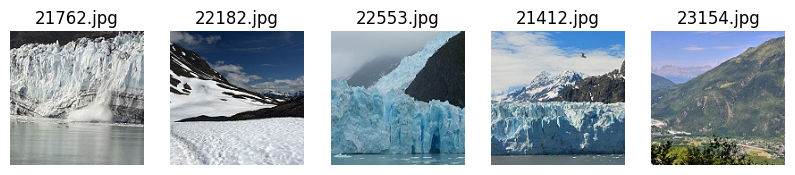

Random Test Images:
Showing random images from category: street


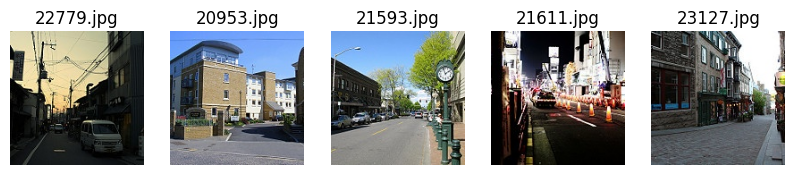

In [7]:
import os
import random
from matplotlib import pyplot as plt
from PIL import Image

directory = "/kaggle/input/intel-image-dataset/Intel Image Dataset" 

def show_random_images(directory, num_images=5):
    """
    Display random images from a directory.
    
    Args:
        directory (str): Path to the directory containing category subfolders.
        num_images (int): Number of random images to display.
    """
    # Get all category subfolders
    categories = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    if not categories:
        print(f"No categories found in {directory}")
        return

    # Select random category and images
    category = random.choice(categories)
    category_path = os.path.join(directory, category)
    images = os.listdir(category_path)
    if not images:
        print(f"No images found in category {category} of {directory}")
        return

    random_images = random.sample(images, min(len(images), num_images))

    # Display images
    print(f"Showing random images from category: {category}")
    plt.figure(figsize=(10, 5))
    for i, image_name in enumerate(random_images, start=1):
        image_path = os.path.join(category_path, image_name)
        image = Image.open(image_path)
        plt.subplot(1, len(random_images), i)
        plt.imshow(image)
        plt.axis('off')
        plt.title(image_name)
    plt.show()

# Display random images from train and test directories
print("Random Train Images:")
show_random_images('split_dataset/train')

print("Random Test Images:")
show_random_images('split_dataset/test')


In [8]:
import sys
from matplotlib import pyplot as plt
import tensorflow
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, f1_score, roc_curve, auc
import seaborn as sns

In [9]:
from tensorflow.keras.applications import VGG16
# Define the model using VGG16
def define_model(num_classes):
    # Load the pre-trained VGG16 model without the top classifier layer
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze the convolutional base
    for layer in base_model.layers:
        layer.trainable = False

    # Build the model
    model = Sequential()
    model.add(base_model)

    # Add custom classification head
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [10]:
num_classes = 6  
model = define_model(num_classes)

# Summary of the model
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [11]:
def plot_curves(history):
    # Plot Accuracy Curves
    plt.figure(figsize=(12, 4))

    # Training vs Validation Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Training vs Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [12]:
def plot_pr_curve(y_true, y_probs, num_classes):
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_probs[:, i])
        plt.plot(recall, precision, label=f'Class {i}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def plot_curves(history):
    # Plot Accuracy Curves
    plt.figure(figsize=(12, 4))

    # Training vs Validation Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Training vs Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [14]:

def plot_pr_curve(y_true, y_probs, num_classes):
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_probs[:, i])
        plt.plot(recall, precision, label=f'Class {i}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid()
    plt.show()


In [15]:

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [16]:

# Define the model using VGG16
def define_model(num_classes, dropout_rate=0.5):
    # Load the pre-trained VGG16 model without the top classifier layer
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze the convolutional base
    for layer in base_model.layers:
        layer.trainable = False

    # Build the model
    model = Sequential()
    model.add(base_model)

    # Add custom classification head with Dropout
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(dropout_rate))  # Add Dropout after the dense layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [17]:
def run_test_harness():
    # Prepare data generators
    datagen = ImageDataGenerator(rescale=1.0 / 255.0)

    # Train and test directories
    train_dir = 'split_dataset/train'
    test_dir = 'split_dataset/test'

    # Prepare iterators for training and testing datasets
    train_it = datagen.flow_from_directory(
        train_dir,
        batch_size=32,
        target_size=(224, 224),
        class_mode='categorical',  # Multi-class classification
        shuffle=True
    )

    test_it = datagen.flow_from_directory(
        test_dir,
        batch_size=32,
        target_size=(224, 224),
        class_mode='categorical',
        shuffle=False
    )

    # Define the model with a dropout rate
    num_classes = len(train_it.class_indices)  # Number of classes

    # Get the VGG16 base model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Identify the layers in Block 3
    block3_layers = [
        layer for layer in base_model.layers
        if layer.name.startswith('block3')
    ]

    # Loop through different dropout rates from 0.1 to 0.7
    for dropout_rate in np.arange(0.1, 0.8, 0.1):
        print(f"Testing with Dropout rate: {dropout_rate}")

        # Define the model for each dropout rate
        model = define_model(num_classes, dropout_rate=dropout_rate)
        
        # Training loop: progressively unfreeze layers within Block 3
        for i in range(len(block3_layers)):
            # Freeze all layers initially
            for layer in base_model.layers:
                layer.trainable = False

            # Unfreeze layers within Block 3 up to the current layer
            for j in range(i + 1):
                block3_layers[j].trainable = True

            # Recompile the model after unfreezing layers
            model.compile(optimizer=Adam(learning_rate=0.0001),
                          loss='categorical_crossentropy', metrics=['accuracy'])

            # Train the model
            print(f"Training with Block 3 layers up to {block3_layers[i].name} unfrozen...")
            history = model.fit(
                train_it,
                validation_data=test_it,
                epochs=20
            )

            # Plot accuracy and loss curves for comparison
            plot_curves(history)

            # Evaluate model on test data
            test_steps = len(test_it)
            y_probs = model.predict(test_it, steps=test_steps, verbose=1)
            y_pred = np.argmax(y_probs, axis=1)
            y_true = test_it.classes

            # Confusion Matrix
            cm = confusion_matrix(y_true, y_pred)
            print("Confusion Matrix:\n", cm)

            # Plot Confusion Matrix
            class_names = list(test_it.class_indices.keys())
            plot_confusion_matrix(cm, class_names)

            # Classification Report
            report = classification_report(y_true, y_pred, target_names=class_names)
            print("Classification Report:\n", report)

            # One-hot encode y_true
            y_true_one_hot = np.zeros((len(y_true), num_classes))
            y_true_one_hot[np.arange(len(y_true)), y_true] = 1

            # Precision-Recall Curves
            plot_pr_curve(y_true_one_hot, y_probs, num_classes)

            # Save Confusion Matrix to CSV
            cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
            cm_df.to_csv(f'confusion_matrix_block3_layer_{block3_layers[i].name}_dropout_{dropout_rate}.csv', index=True)

            # Save classification report
            report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
            report_df = pd.DataFrame(report_dict).transpose()
            report_df.to_csv(f'classification_report_block3_layer_{block3_layers[i].name}_dropout_{dropout_rate}.csv', index=True)

    print("Model training and evaluation with Dropout complete.")



Found 2398 images belonging to 6 classes.
Found 602 images belonging to 6 classes.
Testing with Dropout rate: 0.1
Training with Block 3 layers up to block3_conv1 unfrozen...
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734505020.290457      75 service.cc:145] XLA service 0x7c75f4006ef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734505020.290518      75 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734505020.290526      75 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/75 ━━━━━━━━━━━━━━━━━━━━ 21:05 17s/step - accuracy: 0.0625 - loss: 2.0330

I0000 00:00:1734505035.570035      75 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


75/75 ━━━━━━━━━━━━━━━━━━━━ 60s 581ms/step - accuracy: 0.5698 - loss: 1.1013 - val_accuracy: 0.8355 - val_loss: 0.4695
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 202ms/step - accuracy: 0.8649 - loss: 0.3813 - val_accuracy: 0.8189 - val_loss: 0.4555
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 219ms/step - accuracy: 0.9169 - loss: 0.2644 - val_accuracy: 0.8638 - val_loss: 0.3898
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 220ms/step - accuracy: 0.9451 - loss: 0.1998 - val_accuracy: 0.8538 - val_loss: 0.4024
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 0.9548 - loss: 0.1614 - val_accuracy: 0.8522 - val_loss: 0.3976
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 200ms/step - accuracy: 0.9708 - loss: 0.1301 - val_accuracy: 0.8638 - val_loss: 0.3701
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 202ms/step - accuracy: 0.9779 - loss: 0.0952 - val_accuracy: 0.8439 - val_loss: 0.4315
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 207ms/step - accuracy: 0.9881 - loss: 0.0803 - val_accuracy: 0.843

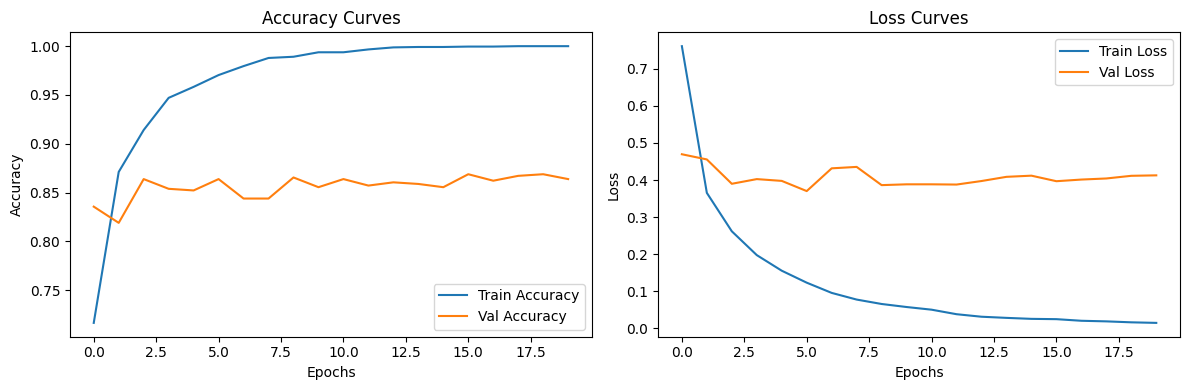

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step
Confusion Matrix:
 [[76  1  1  0  0 10]
 [ 0 94  0  1  0  0]
 [ 0  0 89 18  4  0]
 [ 0  0 15 88  2  0]
 [ 1  0  8  7 86  0]
 [11  1  0  1  1 87]]


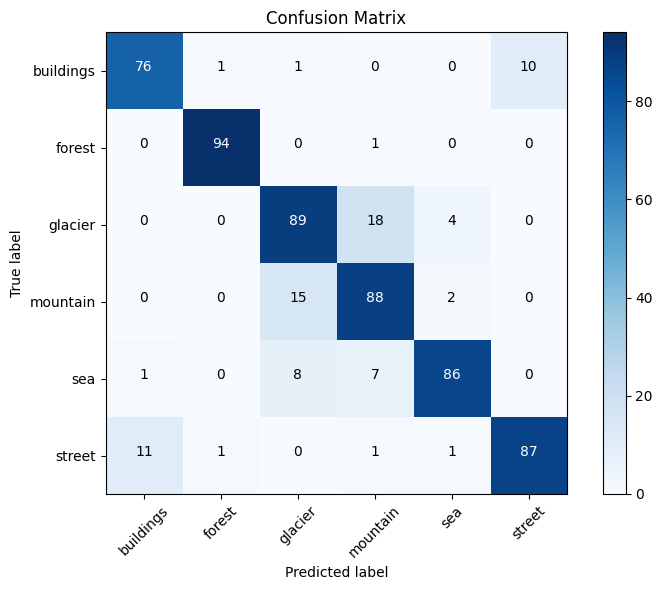

Classification Report:
               precision    recall  f1-score   support

   buildings       0.86      0.86      0.86        88
      forest       0.98      0.99      0.98        95
     glacier       0.79      0.80      0.79       111
    mountain       0.77      0.84      0.80       105
         sea       0.92      0.84      0.88       102
      street       0.90      0.86      0.88       101

    accuracy                           0.86       602
   macro avg       0.87      0.87      0.87       602
weighted avg       0.87      0.86      0.86       602



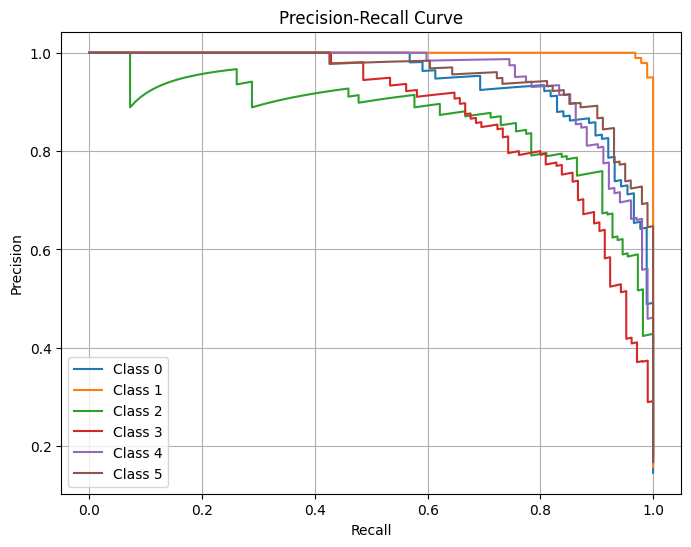

Training with Block 3 layers up to block3_conv2 unfrozen...
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 237ms/step - accuracy: 0.9978 - loss: 0.0214 - val_accuracy: 0.8538 - val_loss: 0.4666
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 211ms/step - accuracy: 0.9997 - loss: 0.0126 - val_accuracy: 0.8621 - val_loss: 0.4448
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 213ms/step - accuracy: 1.0000 - loss: 0.0124 - val_accuracy: 0.8638 - val_loss: 0.4269
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 209ms/step - accuracy: 1.0000 - loss: 0.0074 - val_accuracy: 0.8654 - val_loss: 0.4531
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 1.0000 - loss: 0.0066 - val_accuracy: 0.8671 - val_loss: 0.4431
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 1.0000 - loss: 0.0051 - val_accuracy: 0.8621 - val_loss: 0.4604
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 0.8654 - val_loss: 0.4576
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━

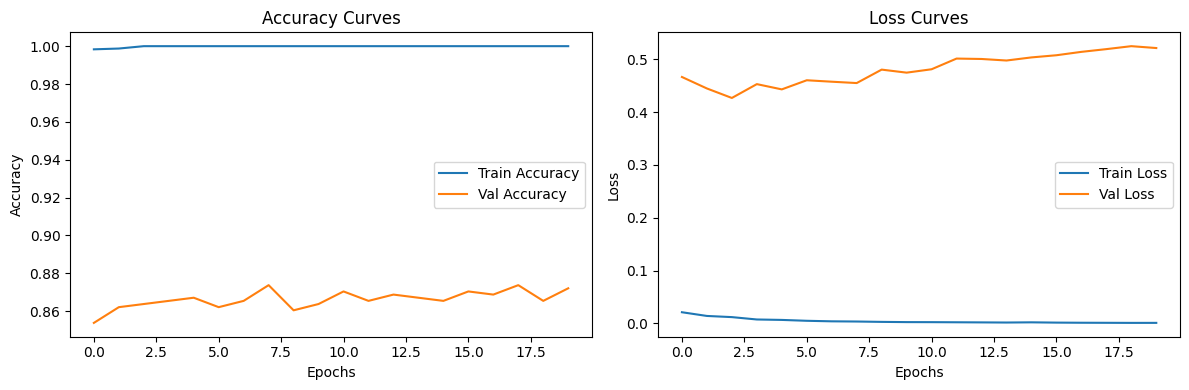

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step
Confusion Matrix:
 [[80  1  0  0  0  7]
 [ 0 94  0  1  0  0]
 [ 0  0 91 15  5  0]
 [ 0  0 16 86  3  0]
 [ 2  0  5  7 88  0]
 [11  2  0  1  1 86]]


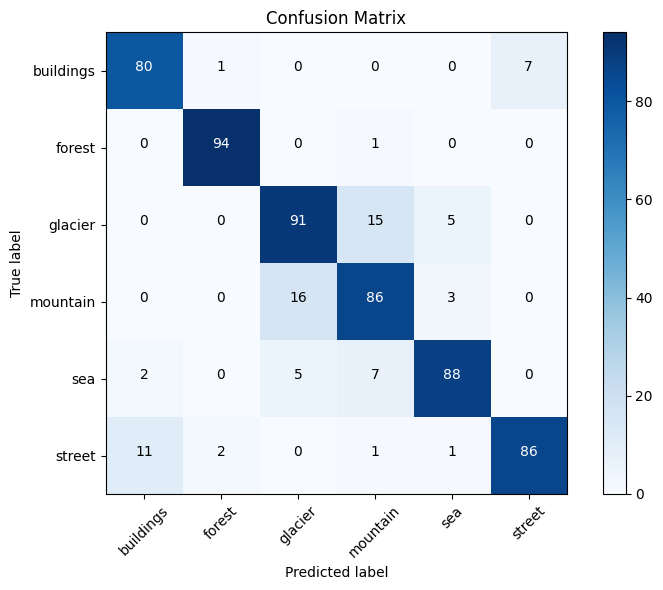

Classification Report:
               precision    recall  f1-score   support

   buildings       0.86      0.91      0.88        88
      forest       0.97      0.99      0.98        95
     glacier       0.81      0.82      0.82       111
    mountain       0.78      0.82      0.80       105
         sea       0.91      0.86      0.88       102
      street       0.92      0.85      0.89       101

    accuracy                           0.87       602
   macro avg       0.88      0.88      0.88       602
weighted avg       0.87      0.87      0.87       602



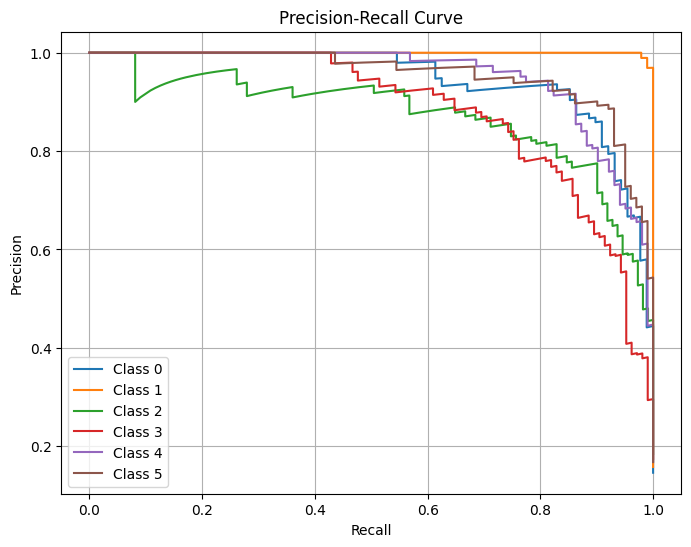

Training with Block 3 layers up to block3_conv3 unfrozen...
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 237ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.8605 - val_loss: 0.5920
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 210ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.8688 - val_loss: 0.5431
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 210ms/step - accuracy: 1.0000 - loss: 6.7718e-04 - val_accuracy: 0.8671 - val_loss: 0.5545
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 207ms/step - accuracy: 1.0000 - loss: 4.4542e-04 - val_accuracy: 0.8721 - val_loss: 0.5567
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 1.0000 - loss: 4.5457e-04 - val_accuracy: 0.8654 - val_loss: 0.5732
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 0.9997 - loss: 0.0011 - val_accuracy: 0.8671 - val_loss: 0.5566
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 0.9925 - loss: 0.0162 - val_accuracy: 0.8588 - val_loss: 0.6176
Epoch 8/20
75/75 ━━━━━━━━

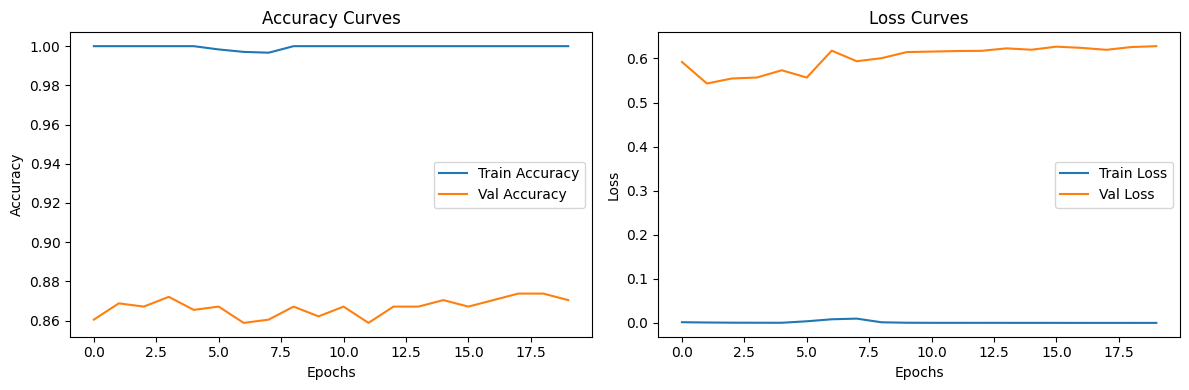

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step
Confusion Matrix:
 [[80  1  0  0  0  7]
 [ 0 94  0  1  0  0]
 [ 0  0 91 15  5  0]
 [ 0  0 15 86  4  0]
 [ 2  0  7  7 86  0]
 [10  2  0  1  1 87]]


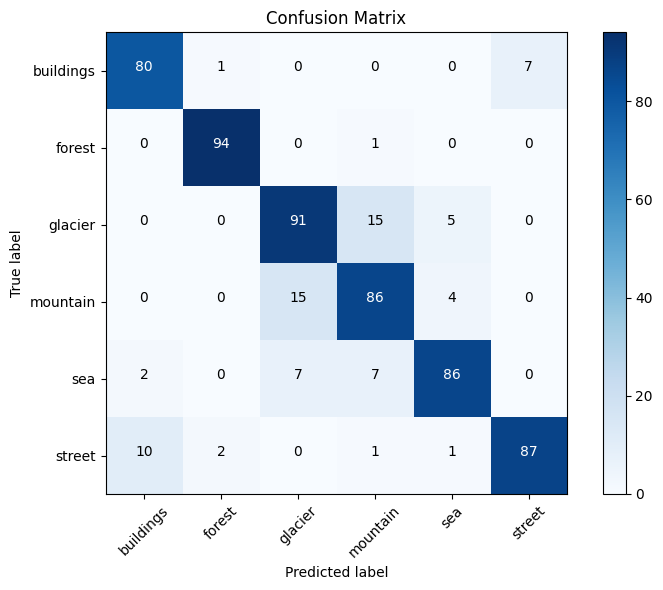

Classification Report:
               precision    recall  f1-score   support

   buildings       0.87      0.91      0.89        88
      forest       0.97      0.99      0.98        95
     glacier       0.81      0.82      0.81       111
    mountain       0.78      0.82      0.80       105
         sea       0.90      0.84      0.87       102
      street       0.93      0.86      0.89       101

    accuracy                           0.87       602
   macro avg       0.87      0.87      0.87       602
weighted avg       0.87      0.87      0.87       602



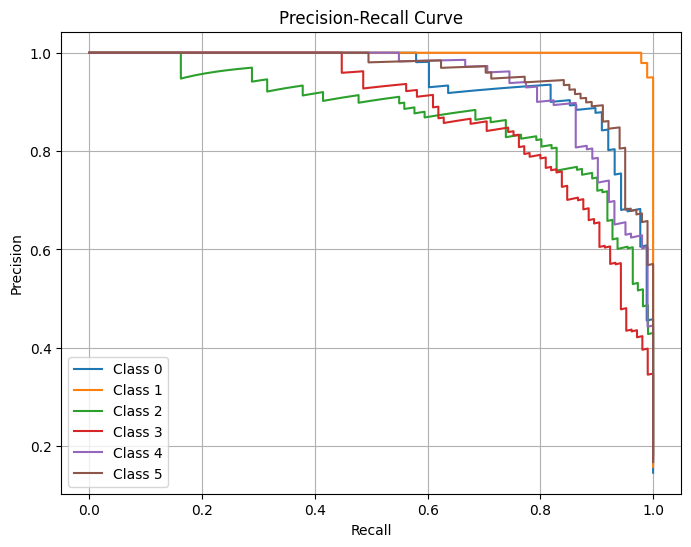

Training with Block 3 layers up to block3_pool unfrozen...
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 238ms/step - accuracy: 1.0000 - loss: 6.2533e-04 - val_accuracy: 0.8688 - val_loss: 0.6451
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 213ms/step - accuracy: 1.0000 - loss: 2.4070e-04 - val_accuracy: 0.8621 - val_loss: 0.6583
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 211ms/step - accuracy: 1.0000 - loss: 1.4047e-04 - val_accuracy: 0.8654 - val_loss: 0.6668
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 206ms/step - accuracy: 1.0000 - loss: 1.3274e-04 - val_accuracy: 0.8654 - val_loss: 0.6812
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 1.0000 - loss: 7.4982e-05 - val_accuracy: 0.8721 - val_loss: 0.6719
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 1.0000 - loss: 8.6027e-05 - val_accuracy: 0.8688 - val_loss: 0.6831
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 206ms/step - accuracy: 1.0000 - loss: 8.1330e-05 - val_accuracy: 0.8721 - val_loss: 0.6833
Epoch 8/20

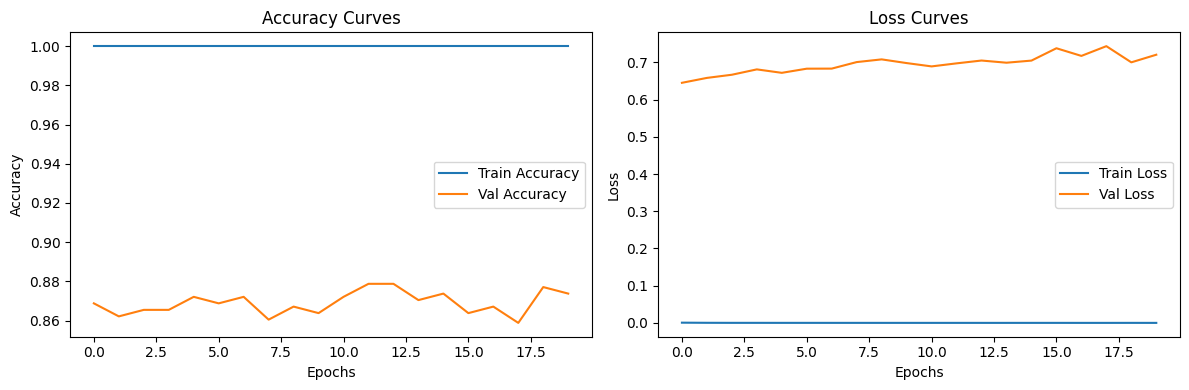

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step
Confusion Matrix:
 [[80  1  0  0  0  7]
 [ 0 93  0  2  0  0]
 [ 0  0 95 12  4  0]
 [ 0  0 19 83  3  0]
 [ 1  0  6  8 87  0]
 [11  0  0  1  1 88]]


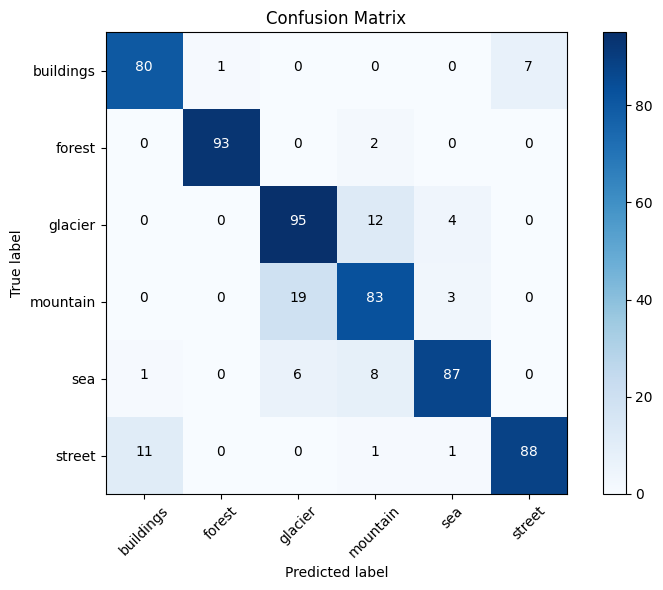

Classification Report:
               precision    recall  f1-score   support

   buildings       0.87      0.91      0.89        88
      forest       0.99      0.98      0.98        95
     glacier       0.79      0.86      0.82       111
    mountain       0.78      0.79      0.79       105
         sea       0.92      0.85      0.88       102
      street       0.93      0.87      0.90       101

    accuracy                           0.87       602
   macro avg       0.88      0.88      0.88       602
weighted avg       0.88      0.87      0.87       602



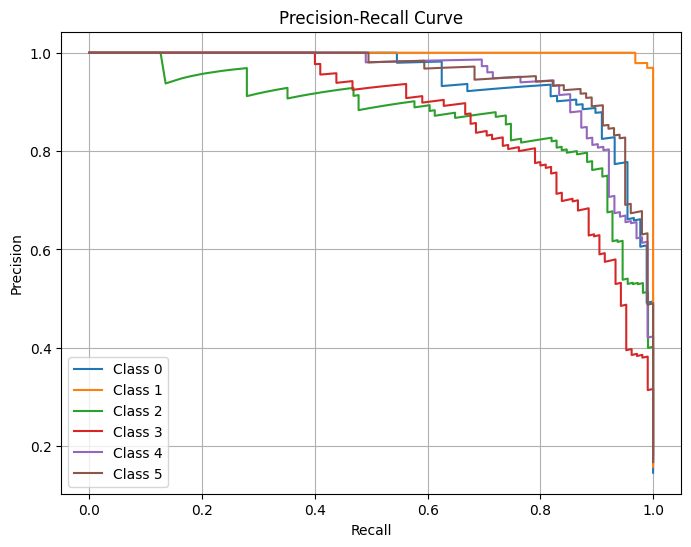

Testing with Dropout rate: 0.2
Training with Block 3 layers up to block3_conv1 unfrozen...
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 240ms/step - accuracy: 0.5992 - loss: 1.1019 - val_accuracy: 0.8023 - val_loss: 0.5116
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 213ms/step - accuracy: 0.8703 - loss: 0.3881 - val_accuracy: 0.8439 - val_loss: 0.4284
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 212ms/step - accuracy: 0.9113 - loss: 0.2897 - val_accuracy: 0.8638 - val_loss: 0.3867
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 207ms/step - accuracy: 0.9515 - loss: 0.1915 - val_accuracy: 0.8754 - val_loss: 0.3751
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 0.9461 - loss: 0.1756 - val_accuracy: 0.8738 - val_loss: 0.3764
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 0.9681 - loss: 0.1237 - val_accuracy: 0.8704 - val_loss: 0.3753
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 206ms/step - accuracy: 0.9811 - loss: 0.0969 - val_accuracy: 0.8688 - val_loss: 0.3685
Epoch 

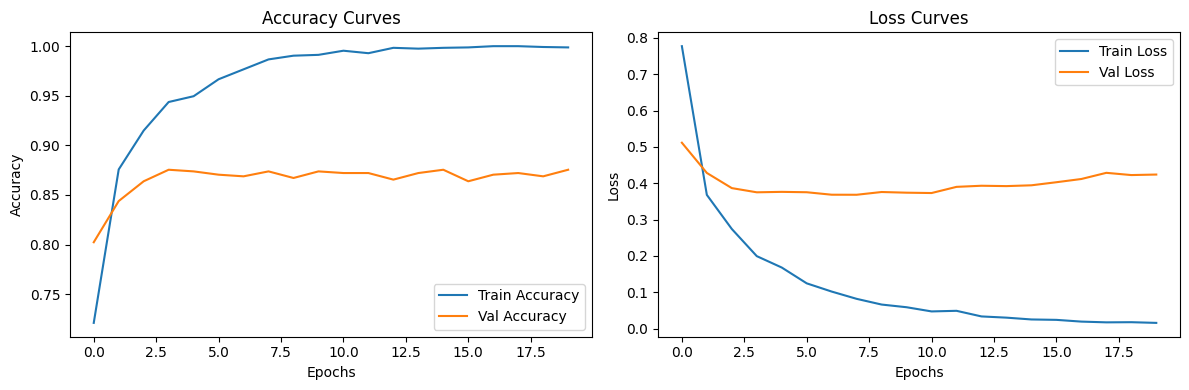

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step
Confusion Matrix:
 [[77  1  1  0  0  9]
 [ 0 94  0  1  0  0]
 [ 0  0 96 11  4  0]
 [ 0  0 17 85  3  0]
 [ 2  0  8  7 85  0]
 [ 9  0  0  1  1 90]]


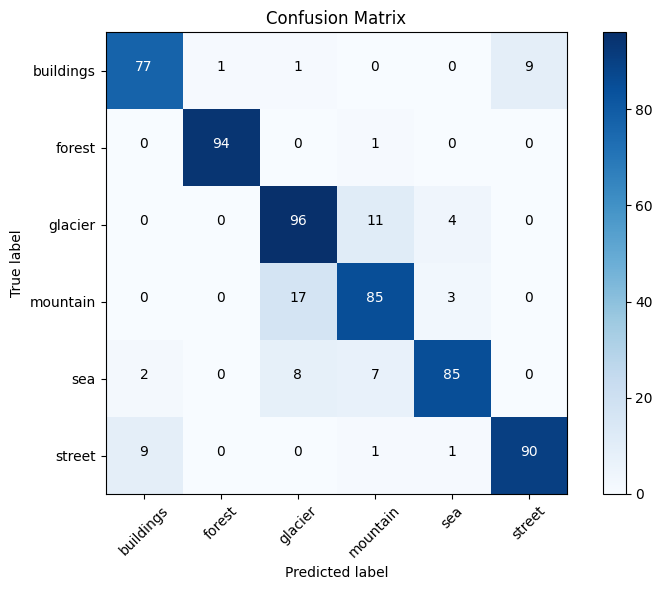

Classification Report:
               precision    recall  f1-score   support

   buildings       0.88      0.88      0.88        88
      forest       0.99      0.99      0.99        95
     glacier       0.79      0.86      0.82       111
    mountain       0.81      0.81      0.81       105
         sea       0.91      0.83      0.87       102
      street       0.91      0.89      0.90       101

    accuracy                           0.88       602
   macro avg       0.88      0.88      0.88       602
weighted avg       0.88      0.88      0.88       602



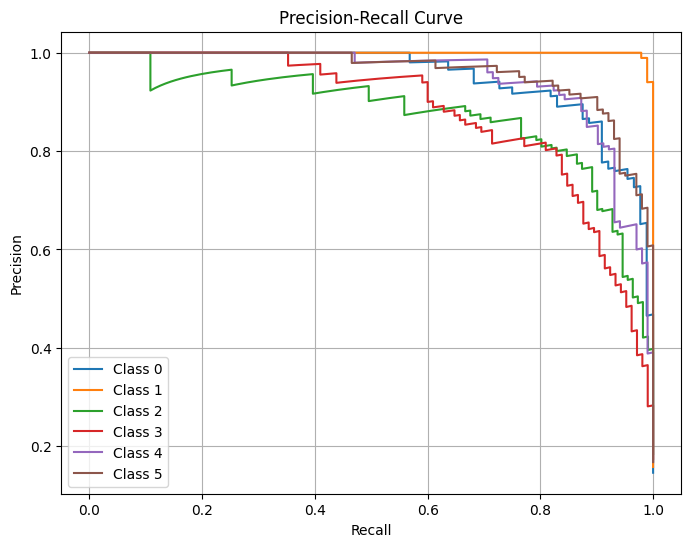

Training with Block 3 layers up to block3_conv2 unfrozen...
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 238ms/step - accuracy: 0.9963 - loss: 0.0251 - val_accuracy: 0.8555 - val_loss: 0.4670
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 211ms/step - accuracy: 0.9995 - loss: 0.0149 - val_accuracy: 0.8488 - val_loss: 0.4821
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 213ms/step - accuracy: 0.9979 - loss: 0.0121 - val_accuracy: 0.8688 - val_loss: 0.4521
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 209ms/step - accuracy: 1.0000 - loss: 0.0085 - val_accuracy: 0.8688 - val_loss: 0.4466
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 1.0000 - loss: 0.0082 - val_accuracy: 0.8671 - val_loss: 0.4783
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 1.0000 - loss: 0.0062 - val_accuracy: 0.8704 - val_loss: 0.4704
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 0.8721 - val_loss: 0.4683
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━

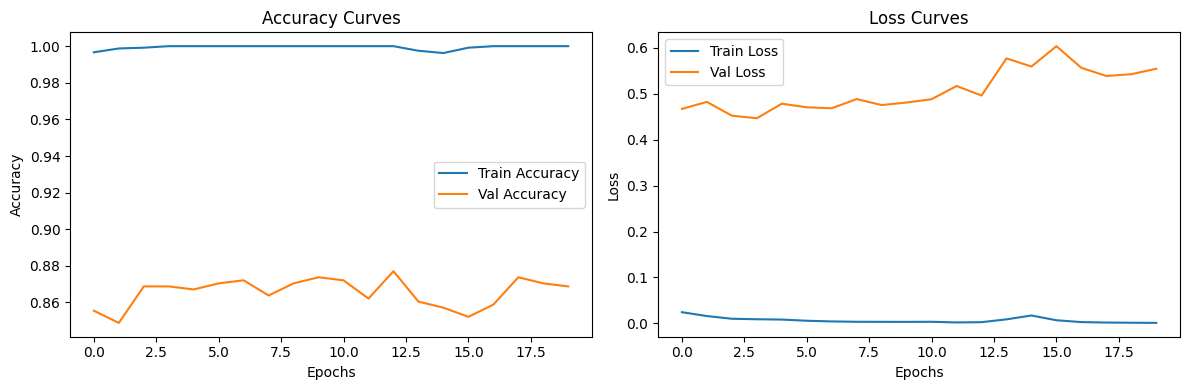

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step
Confusion Matrix:
 [[78  1  0  0  0  9]
 [ 0 94  0  1  0  0]
 [ 0  0 87 18  6  0]
 [ 0  0 14 87  4  0]
 [ 2  0  5  7 88  0]
 [ 9  1  0  1  1 89]]


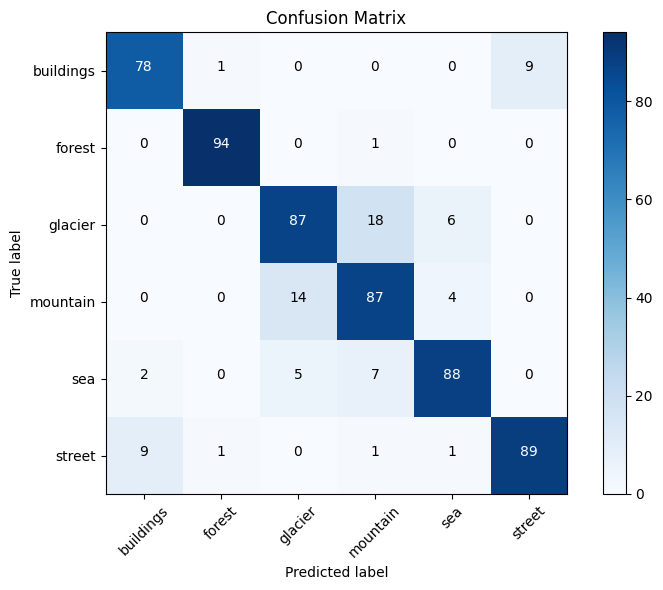

Classification Report:
               precision    recall  f1-score   support

   buildings       0.88      0.89      0.88        88
      forest       0.98      0.99      0.98        95
     glacier       0.82      0.78      0.80       111
    mountain       0.76      0.83      0.79       105
         sea       0.89      0.86      0.88       102
      street       0.91      0.88      0.89       101

    accuracy                           0.87       602
   macro avg       0.87      0.87      0.87       602
weighted avg       0.87      0.87      0.87       602



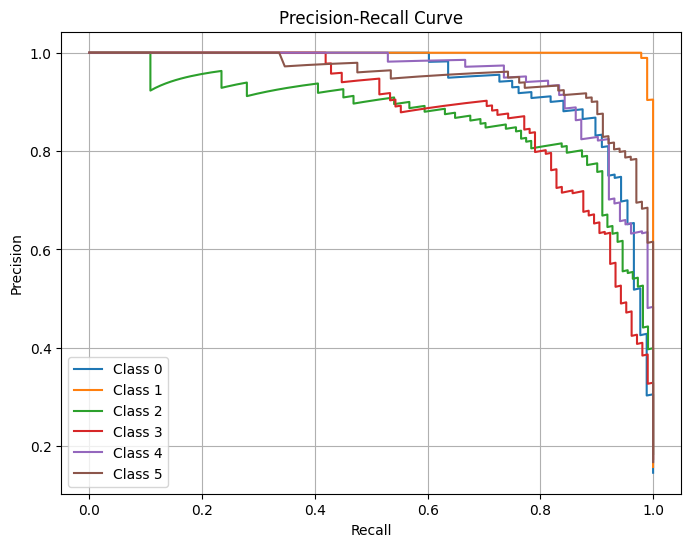

Training with Block 3 layers up to block3_conv3 unfrozen...
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 238ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.8704 - val_loss: 0.5795
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 210ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.8721 - val_loss: 0.5726
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 212ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.8721 - val_loss: 0.5934
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.8621 - val_loss: 0.5984
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.8688 - val_loss: 0.6255
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 1.0000 - loss: 7.9374e-04 - val_accuracy: 0.8771 - val_loss: 0.6285
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 1.0000 - loss: 6.7313e-04 - val_accuracy: 0.8688 - val_loss: 0.6159
Epoch 8/20
75/75 ━━━━━━━━━━━━

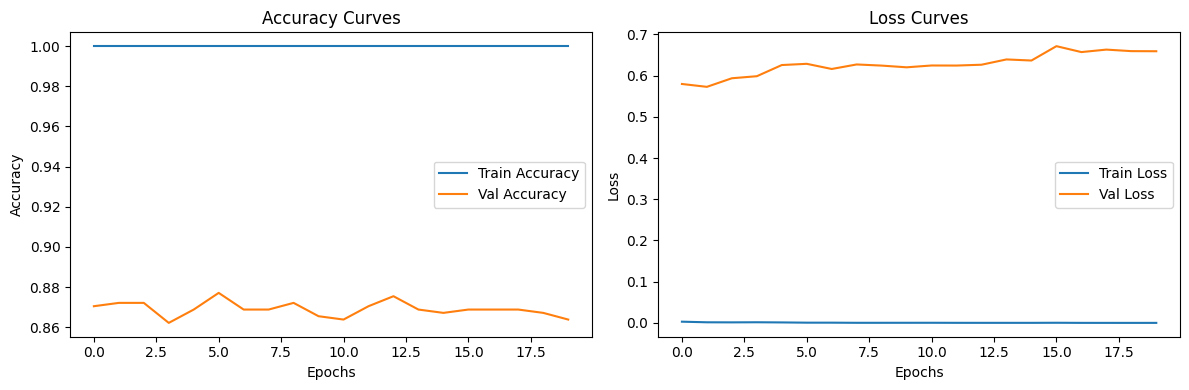

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step
Confusion Matrix:
 [[76  1  0  0  0 11]
 [ 0 94  0  1  0  0]
 [ 0  0 85 22  4  0]
 [ 0  0 13 87  5  0]
 [ 2  0  5  7 88  0]
 [ 8  1  0  2  0 90]]


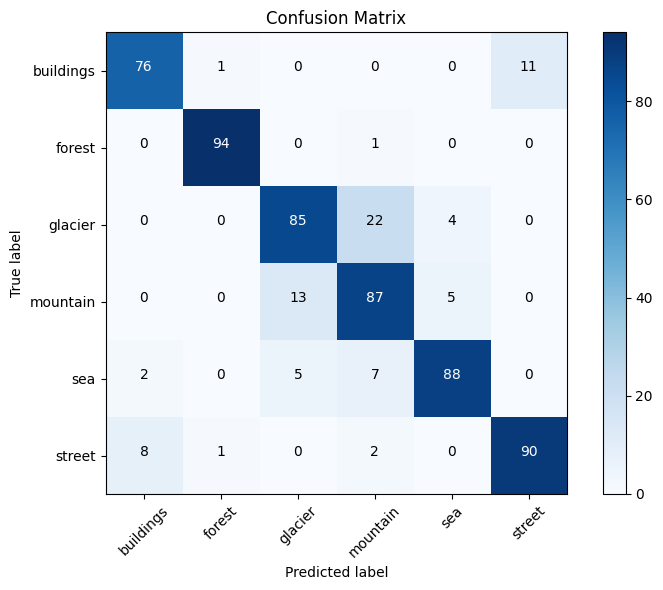

Classification Report:
               precision    recall  f1-score   support

   buildings       0.88      0.86      0.87        88
      forest       0.98      0.99      0.98        95
     glacier       0.83      0.77      0.79       111
    mountain       0.73      0.83      0.78       105
         sea       0.91      0.86      0.88       102
      street       0.89      0.89      0.89       101

    accuracy                           0.86       602
   macro avg       0.87      0.87      0.87       602
weighted avg       0.87      0.86      0.86       602



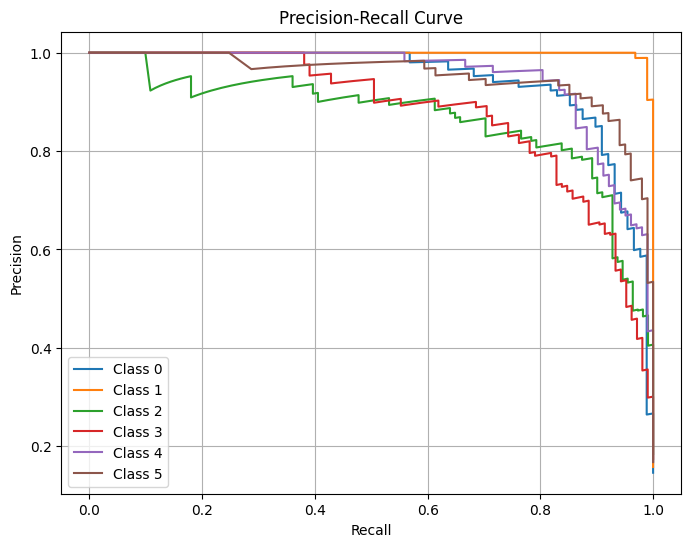

Training with Block 3 layers up to block3_pool unfrozen...
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 237ms/step - accuracy: 1.0000 - loss: 4.1480e-04 - val_accuracy: 0.8538 - val_loss: 0.7655
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 210ms/step - accuracy: 1.0000 - loss: 5.5602e-04 - val_accuracy: 0.8621 - val_loss: 0.7001
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 211ms/step - accuracy: 0.9999 - loss: 9.7214e-04 - val_accuracy: 0.8588 - val_loss: 0.6814
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 207ms/step - accuracy: 0.9878 - loss: 0.0345 - val_accuracy: 0.8638 - val_loss: 0.6930
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 1.0000 - loss: 6.7998e-04 - val_accuracy: 0.8688 - val_loss: 0.6834
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 1.0000 - loss: 4.8589e-04 - val_accuracy: 0.8654 - val_loss: 0.6933
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 1.0000 - loss: 2.5056e-04 - val_accuracy: 0.8621 - val_loss: 0.7020
Epoch 8/20
75/

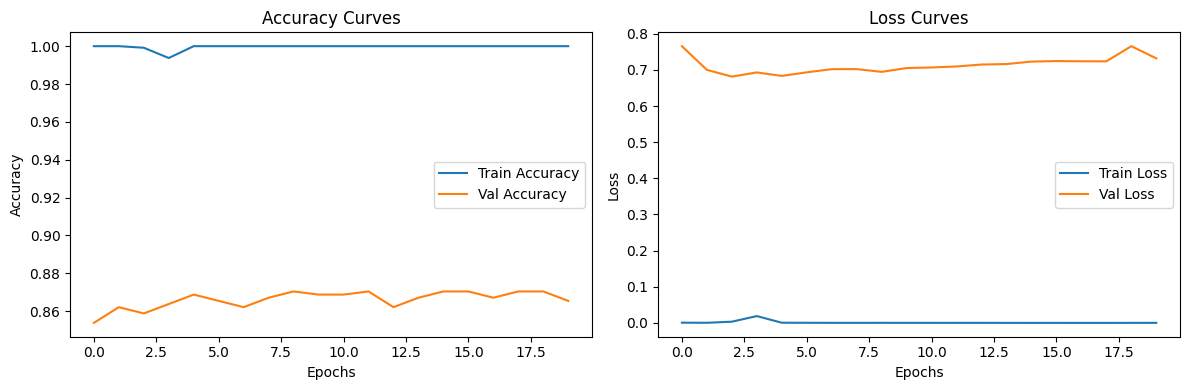

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step
Confusion Matrix:
 [[79  1  0  0  0  8]
 [ 0 94  0  1  0  0]
 [ 0  0 92 16  3  0]
 [ 0  0 16 85  4  0]
 [ 4  0  6  8 84  0]
 [11  1  0  2  0 87]]


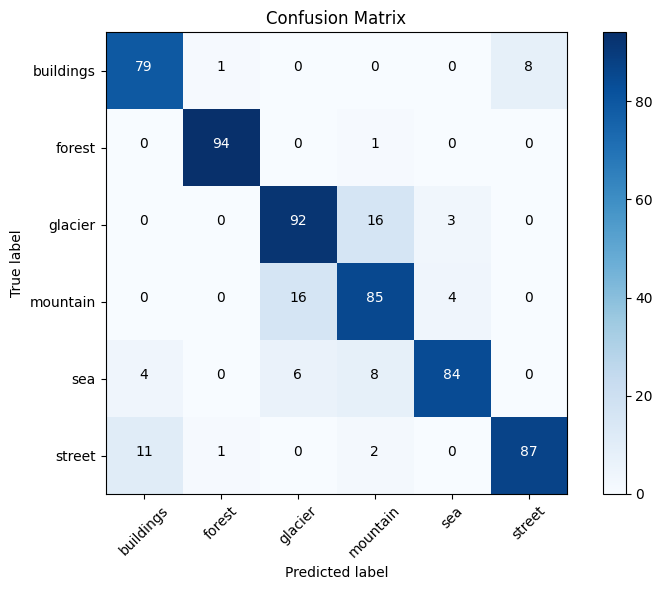

Classification Report:
               precision    recall  f1-score   support

   buildings       0.84      0.90      0.87        88
      forest       0.98      0.99      0.98        95
     glacier       0.81      0.83      0.82       111
    mountain       0.76      0.81      0.78       105
         sea       0.92      0.82      0.87       102
      street       0.92      0.86      0.89       101

    accuracy                           0.87       602
   macro avg       0.87      0.87      0.87       602
weighted avg       0.87      0.87      0.87       602



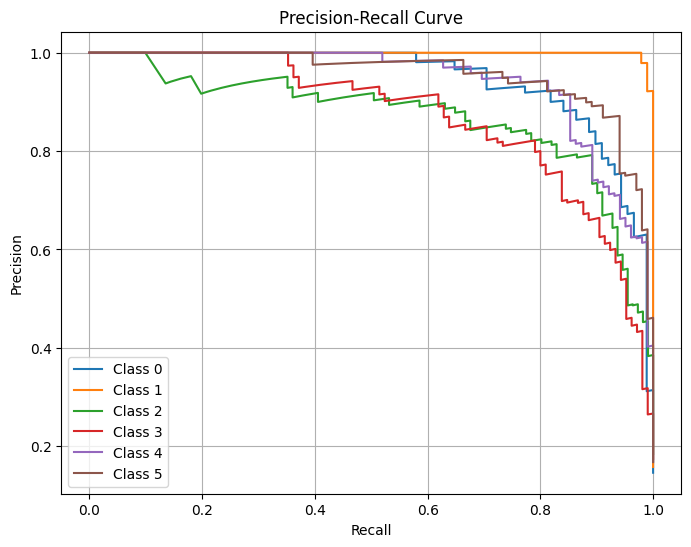

Testing with Dropout rate: 0.30000000000000004
Training with Block 3 layers up to block3_conv1 unfrozen...
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 240ms/step - accuracy: 0.5598 - loss: 1.1394 - val_accuracy: 0.8073 - val_loss: 0.5098
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 212ms/step - accuracy: 0.8440 - loss: 0.4412 - val_accuracy: 0.8488 - val_loss: 0.4312
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 212ms/step - accuracy: 0.8703 - loss: 0.3424 - val_accuracy: 0.8588 - val_loss: 0.4038
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 207ms/step - accuracy: 0.9186 - loss: 0.2661 - val_accuracy: 0.8439 - val_loss: 0.4174
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 0.9323 - loss: 0.2275 - val_accuracy: 0.8571 - val_loss: 0.3842
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 0.9446 - loss: 0.1762 - val_accuracy: 0.8605 - val_loss: 0.3942
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 207ms/step - accuracy: 0.9632 - loss: 0.1340 - val_accuracy: 0.8588 - val_los

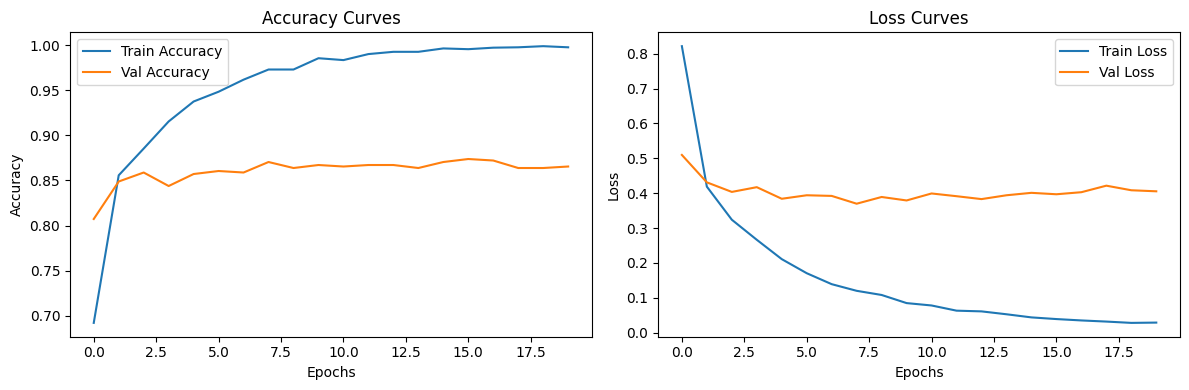

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step
Confusion Matrix:
 [[74  0  0  0  1 13]
 [ 0 93  0  1  1  0]
 [ 0  0 90 14  7  0]
 [ 0  0 14 85  6  0]
 [ 2  0  6  6 88  0]
 [ 8  0  0  1  1 91]]


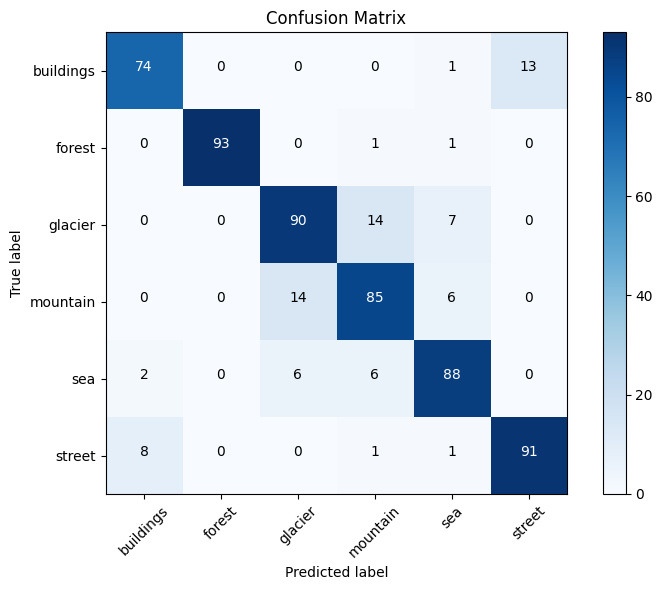

Classification Report:
               precision    recall  f1-score   support

   buildings       0.88      0.84      0.86        88
      forest       1.00      0.98      0.99        95
     glacier       0.82      0.81      0.81       111
    mountain       0.79      0.81      0.80       105
         sea       0.85      0.86      0.85       102
      street       0.88      0.90      0.89       101

    accuracy                           0.87       602
   macro avg       0.87      0.87      0.87       602
weighted avg       0.87      0.87      0.87       602



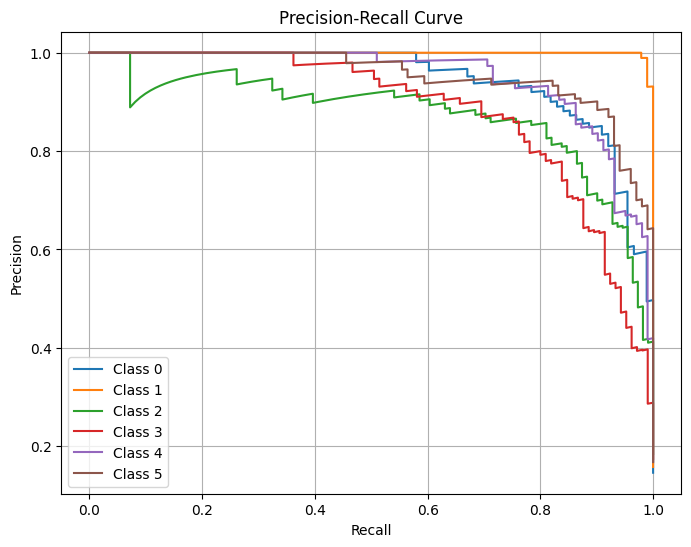

Training with Block 3 layers up to block3_conv2 unfrozen...
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 238ms/step - accuracy: 0.9931 - loss: 0.0354 - val_accuracy: 0.8588 - val_loss: 0.4437
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 211ms/step - accuracy: 0.9981 - loss: 0.0239 - val_accuracy: 0.8671 - val_loss: 0.4366
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 212ms/step - accuracy: 0.9991 - loss: 0.0184 - val_accuracy: 0.8605 - val_loss: 0.4748
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step - accuracy: 0.9992 - loss: 0.0191 - val_accuracy: 0.8538 - val_loss: 0.4720
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 0.9994 - loss: 0.0137 - val_accuracy: 0.8654 - val_loss: 0.4594
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 0.9987 - loss: 0.0158 - val_accuracy: 0.8654 - val_loss: 0.4707
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 0.9995 - loss: 0.0119 - val_accuracy: 0.8605 - val_loss: 0.4799
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━

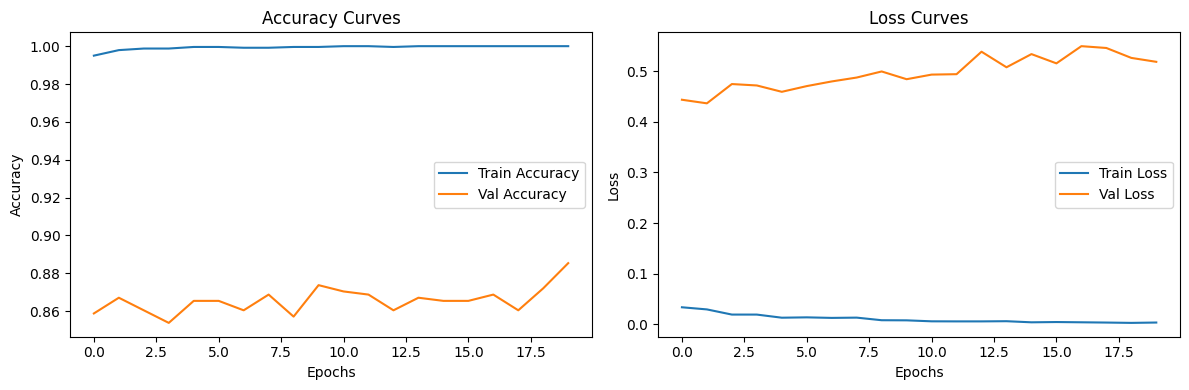

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step
Confusion Matrix:
 [[79  0  0  0  0  9]
 [ 0 94  0  1  0  0]
 [ 0  0 97  9  5  0]
 [ 0  0 18 82  5  0]
 [ 2  0  5  4 91  0]
 [ 9  0  0  0  2 90]]


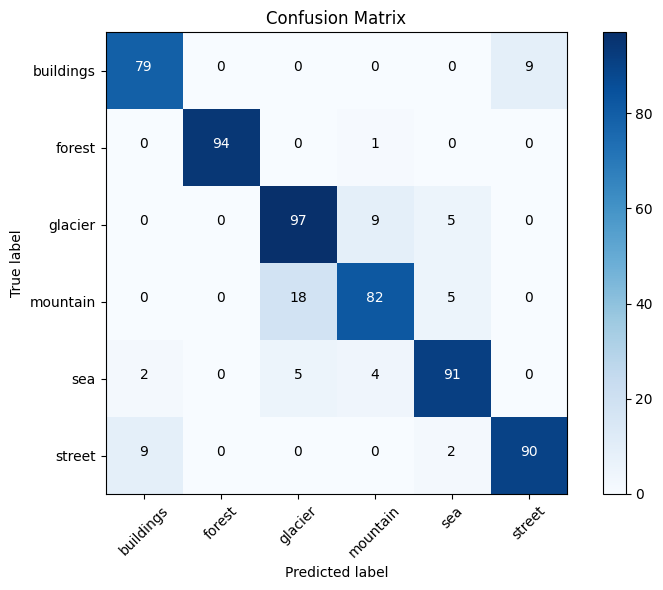

Classification Report:
               precision    recall  f1-score   support

   buildings       0.88      0.90      0.89        88
      forest       1.00      0.99      0.99        95
     glacier       0.81      0.87      0.84       111
    mountain       0.85      0.78      0.82       105
         sea       0.88      0.89      0.89       102
      street       0.91      0.89      0.90       101

    accuracy                           0.89       602
   macro avg       0.89      0.89      0.89       602
weighted avg       0.89      0.89      0.89       602



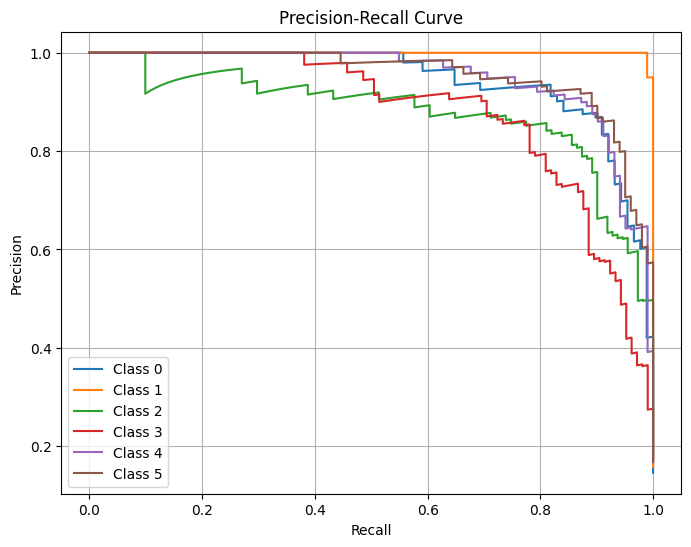

Training with Block 3 layers up to block3_conv3 unfrozen...
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 237ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 0.8654 - val_loss: 0.5367
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 210ms/step - accuracy: 0.9994 - loss: 0.0049 - val_accuracy: 0.8472 - val_loss: 0.6099
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 210ms/step - accuracy: 1.0000 - loss: 0.0063 - val_accuracy: 0.8671 - val_loss: 0.5848
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 206ms/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 0.8704 - val_loss: 0.5702
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.8688 - val_loss: 0.5668
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.8721 - val_loss: 0.5648
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 206ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.8704 - val_loss: 0.6046
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━

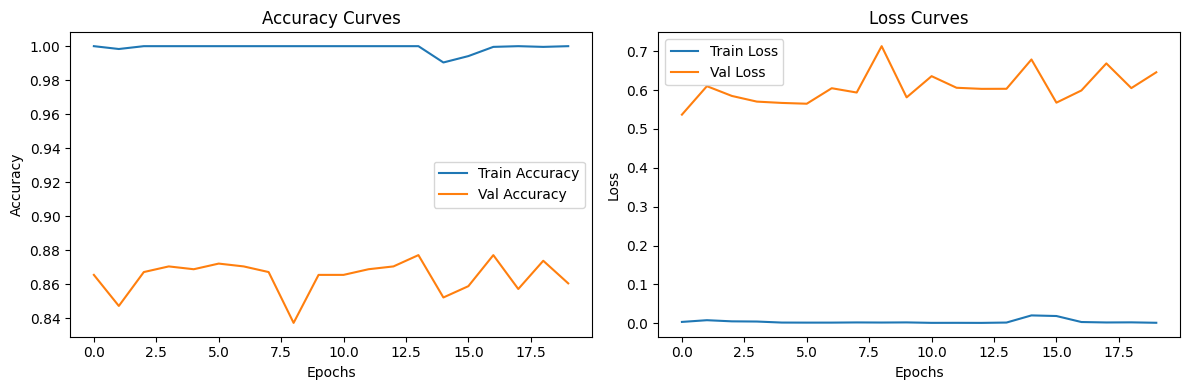

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step
Confusion Matrix:
 [[79  0  0  0  0  9]
 [ 0 94  0  1  0  0]
 [ 0  0 85 21  5  0]
 [ 0  0 13 90  2  0]
 [ 3  0  7  9 83  0]
 [12  0  0  1  1 87]]


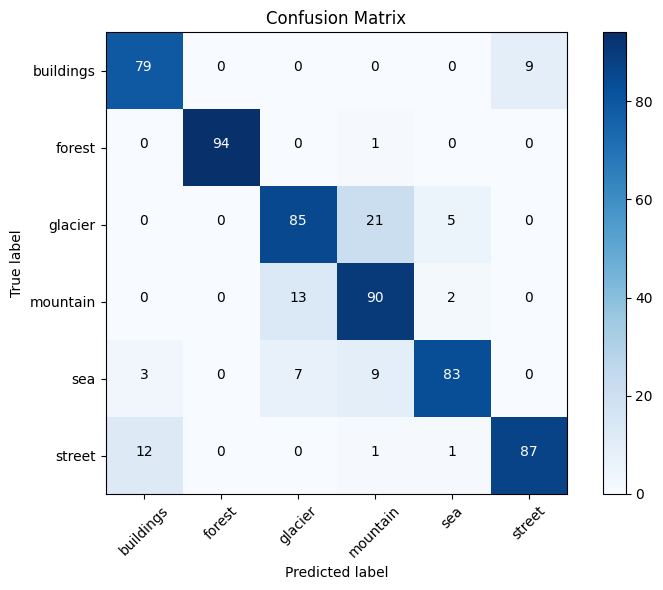

Classification Report:
               precision    recall  f1-score   support

   buildings       0.84      0.90      0.87        88
      forest       1.00      0.99      0.99        95
     glacier       0.81      0.77      0.79       111
    mountain       0.74      0.86      0.79       105
         sea       0.91      0.81      0.86       102
      street       0.91      0.86      0.88       101

    accuracy                           0.86       602
   macro avg       0.87      0.86      0.86       602
weighted avg       0.87      0.86      0.86       602



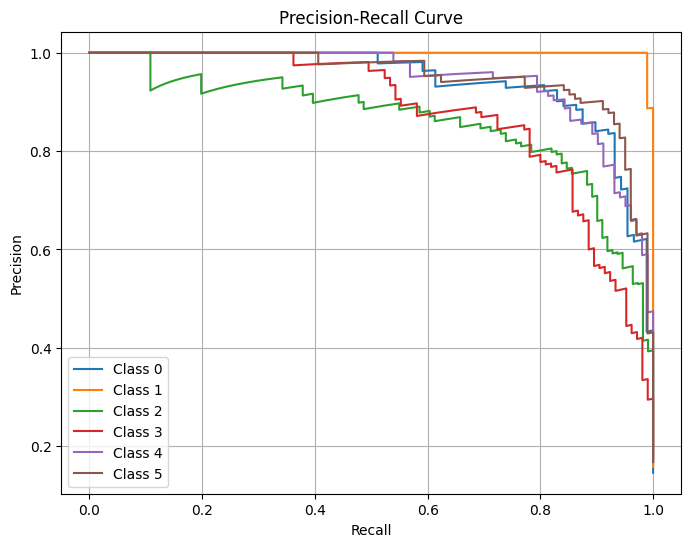

Training with Block 3 layers up to block3_pool unfrozen...
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 238ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.8355 - val_loss: 0.7823
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 212ms/step - accuracy: 0.9996 - loss: 0.0050 - val_accuracy: 0.8621 - val_loss: 0.7017
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 211ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.8688 - val_loss: 0.7012
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 207ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.8721 - val_loss: 0.6751
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 1.0000 - loss: 8.3964e-04 - val_accuracy: 0.8654 - val_loss: 0.7096
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 1.0000 - loss: 7.2456e-04 - val_accuracy: 0.8721 - val_loss: 0.7090
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 1.0000 - loss: 9.6085e-04 - val_accuracy: 0.8721 - val_loss: 0.7014
Epoch 8/20
75/75 ━━━━━━━━━

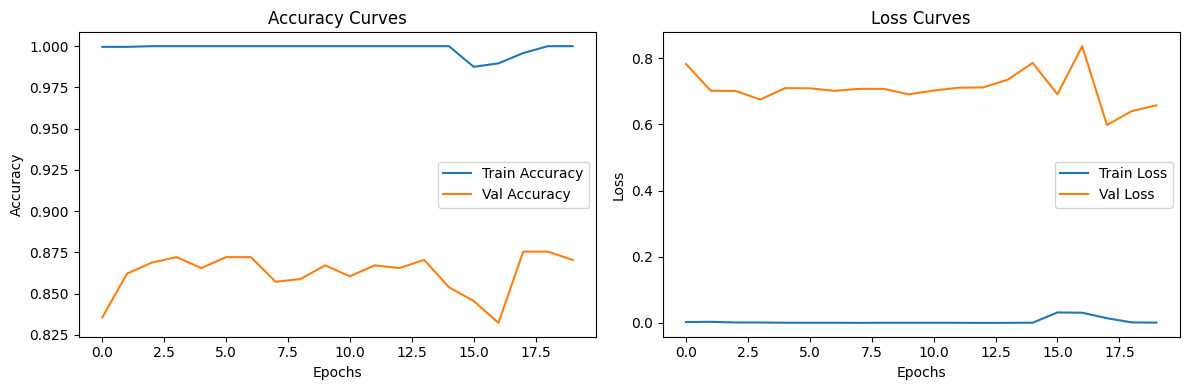

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step
Confusion Matrix:
 [[79  0  0  0  0  9]
 [ 0 93  0  1  1  0]
 [ 0  0 89 17  5  0]
 [ 0  0 11 89  5  0]
 [ 3  0  4  8 87  0]
 [11  1  0  1  1 87]]


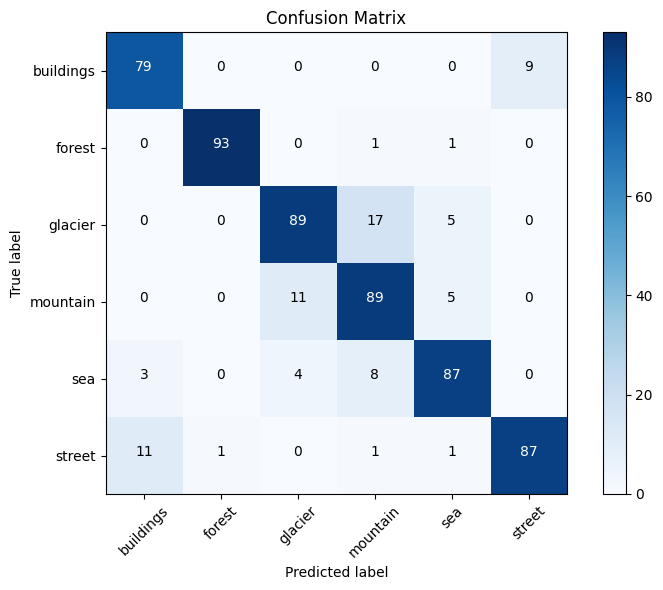

Classification Report:
               precision    recall  f1-score   support

   buildings       0.85      0.90      0.87        88
      forest       0.99      0.98      0.98        95
     glacier       0.86      0.80      0.83       111
    mountain       0.77      0.85      0.81       105
         sea       0.88      0.85      0.87       102
      street       0.91      0.86      0.88       101

    accuracy                           0.87       602
   macro avg       0.87      0.87      0.87       602
weighted avg       0.87      0.87      0.87       602



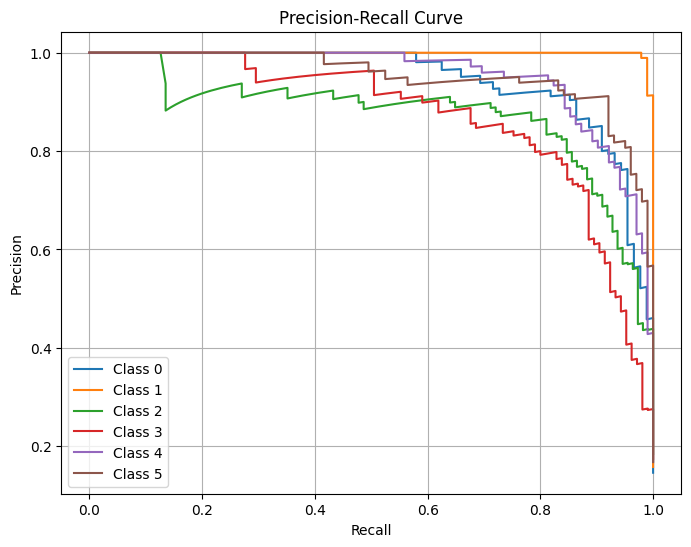

Testing with Dropout rate: 0.4
Training with Block 3 layers up to block3_conv1 unfrozen...
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 240ms/step - accuracy: 0.5142 - loss: 1.2554 - val_accuracy: 0.8123 - val_loss: 0.5171
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 212ms/step - accuracy: 0.8352 - loss: 0.4940 - val_accuracy: 0.8422 - val_loss: 0.4548
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 212ms/step - accuracy: 0.8653 - loss: 0.3882 - val_accuracy: 0.8522 - val_loss: 0.4296
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step - accuracy: 0.8915 - loss: 0.3254 - val_accuracy: 0.8654 - val_loss: 0.3934
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 0.9174 - loss: 0.2411 - val_accuracy: 0.8654 - val_loss: 0.3835
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 0.9425 - loss: 0.2114 - val_accuracy: 0.8688 - val_loss: 0.3772
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 206ms/step - accuracy: 0.9562 - loss: 0.1742 - val_accuracy: 0.8704 - val_loss: 0.3654
Epoch 

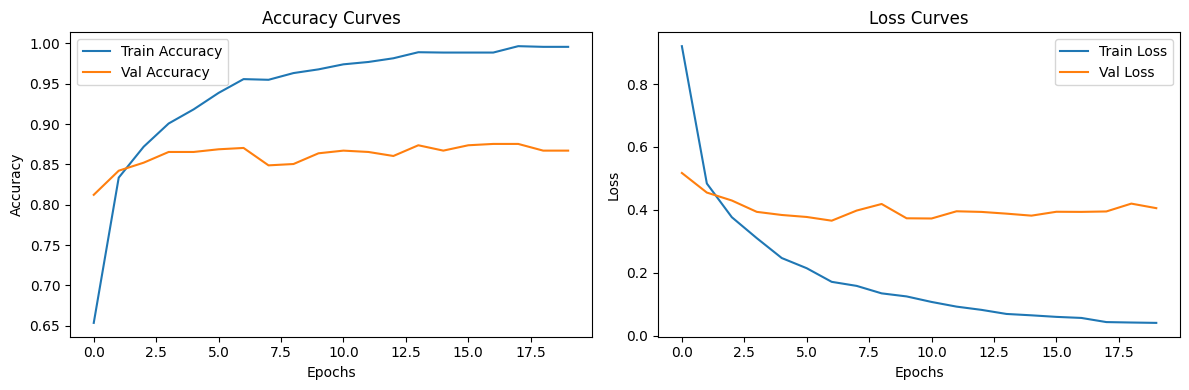

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step
Confusion Matrix:
 [[77  0  0  0  0 11]
 [ 0 93  1  0  0  1]
 [ 0  0 97  9  5  0]
 [ 0  0 25 75  5  0]
 [ 2  0  6  4 90  0]
 [ 9  0  0  0  2 90]]


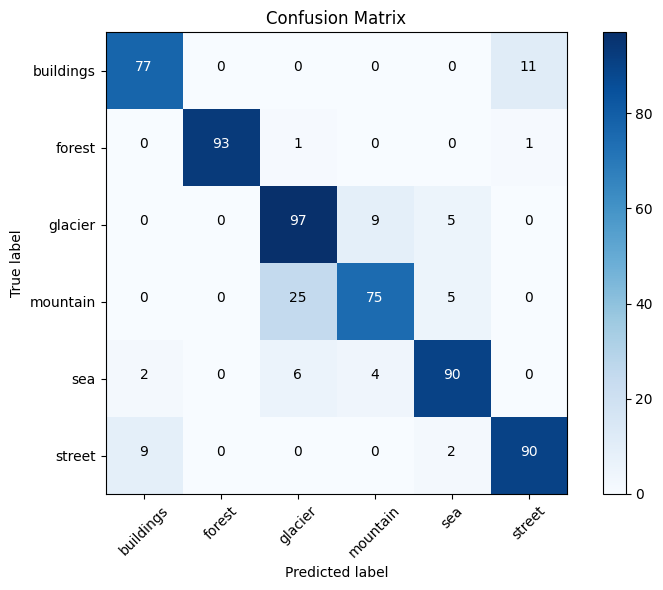

Classification Report:
               precision    recall  f1-score   support

   buildings       0.88      0.88      0.88        88
      forest       1.00      0.98      0.99        95
     glacier       0.75      0.87      0.81       111
    mountain       0.85      0.71      0.78       105
         sea       0.88      0.88      0.88       102
      street       0.88      0.89      0.89       101

    accuracy                           0.87       602
   macro avg       0.87      0.87      0.87       602
weighted avg       0.87      0.87      0.87       602



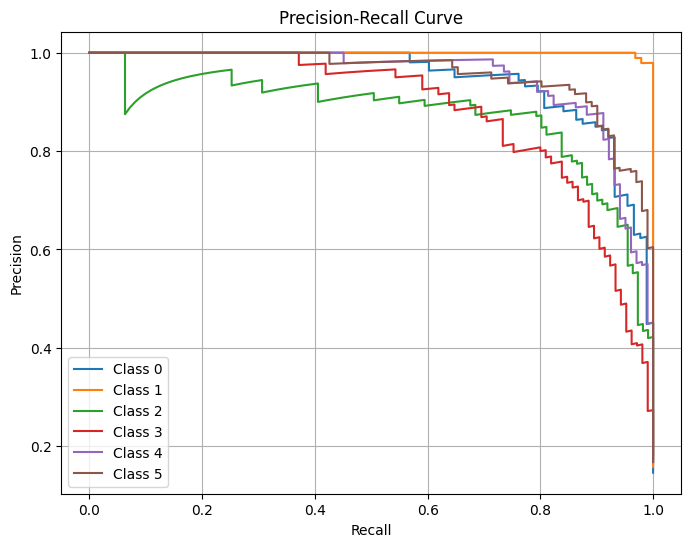

Training with Block 3 layers up to block3_conv2 unfrozen...
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 238ms/step - accuracy: 0.9898 - loss: 0.0502 - val_accuracy: 0.8555 - val_loss: 0.4354
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 211ms/step - accuracy: 0.9939 - loss: 0.0352 - val_accuracy: 0.8721 - val_loss: 0.4113
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 211ms/step - accuracy: 0.9933 - loss: 0.0349 - val_accuracy: 0.8754 - val_loss: 0.4322
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 207ms/step - accuracy: 0.9955 - loss: 0.0298 - val_accuracy: 0.8754 - val_loss: 0.4279
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 0.9950 - loss: 0.0291 - val_accuracy: 0.8654 - val_loss: 0.4361
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 0.9982 - loss: 0.0207 - val_accuracy: 0.8455 - val_loss: 0.4933
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 207ms/step - accuracy: 0.9962 - loss: 0.0250 - val_accuracy: 0.8654 - val_loss: 0.4475
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━

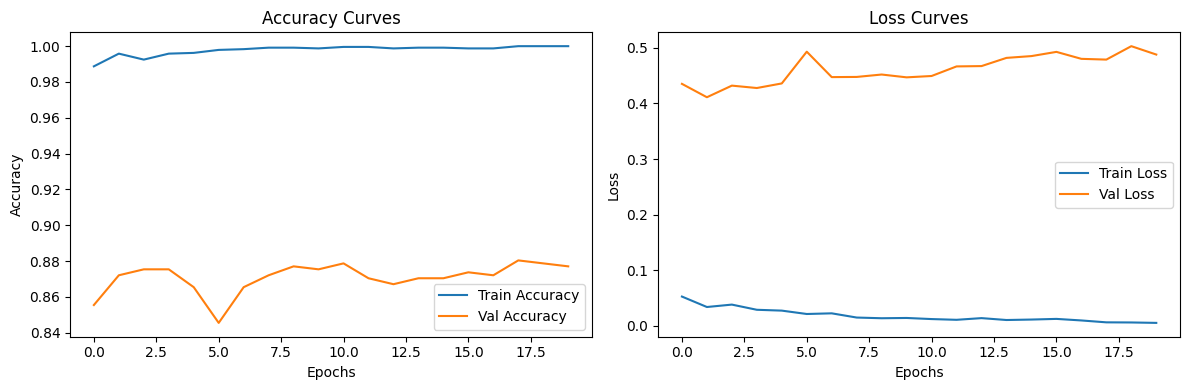

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step
Confusion Matrix:
 [[79  0  0  0  0  9]
 [ 0 94  0  1  0  0]
 [ 0  0 91 17  3  0]
 [ 0  0 14 88  3  0]
 [ 3  0  5  7 87  0]
 [10  0  0  1  1 89]]


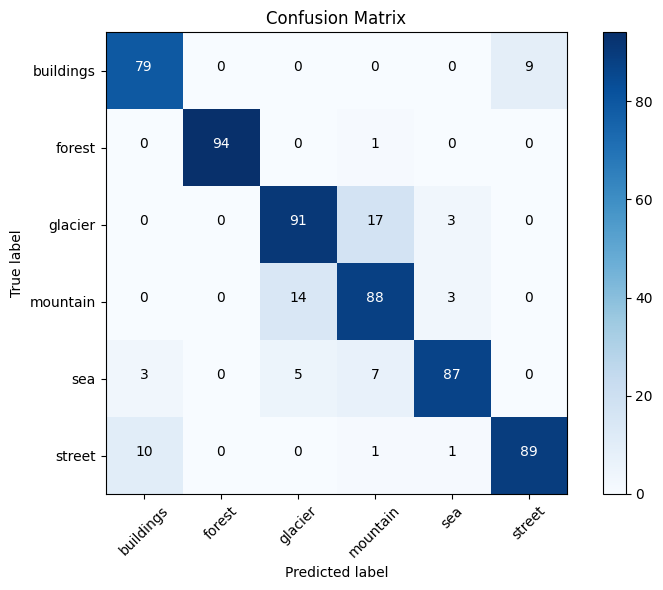

Classification Report:
               precision    recall  f1-score   support

   buildings       0.86      0.90      0.88        88
      forest       1.00      0.99      0.99        95
     glacier       0.83      0.82      0.82       111
    mountain       0.77      0.84      0.80       105
         sea       0.93      0.85      0.89       102
      street       0.91      0.88      0.89       101

    accuracy                           0.88       602
   macro avg       0.88      0.88      0.88       602
weighted avg       0.88      0.88      0.88       602



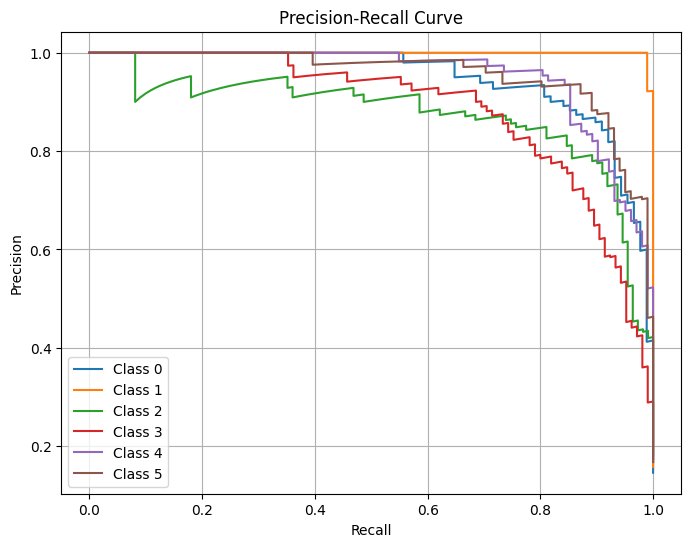

Training with Block 3 layers up to block3_conv3 unfrozen...
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 237ms/step - accuracy: 0.9985 - loss: 0.0095 - val_accuracy: 0.8721 - val_loss: 0.4917
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 211ms/step - accuracy: 1.0000 - loss: 0.0084 - val_accuracy: 0.8704 - val_loss: 0.4989
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 212ms/step - accuracy: 0.9995 - loss: 0.0045 - val_accuracy: 0.8654 - val_loss: 0.5321
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step - accuracy: 0.9996 - loss: 0.0074 - val_accuracy: 0.8704 - val_loss: 0.5035
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 0.9973 - loss: 0.0098 - val_accuracy: 0.8704 - val_loss: 0.5390
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 0.9998 - loss: 0.0048 - val_accuracy: 0.8555 - val_loss: 0.5423
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 206ms/step - accuracy: 0.9994 - loss: 0.0059 - val_accuracy: 0.8571 - val_loss: 0.5406
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━

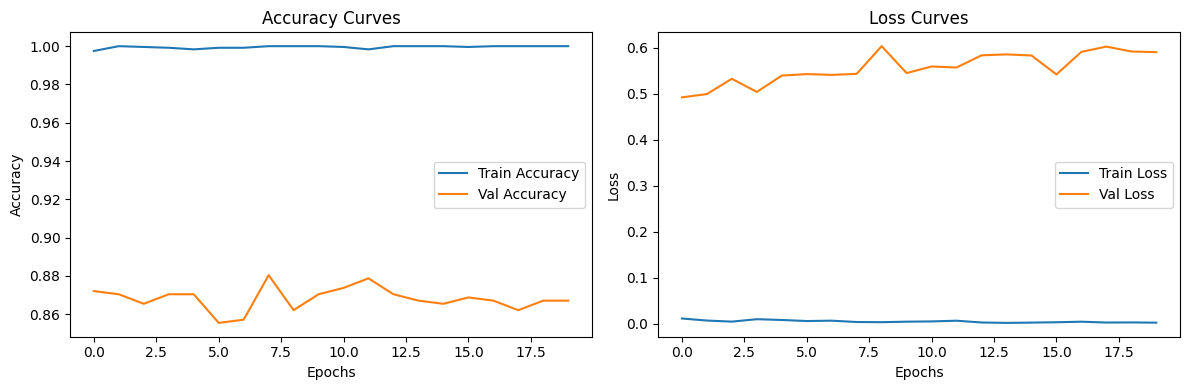

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step
Confusion Matrix:
 [[79  1  0  0  0  8]
 [ 0 94  0  1  0  0]
 [ 0  0 89 15  7  0]
 [ 0  0 15 85  5  0]
 [ 2  0  5  7 88  0]
 [11  1  0  0  2 87]]


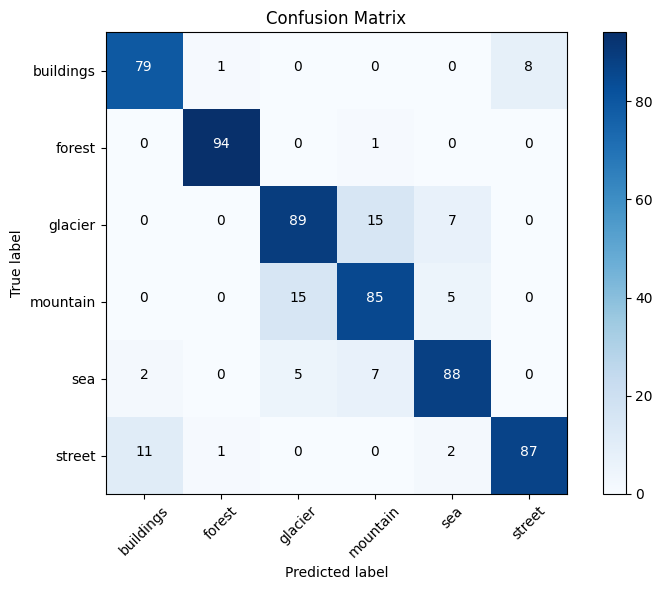

Classification Report:
               precision    recall  f1-score   support

   buildings       0.86      0.90      0.88        88
      forest       0.98      0.99      0.98        95
     glacier       0.82      0.80      0.81       111
    mountain       0.79      0.81      0.80       105
         sea       0.86      0.86      0.86       102
      street       0.92      0.86      0.89       101

    accuracy                           0.87       602
   macro avg       0.87      0.87      0.87       602
weighted avg       0.87      0.87      0.87       602



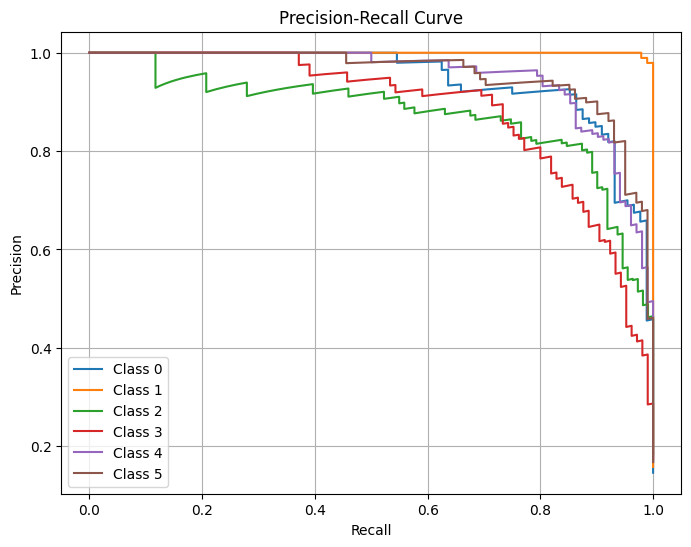

Training with Block 3 layers up to block3_pool unfrozen...
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 238ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.8671 - val_loss: 0.6123
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 214ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.8571 - val_loss: 0.6605
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 211ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.8654 - val_loss: 0.6007
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 206ms/step - accuracy: 0.9997 - loss: 0.0030 - val_accuracy: 0.8787 - val_loss: 0.5505
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 0.9998 - loss: 0.0100 - val_accuracy: 0.8638 - val_loss: 0.6215
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 0.9951 - loss: 0.0128 - val_accuracy: 0.8621 - val_loss: 0.6416
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.8522 - val_loss: 0.6979
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 

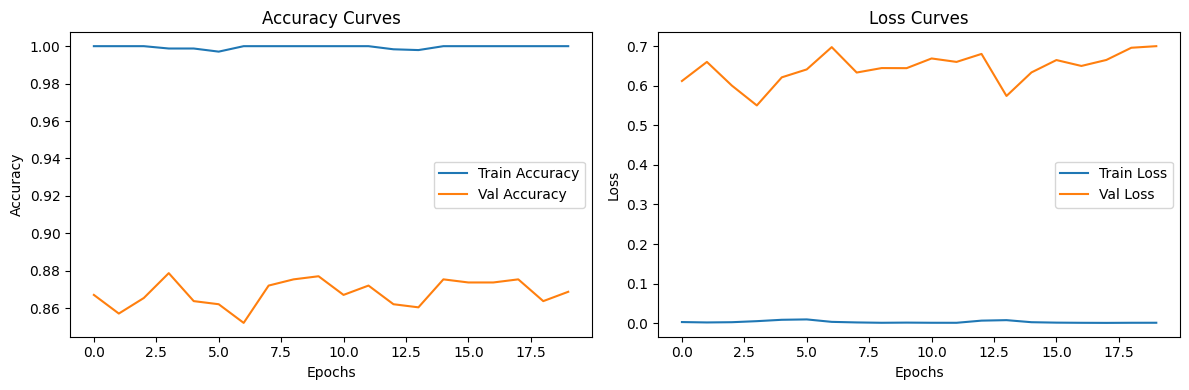

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step
Confusion Matrix:
 [[77  1  0  0  0 10]
 [ 0 94  0  1  0  0]
 [ 0  0 88 19  4  0]
 [ 0  0 14 89  2  0]
 [ 2  0  6  9 85  0]
 [ 8  1  0  2  0 90]]


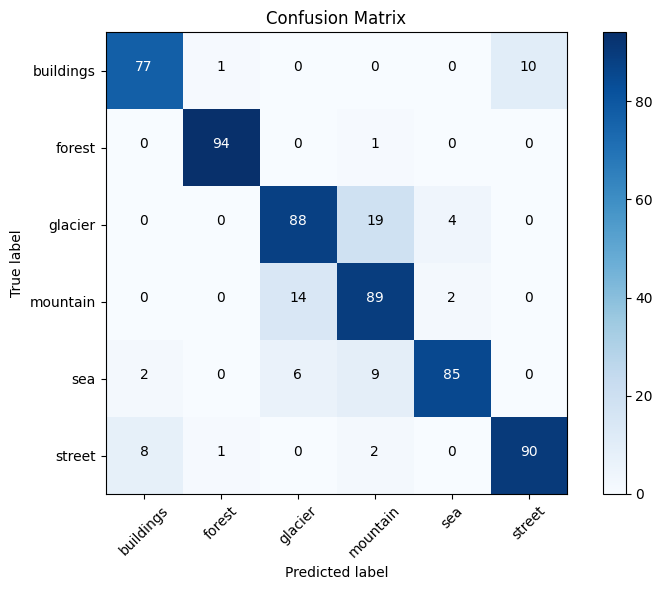

Classification Report:
               precision    recall  f1-score   support

   buildings       0.89      0.88      0.88        88
      forest       0.98      0.99      0.98        95
     glacier       0.81      0.79      0.80       111
    mountain       0.74      0.85      0.79       105
         sea       0.93      0.83      0.88       102
      street       0.90      0.89      0.90       101

    accuracy                           0.87       602
   macro avg       0.88      0.87      0.87       602
weighted avg       0.87      0.87      0.87       602



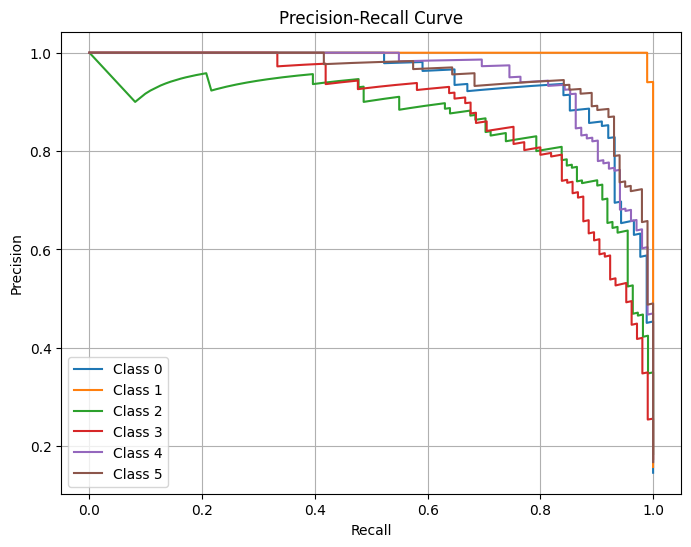

Testing with Dropout rate: 0.5
Training with Block 3 layers up to block3_conv1 unfrozen...
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 242ms/step - accuracy: 0.4967 - loss: 1.2716 - val_accuracy: 0.8106 - val_loss: 0.5532
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 213ms/step - accuracy: 0.8062 - loss: 0.5508 - val_accuracy: 0.8106 - val_loss: 0.4955
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 210ms/step - accuracy: 0.8360 - loss: 0.4655 - val_accuracy: 0.8455 - val_loss: 0.4100
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 206ms/step - accuracy: 0.8755 - loss: 0.3656 - val_accuracy: 0.8439 - val_loss: 0.4215
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 0.8966 - loss: 0.2898 - val_accuracy: 0.8588 - val_loss: 0.3886
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 206ms/step - accuracy: 0.9244 - loss: 0.2471 - val_accuracy: 0.8571 - val_loss: 0.3792
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 209ms/step - accuracy: 0.9356 - loss: 0.2234 - val_accuracy: 0.8605 - val_loss: 0.3753
Epoch 

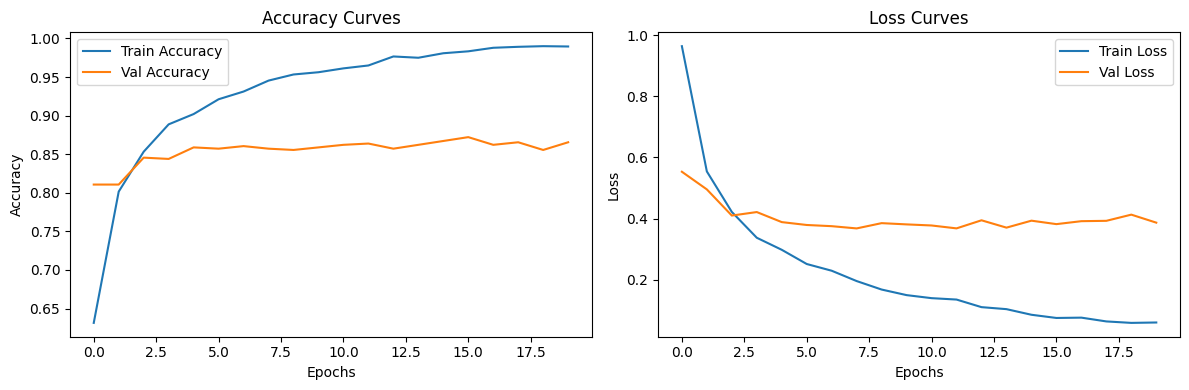

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step
Confusion Matrix:
 [[79  1  0  0  0  8]
 [ 0 94  0  1  0  0]
 [ 0  0 90 15  6  0]
 [ 0  0 13 88  4  0]
 [ 3  0  5  8 86  0]
 [13  2  0  1  1 84]]


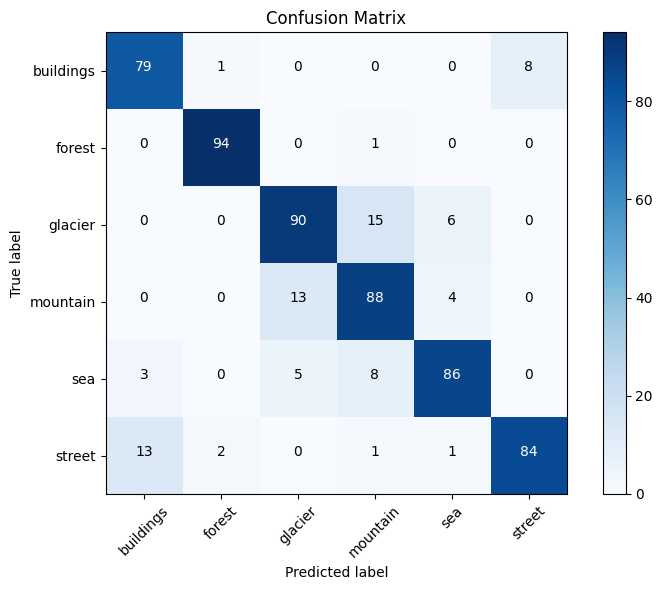

Classification Report:
               precision    recall  f1-score   support

   buildings       0.83      0.90      0.86        88
      forest       0.97      0.99      0.98        95
     glacier       0.83      0.81      0.82       111
    mountain       0.78      0.84      0.81       105
         sea       0.89      0.84      0.86       102
      street       0.91      0.83      0.87       101

    accuracy                           0.87       602
   macro avg       0.87      0.87      0.87       602
weighted avg       0.87      0.87      0.87       602



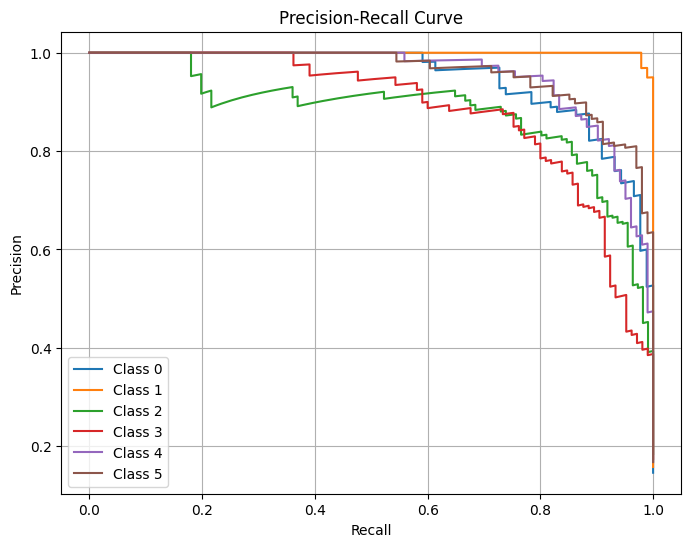

Training with Block 3 layers up to block3_conv2 unfrozen...
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 237ms/step - accuracy: 0.9809 - loss: 0.0734 - val_accuracy: 0.8605 - val_loss: 0.4032
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 214ms/step - accuracy: 0.9861 - loss: 0.0613 - val_accuracy: 0.8704 - val_loss: 0.3975
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 210ms/step - accuracy: 0.9875 - loss: 0.0505 - val_accuracy: 0.8605 - val_loss: 0.4200
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 206ms/step - accuracy: 0.9875 - loss: 0.0476 - val_accuracy: 0.8621 - val_loss: 0.4304
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 0.9906 - loss: 0.0387 - val_accuracy: 0.8654 - val_loss: 0.4326
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 0.9966 - loss: 0.0292 - val_accuracy: 0.8488 - val_loss: 0.4628
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step - accuracy: 0.9925 - loss: 0.0362 - val_accuracy: 0.8704 - val_loss: 0.4265
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━

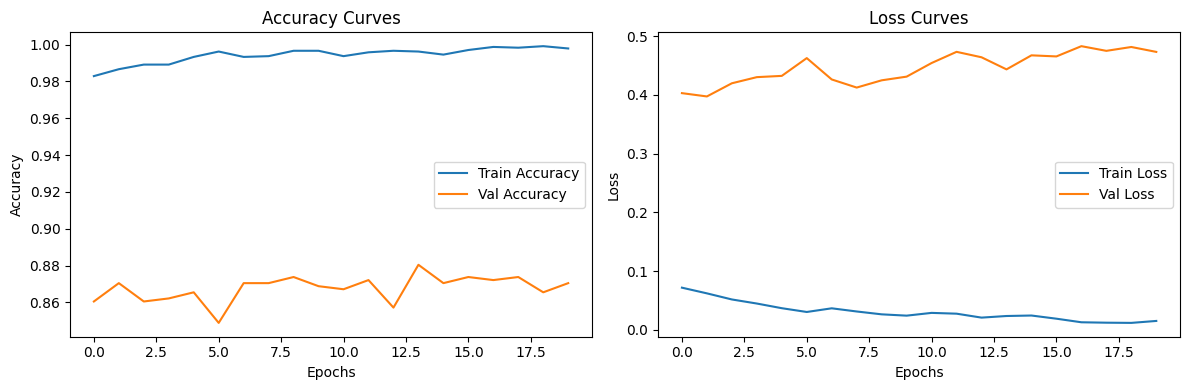

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step
Confusion Matrix:
 [[74  0  0  0  0 14]
 [ 0 93  0  1  0  1]
 [ 0  0 90 15  6  0]
 [ 0  0 14 87  4  0]
 [ 2  0  5  7 88  0]
 [ 7  0  0  1  1 92]]


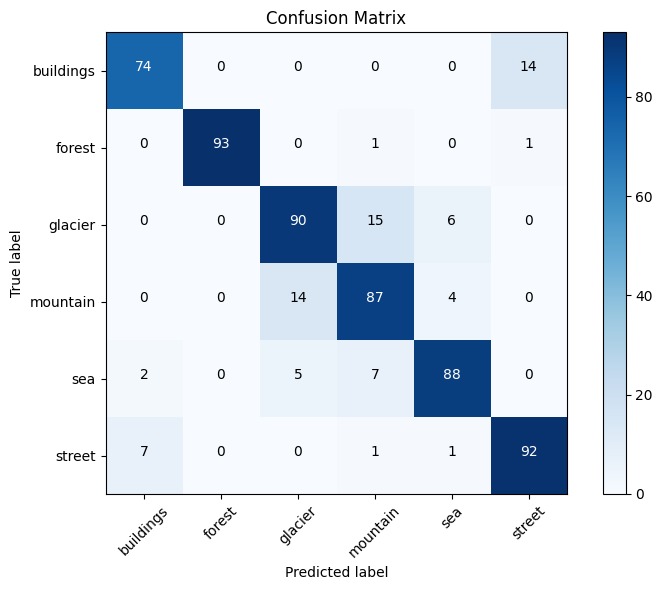

Classification Report:
               precision    recall  f1-score   support

   buildings       0.89      0.84      0.87        88
      forest       1.00      0.98      0.99        95
     glacier       0.83      0.81      0.82       111
    mountain       0.78      0.83      0.81       105
         sea       0.89      0.86      0.88       102
      street       0.86      0.91      0.88       101

    accuracy                           0.87       602
   macro avg       0.87      0.87      0.87       602
weighted avg       0.87      0.87      0.87       602



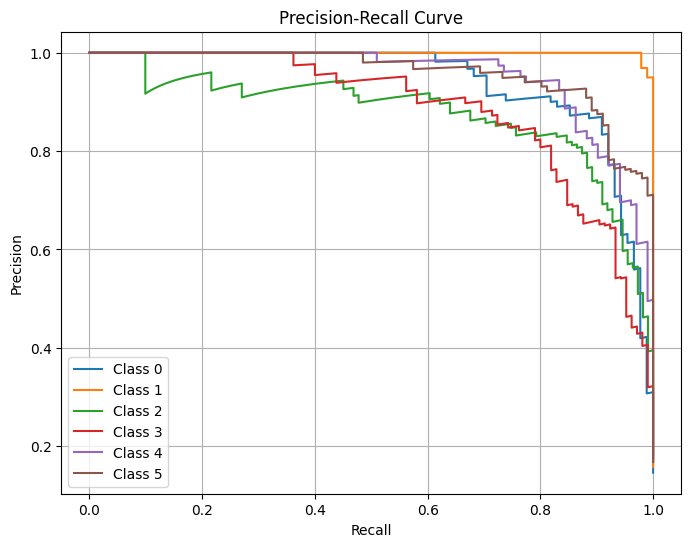

Training with Block 3 layers up to block3_conv3 unfrozen...
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 237ms/step - accuracy: 0.9955 - loss: 0.0208 - val_accuracy: 0.8704 - val_loss: 0.4978
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 214ms/step - accuracy: 0.9981 - loss: 0.0113 - val_accuracy: 0.8688 - val_loss: 0.5258
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 212ms/step - accuracy: 0.9994 - loss: 0.0104 - val_accuracy: 0.8754 - val_loss: 0.5062
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 206ms/step - accuracy: 0.9984 - loss: 0.0143 - val_accuracy: 0.8688 - val_loss: 0.5073
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 0.9981 - loss: 0.0131 - val_accuracy: 0.8588 - val_loss: 0.5437
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 0.9988 - loss: 0.0099 - val_accuracy: 0.8522 - val_loss: 0.5641
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step - accuracy: 0.9988 - loss: 0.0101 - val_accuracy: 0.8654 - val_loss: 0.5101
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━

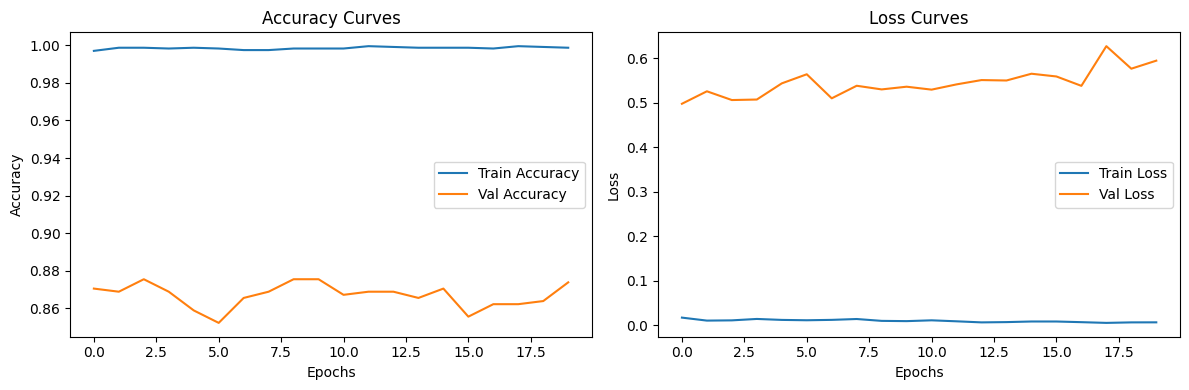

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step
Confusion Matrix:
 [[ 80   1   0   0   0   7]
 [  0  94   0   1   0   0]
 [  0   0 100   6   5   0]
 [  1   0  22  77   5   0]
 [  3   0   5   5  89   0]
 [ 11   2   0   0   2  86]]


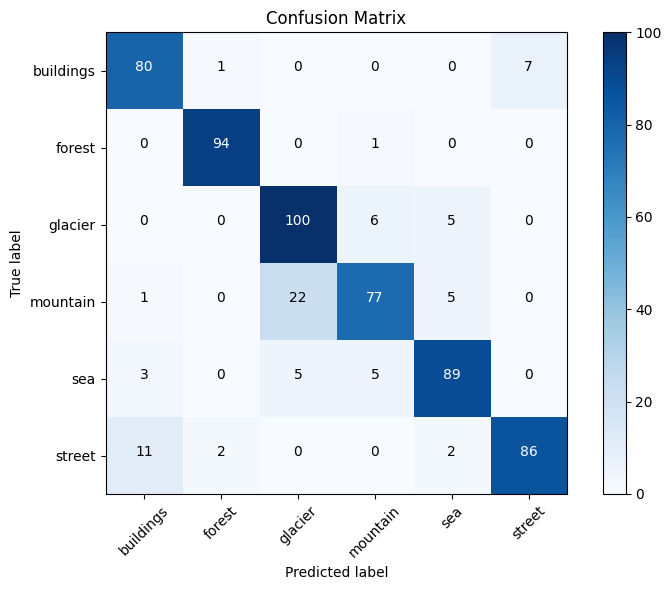

Classification Report:
               precision    recall  f1-score   support

   buildings       0.84      0.91      0.87        88
      forest       0.97      0.99      0.98        95
     glacier       0.79      0.90      0.84       111
    mountain       0.87      0.73      0.79       105
         sea       0.88      0.87      0.88       102
      street       0.92      0.85      0.89       101

    accuracy                           0.87       602
   macro avg       0.88      0.88      0.88       602
weighted avg       0.88      0.87      0.87       602



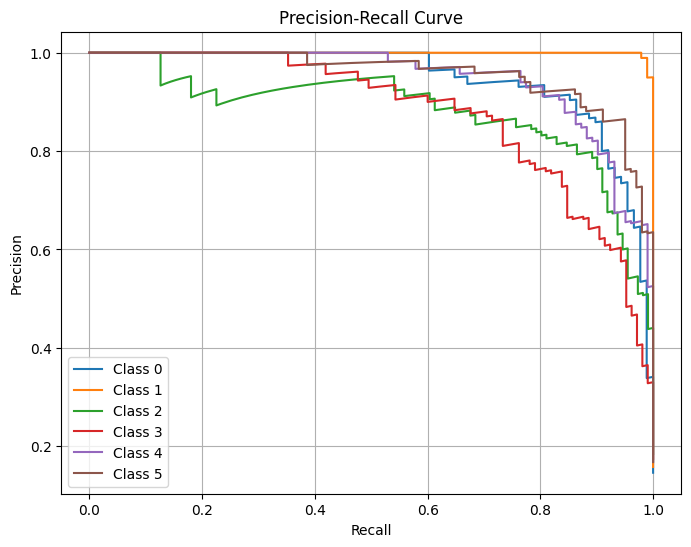

Training with Block 3 layers up to block3_pool unfrozen...
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 238ms/step - accuracy: 0.9966 - loss: 0.0089 - val_accuracy: 0.8638 - val_loss: 0.6098
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 212ms/step - accuracy: 0.9993 - loss: 0.0055 - val_accuracy: 0.8654 - val_loss: 0.5893
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 213ms/step - accuracy: 0.9999 - loss: 0.0044 - val_accuracy: 0.8605 - val_loss: 0.6327
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step - accuracy: 0.9993 - loss: 0.0062 - val_accuracy: 0.8704 - val_loss: 0.6043
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 0.9997 - loss: 0.0036 - val_accuracy: 0.8671 - val_loss: 0.5958
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 0.9989 - loss: 0.0054 - val_accuracy: 0.8638 - val_loss: 0.6040
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 206ms/step - accuracy: 0.9976 - loss: 0.0072 - val_accuracy: 0.8654 - val_loss: 0.6250
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 

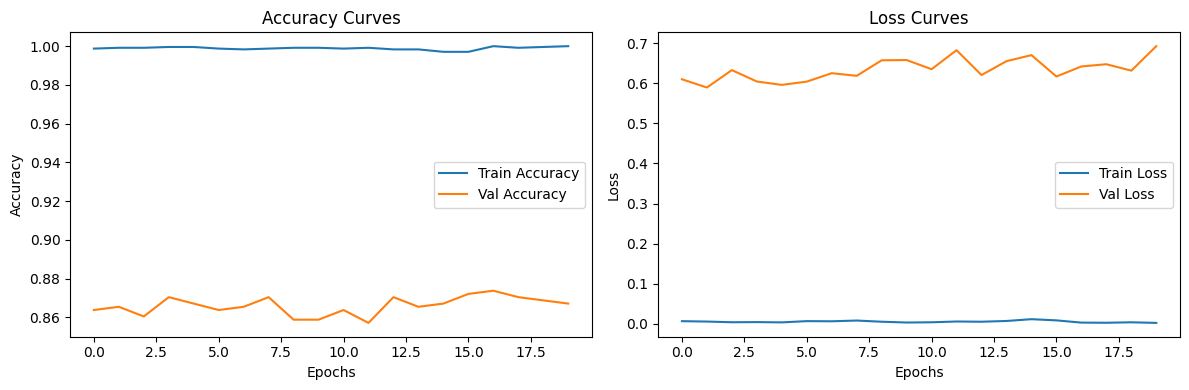

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step
Confusion Matrix:
 [[80  1  0  0  0  7]
 [ 0 94  0  1  0  0]
 [ 0  0 94 13  4  0]
 [ 0  0 19 83  3  0]
 [ 3  0  7  7 85  0]
 [11  2  0  1  1 86]]


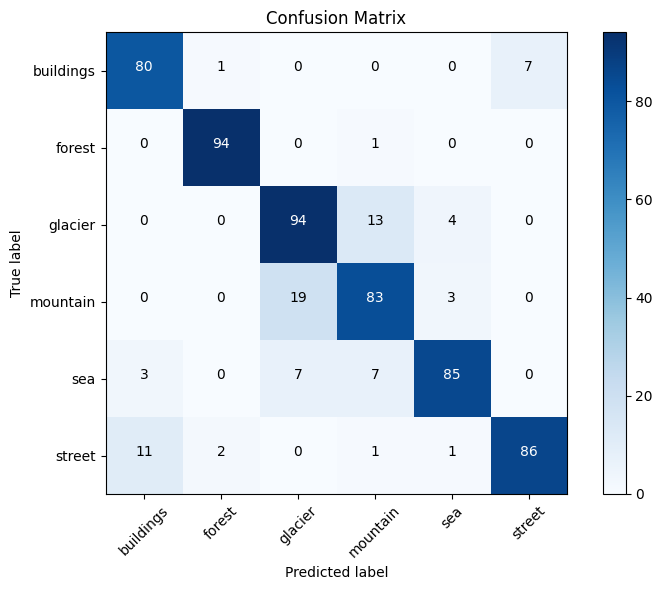

Classification Report:
               precision    recall  f1-score   support

   buildings       0.85      0.91      0.88        88
      forest       0.97      0.99      0.98        95
     glacier       0.78      0.85      0.81       111
    mountain       0.79      0.79      0.79       105
         sea       0.91      0.83      0.87       102
      street       0.92      0.85      0.89       101

    accuracy                           0.87       602
   macro avg       0.87      0.87      0.87       602
weighted avg       0.87      0.87      0.87       602



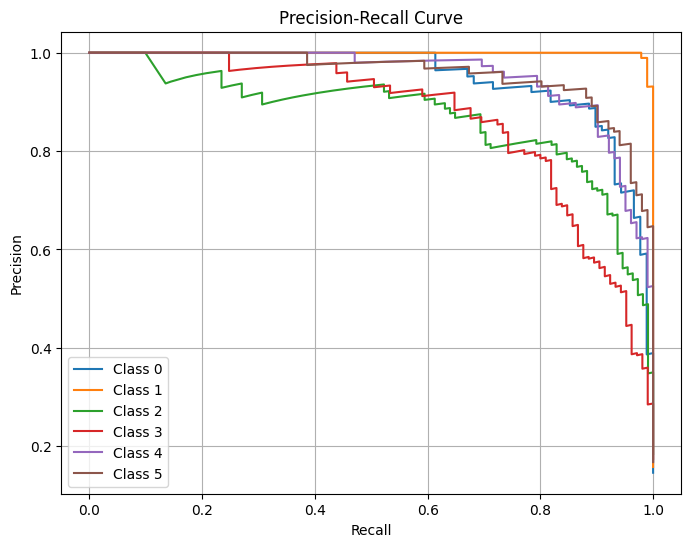

Testing with Dropout rate: 0.6
Training with Block 3 layers up to block3_conv1 unfrozen...
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 239ms/step - accuracy: 0.4525 - loss: 1.3755 - val_accuracy: 0.7824 - val_loss: 0.6240
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 213ms/step - accuracy: 0.7554 - loss: 0.6543 - val_accuracy: 0.8405 - val_loss: 0.4913
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 210ms/step - accuracy: 0.8239 - loss: 0.5351 - val_accuracy: 0.8339 - val_loss: 0.4737
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 0.8445 - loss: 0.4493 - val_accuracy: 0.8588 - val_loss: 0.4037
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 0.8700 - loss: 0.3809 - val_accuracy: 0.8571 - val_loss: 0.3933
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 0.8918 - loss: 0.3448 - val_accuracy: 0.8638 - val_loss: 0.3993
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step - accuracy: 0.8987 - loss: 0.3131 - val_accuracy: 0.8538 - val_loss: 0.3955
Epoch 

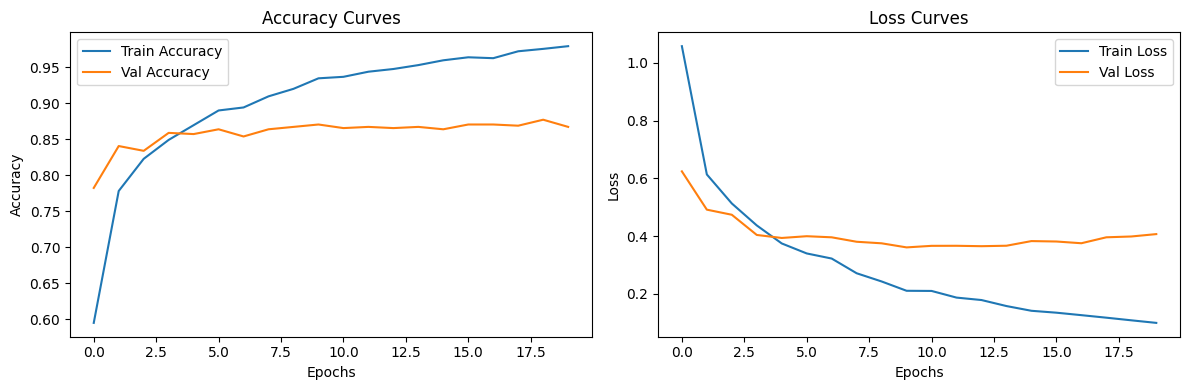

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step
Confusion Matrix:
 [[81  0  0  0  0  7]
 [ 0 94  0  1  0  0]
 [ 0  0 87 19  5  0]
 [ 0  0 12 92  1  0]
 [ 2  0  5 14 81  0]
 [12  0  0  2  0 87]]


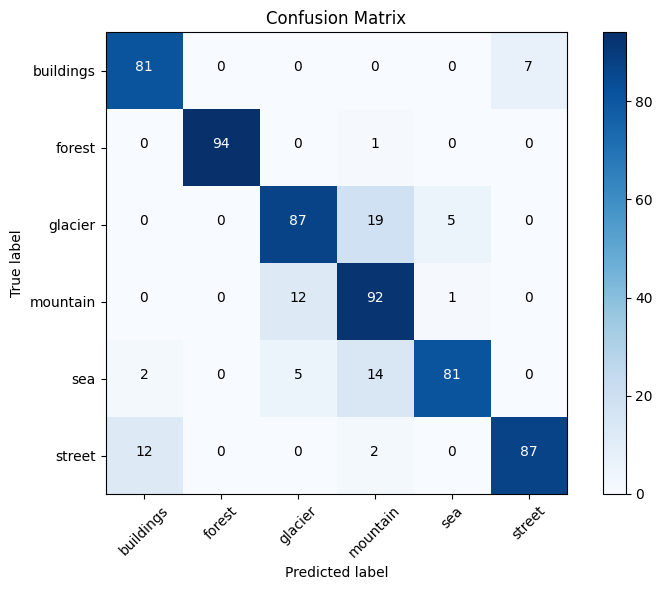

Classification Report:
               precision    recall  f1-score   support

   buildings       0.85      0.92      0.89        88
      forest       1.00      0.99      0.99        95
     glacier       0.84      0.78      0.81       111
    mountain       0.72      0.88      0.79       105
         sea       0.93      0.79      0.86       102
      street       0.93      0.86      0.89       101

    accuracy                           0.87       602
   macro avg       0.88      0.87      0.87       602
weighted avg       0.88      0.87      0.87       602



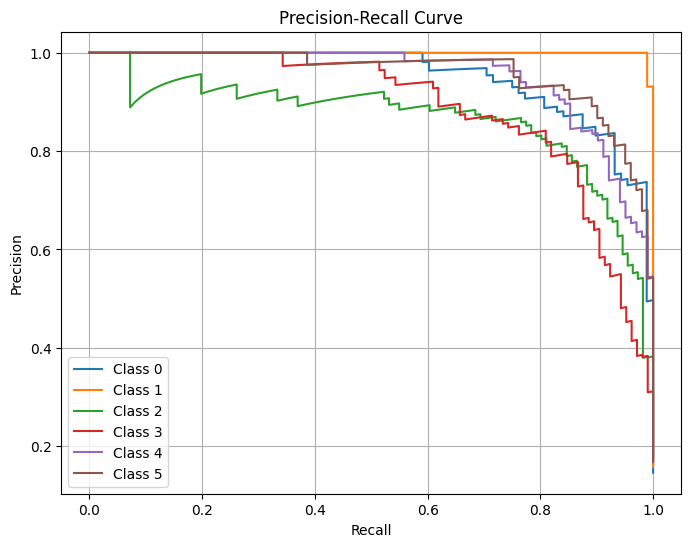

Training with Block 3 layers up to block3_conv2 unfrozen...
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 238ms/step - accuracy: 0.9764 - loss: 0.0994 - val_accuracy: 0.8787 - val_loss: 0.3899
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 211ms/step - accuracy: 0.9745 - loss: 0.0928 - val_accuracy: 0.8621 - val_loss: 0.3976
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 210ms/step - accuracy: 0.9734 - loss: 0.0894 - val_accuracy: 0.8704 - val_loss: 0.4091
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 206ms/step - accuracy: 0.9815 - loss: 0.0832 - val_accuracy: 0.8654 - val_loss: 0.4159
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 0.9793 - loss: 0.0685 - val_accuracy: 0.8671 - val_loss: 0.3974
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 0.9849 - loss: 0.0667 - val_accuracy: 0.8754 - val_loss: 0.3893
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 207ms/step - accuracy: 0.9863 - loss: 0.0613 - val_accuracy: 0.8738 - val_loss: 0.4053
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━

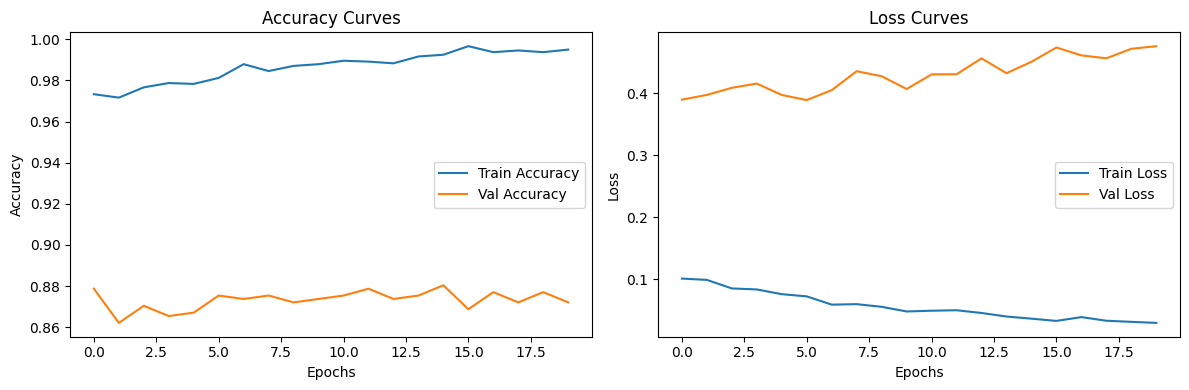

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step
Confusion Matrix:
 [[81  0  0  0  0  7]
 [ 0 94  0  1  0  0]
 [ 0  0 95 11  5  0]
 [ 0  0 18 84  3  0]
 [ 3  0  7  6 86  0]
 [13  1  0  1  1 85]]


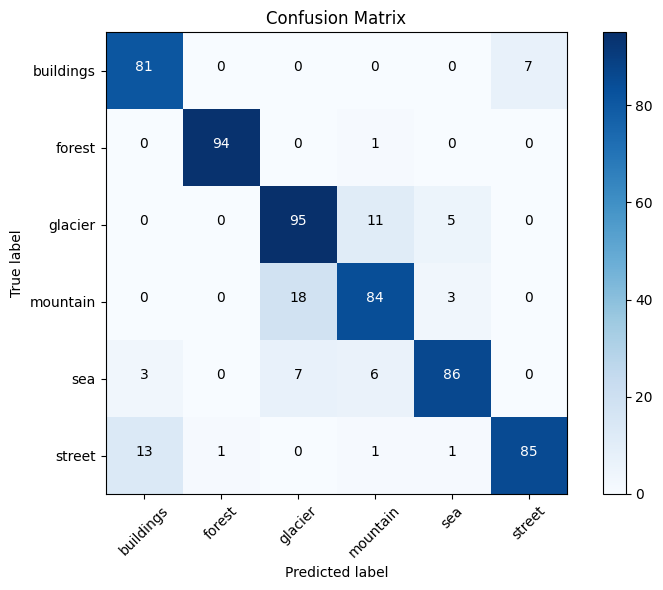

Classification Report:
               precision    recall  f1-score   support

   buildings       0.84      0.92      0.88        88
      forest       0.99      0.99      0.99        95
     glacier       0.79      0.86      0.82       111
    mountain       0.82      0.80      0.81       105
         sea       0.91      0.84      0.87       102
      street       0.92      0.84      0.88       101

    accuracy                           0.87       602
   macro avg       0.88      0.88      0.87       602
weighted avg       0.87      0.87      0.87       602



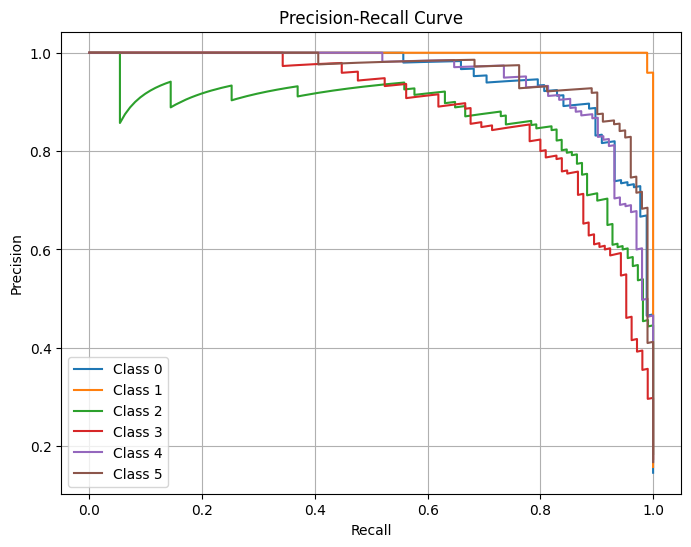

Training with Block 3 layers up to block3_conv3 unfrozen...
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 237ms/step - accuracy: 0.9930 - loss: 0.0265 - val_accuracy: 0.8654 - val_loss: 0.4919
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 209ms/step - accuracy: 0.9923 - loss: 0.0341 - val_accuracy: 0.8721 - val_loss: 0.4546
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 211ms/step - accuracy: 0.9922 - loss: 0.0328 - val_accuracy: 0.8704 - val_loss: 0.4772
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step - accuracy: 0.9925 - loss: 0.0309 - val_accuracy: 0.8704 - val_loss: 0.5010
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 0.9913 - loss: 0.0352 - val_accuracy: 0.8704 - val_loss: 0.5013
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 0.9966 - loss: 0.0200 - val_accuracy: 0.8721 - val_loss: 0.5112
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 206ms/step - accuracy: 0.9943 - loss: 0.0252 - val_accuracy: 0.8771 - val_loss: 0.5046
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━

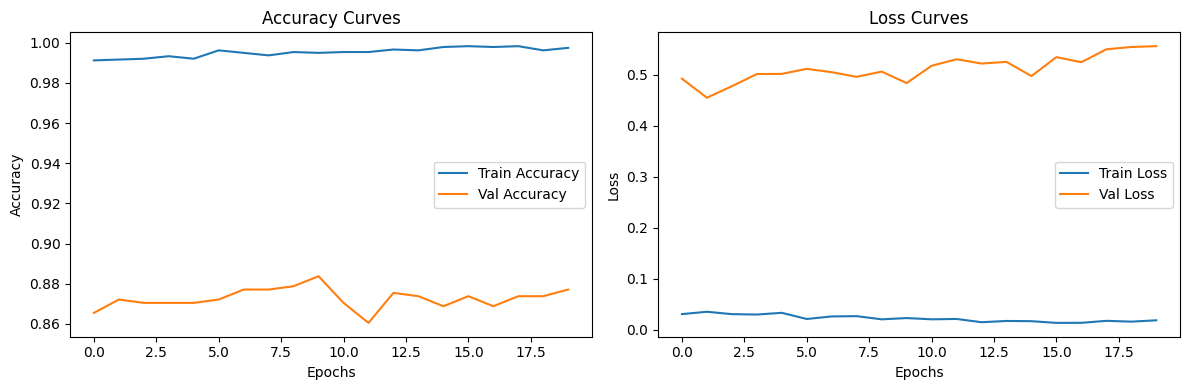

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step
Confusion Matrix:
 [[80  1  1  0  0  6]
 [ 0 93  0  1  1  0]
 [ 0  0 95 11  5  0]
 [ 0  0 14 86  5  0]
 [ 1  0  6  7 88  0]
 [12  1  0  2  0 86]]


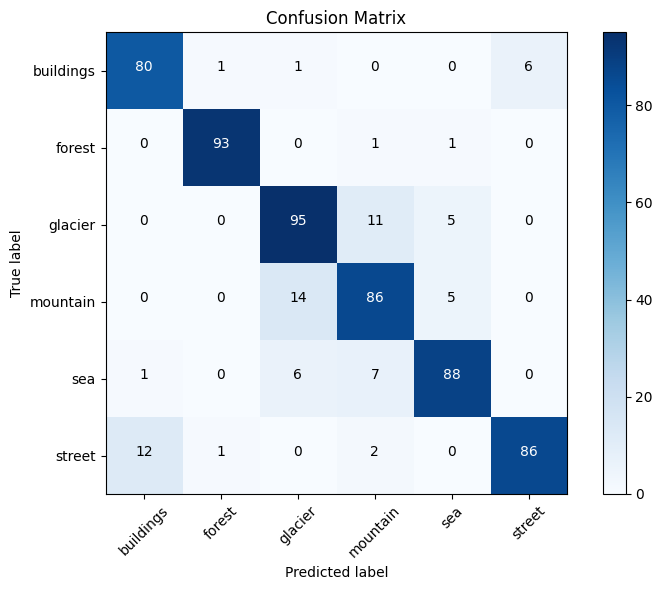

Classification Report:
               precision    recall  f1-score   support

   buildings       0.86      0.91      0.88        88
      forest       0.98      0.98      0.98        95
     glacier       0.82      0.86      0.84       111
    mountain       0.80      0.82      0.81       105
         sea       0.89      0.86      0.88       102
      street       0.93      0.85      0.89       101

    accuracy                           0.88       602
   macro avg       0.88      0.88      0.88       602
weighted avg       0.88      0.88      0.88       602



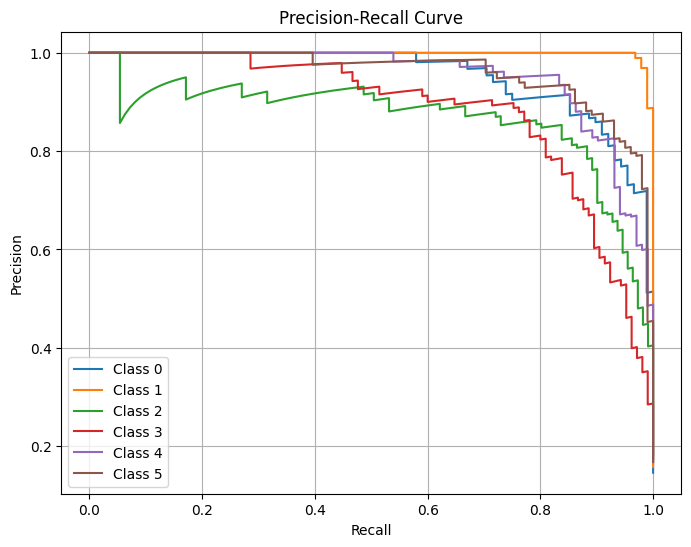

Training with Block 3 layers up to block3_pool unfrozen...
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 238ms/step - accuracy: 0.9951 - loss: 0.0171 - val_accuracy: 0.8721 - val_loss: 0.5480
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 211ms/step - accuracy: 0.9918 - loss: 0.0256 - val_accuracy: 0.8821 - val_loss: 0.5442
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 212ms/step - accuracy: 0.9982 - loss: 0.0129 - val_accuracy: 0.8721 - val_loss: 0.5712
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step - accuracy: 0.9980 - loss: 0.0135 - val_accuracy: 0.8738 - val_loss: 0.5462
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 0.9955 - loss: 0.0167 - val_accuracy: 0.8738 - val_loss: 0.5737
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 0.9981 - loss: 0.0100 - val_accuracy: 0.8688 - val_loss: 0.6078
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 0.9942 - loss: 0.0198 - val_accuracy: 0.8738 - val_loss: 0.5840
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 

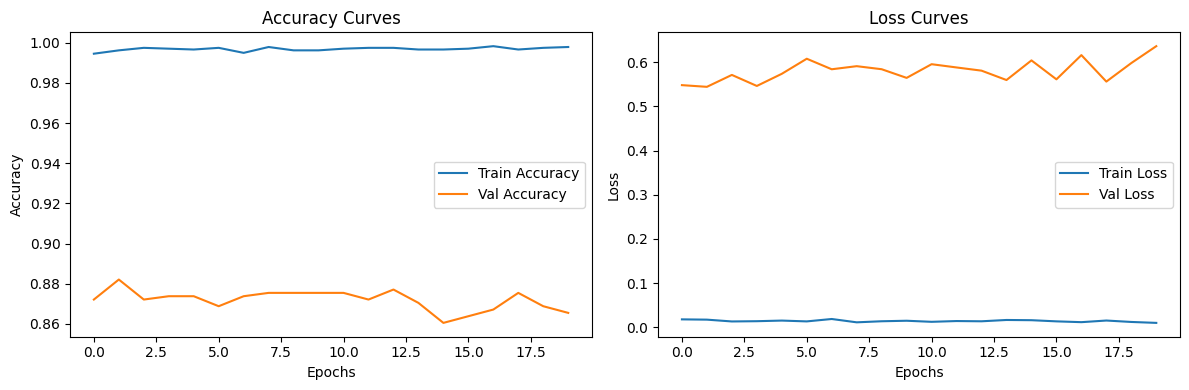

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step
Confusion Matrix:
 [[80  1  0  0  0  7]
 [ 0 94  0  1  0  0]
 [ 0  0 88 18  5  0]
 [ 0  0 14 89  2  0]
 [ 2  0  6 10 84  0]
 [11  2  0  2  0 86]]


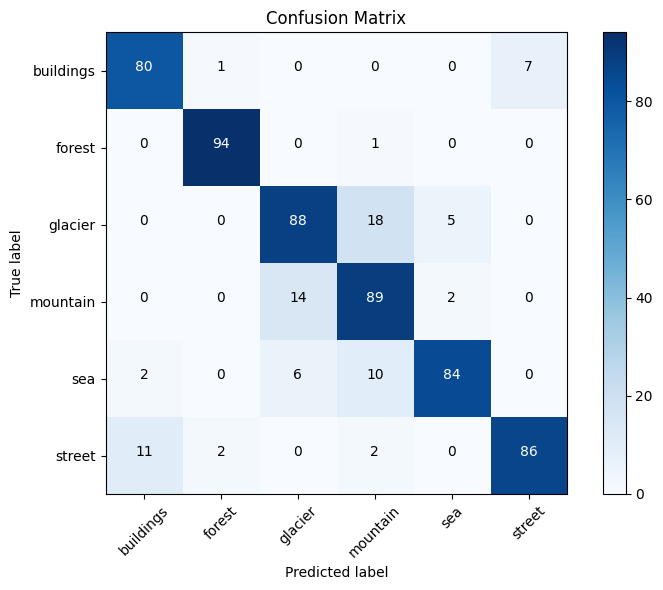

Classification Report:
               precision    recall  f1-score   support

   buildings       0.86      0.91      0.88        88
      forest       0.97      0.99      0.98        95
     glacier       0.81      0.79      0.80       111
    mountain       0.74      0.85      0.79       105
         sea       0.92      0.82      0.87       102
      street       0.92      0.85      0.89       101

    accuracy                           0.87       602
   macro avg       0.87      0.87      0.87       602
weighted avg       0.87      0.87      0.87       602



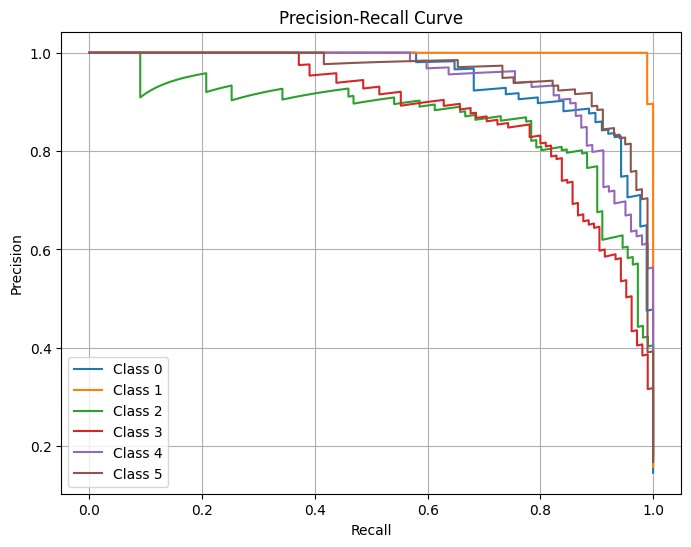

Testing with Dropout rate: 0.7000000000000001
Training with Block 3 layers up to block3_conv1 unfrozen...
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 248ms/step - accuracy: 0.3946 - loss: 1.6276 - val_accuracy: 0.7641 - val_loss: 0.6714
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 216ms/step - accuracy: 0.7040 - loss: 0.7745 - val_accuracy: 0.8140 - val_loss: 0.5347
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 213ms/step - accuracy: 0.7577 - loss: 0.6343 - val_accuracy: 0.8173 - val_loss: 0.4857
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 206ms/step - accuracy: 0.7875 - loss: 0.5606 - val_accuracy: 0.8289 - val_loss: 0.4383
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 0.8153 - loss: 0.5298 - val_accuracy: 0.8422 - val_loss: 0.4194
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 0.8473 - loss: 0.4524 - val_accuracy: 0.8505 - val_loss: 0.4081
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 210ms/step - accuracy: 0.8541 - loss: 0.4222 - val_accuracy: 0.8472 - val_loss

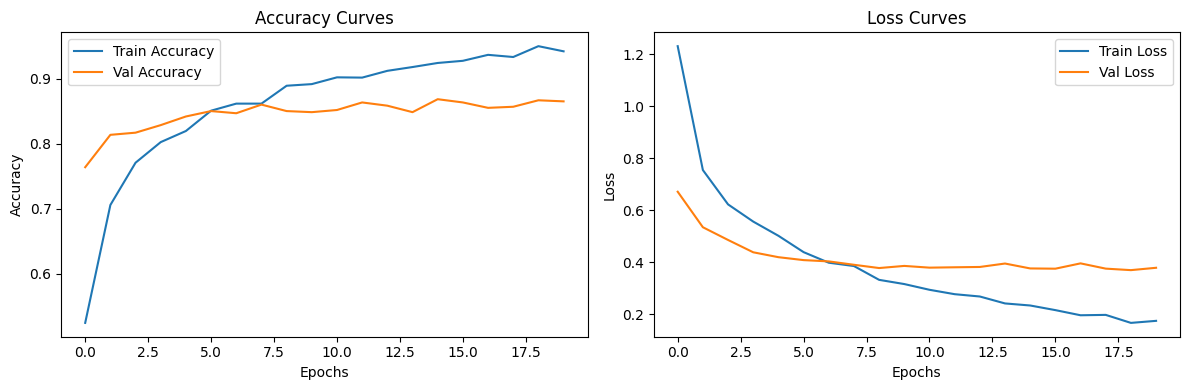

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step
Confusion Matrix:
 [[78  1  0  0  0  9]
 [ 0 94  0  1  0  0]
 [ 0  0 92 16  3  0]
 [ 0  0 16 85  4  0]
 [ 4  0  6  8 84  0]
 [10  1  0  1  1 88]]


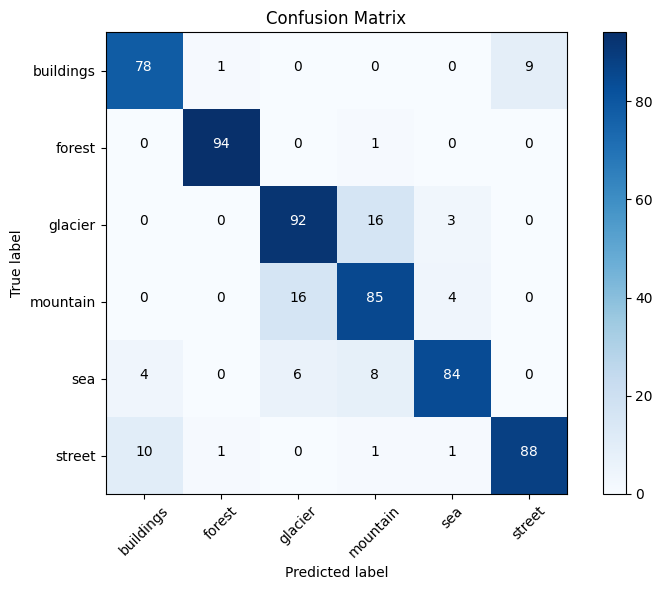

Classification Report:
               precision    recall  f1-score   support

   buildings       0.85      0.89      0.87        88
      forest       0.98      0.99      0.98        95
     glacier       0.81      0.83      0.82       111
    mountain       0.77      0.81      0.79       105
         sea       0.91      0.82      0.87       102
      street       0.91      0.87      0.89       101

    accuracy                           0.87       602
   macro avg       0.87      0.87      0.87       602
weighted avg       0.87      0.87      0.87       602



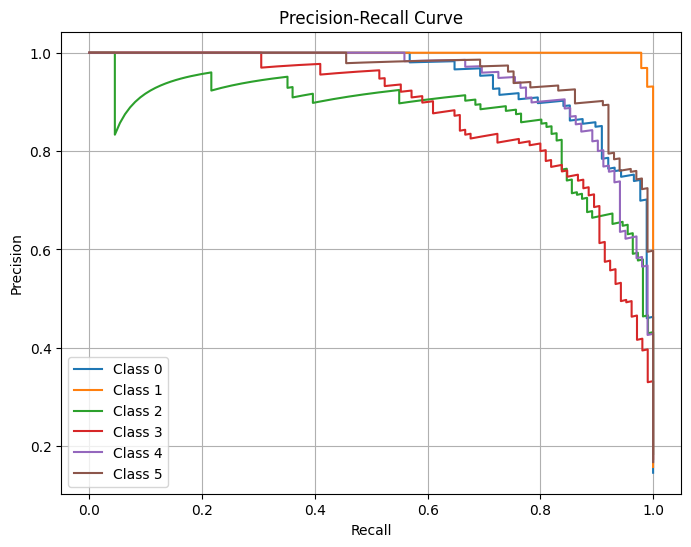

Training with Block 3 layers up to block3_conv2 unfrozen...
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 239ms/step - accuracy: 0.9449 - loss: 0.1670 - val_accuracy: 0.8621 - val_loss: 0.3871
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 213ms/step - accuracy: 0.9472 - loss: 0.1708 - val_accuracy: 0.8621 - val_loss: 0.4148
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 213ms/step - accuracy: 0.9500 - loss: 0.1620 - val_accuracy: 0.8721 - val_loss: 0.3857
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 209ms/step - accuracy: 0.9504 - loss: 0.1377 - val_accuracy: 0.8738 - val_loss: 0.3946
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 0.9588 - loss: 0.1384 - val_accuracy: 0.8704 - val_loss: 0.3940
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 0.9550 - loss: 0.1270 - val_accuracy: 0.8439 - val_loss: 0.4250
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 206ms/step - accuracy: 0.9620 - loss: 0.1263 - val_accuracy: 0.8654 - val_loss: 0.4150
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━

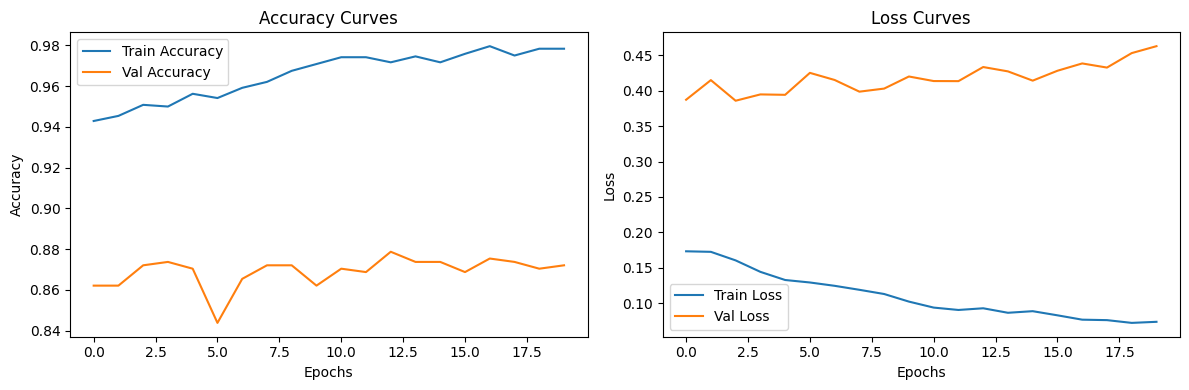

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step
Confusion Matrix:
 [[77  1  0  0  0 10]
 [ 0 94  0  1  0  0]
 [ 0  0 94 13  4  0]
 [ 0  0 16 87  2  0]
 [ 2  0  8  7 85  0]
 [ 9  2  0  2  0 88]]


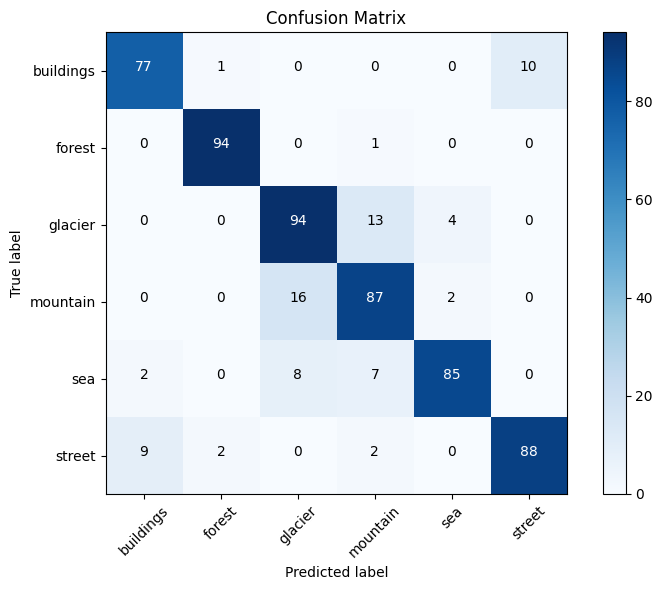

Classification Report:
               precision    recall  f1-score   support

   buildings       0.88      0.88      0.88        88
      forest       0.97      0.99      0.98        95
     glacier       0.80      0.85      0.82       111
    mountain       0.79      0.83      0.81       105
         sea       0.93      0.83      0.88       102
      street       0.90      0.87      0.88       101

    accuracy                           0.87       602
   macro avg       0.88      0.87      0.87       602
weighted avg       0.87      0.87      0.87       602



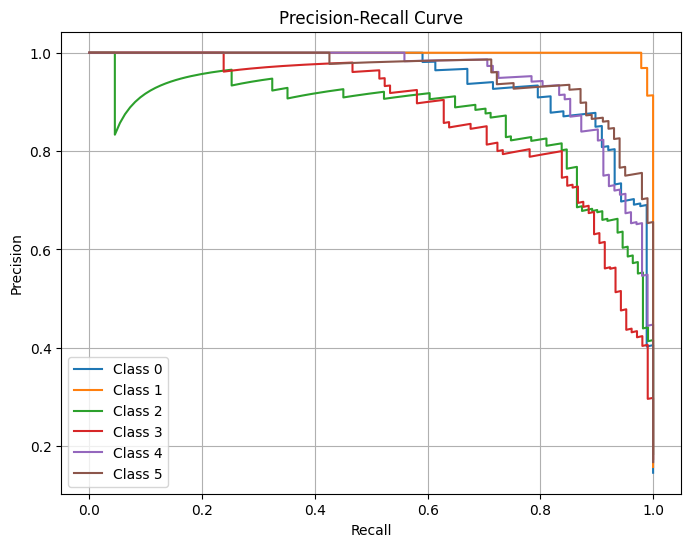

Training with Block 3 layers up to block3_conv3 unfrozen...
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 240ms/step - accuracy: 0.9757 - loss: 0.0760 - val_accuracy: 0.8671 - val_loss: 0.4839
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 216ms/step - accuracy: 0.9829 - loss: 0.0658 - val_accuracy: 0.8704 - val_loss: 0.4607
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 211ms/step - accuracy: 0.9844 - loss: 0.0643 - val_accuracy: 0.8771 - val_loss: 0.4513
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 0.9798 - loss: 0.0686 - val_accuracy: 0.8738 - val_loss: 0.4681
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 0.9842 - loss: 0.0601 - val_accuracy: 0.8704 - val_loss: 0.4782
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step - accuracy: 0.9830 - loss: 0.0602 - val_accuracy: 0.8738 - val_loss: 0.4889
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 210ms/step - accuracy: 0.9858 - loss: 0.0607 - val_accuracy: 0.8671 - val_loss: 0.4766
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━

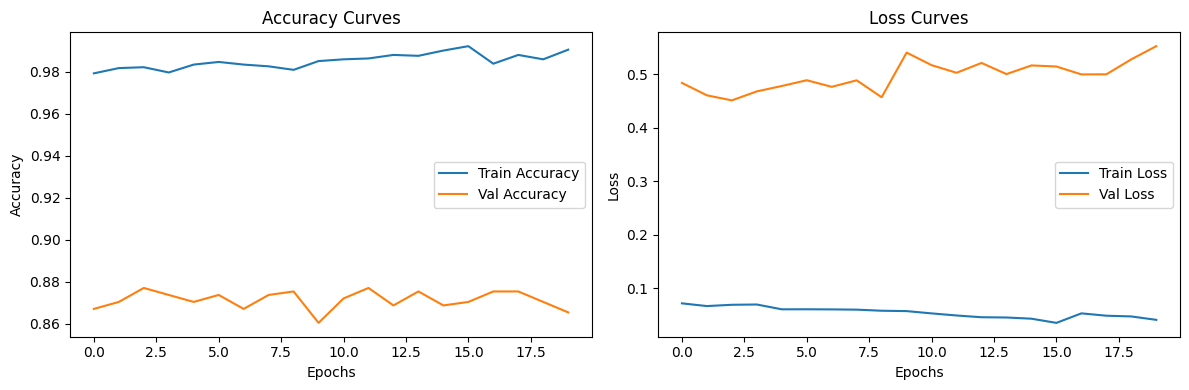

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step
Confusion Matrix:
 [[80  1  0  0  0  7]
 [ 0 94  0  1  0  0]
 [ 0  0 96 12  3  0]
 [ 0  0 19 83  3  0]
 [ 3  0  9  7 83  0]
 [13  1  0  1  1 85]]


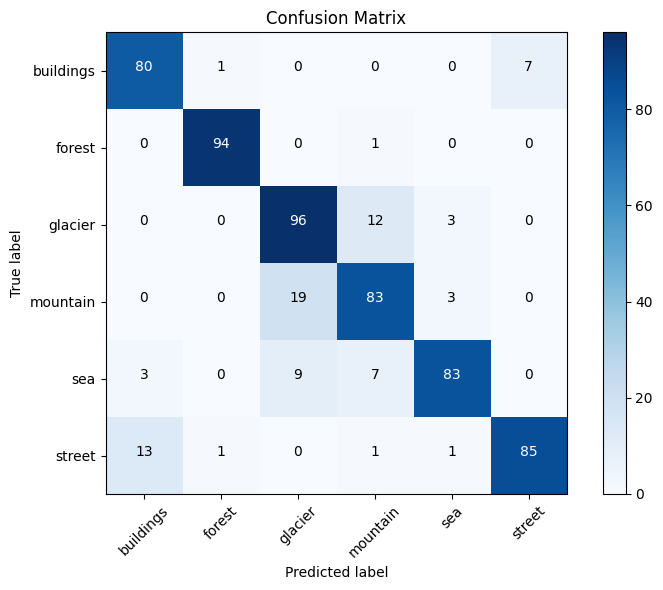

Classification Report:
               precision    recall  f1-score   support

   buildings       0.83      0.91      0.87        88
      forest       0.98      0.99      0.98        95
     glacier       0.77      0.86      0.82       111
    mountain       0.80      0.79      0.79       105
         sea       0.92      0.81      0.86       102
      street       0.92      0.84      0.88       101

    accuracy                           0.87       602
   macro avg       0.87      0.87      0.87       602
weighted avg       0.87      0.87      0.87       602



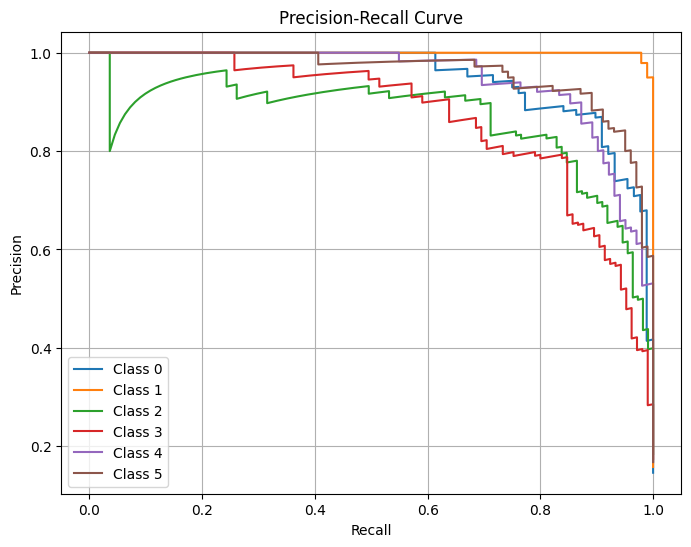

Training with Block 3 layers up to block3_pool unfrozen...
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 240ms/step - accuracy: 0.9821 - loss: 0.0477 - val_accuracy: 0.8738 - val_loss: 0.5281
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 212ms/step - accuracy: 0.9893 - loss: 0.0380 - val_accuracy: 0.8754 - val_loss: 0.5236
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 212ms/step - accuracy: 0.9906 - loss: 0.0410 - val_accuracy: 0.8804 - val_loss: 0.5131
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 207ms/step - accuracy: 0.9940 - loss: 0.0323 - val_accuracy: 0.8671 - val_loss: 0.5570
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 0.9837 - loss: 0.0486 - val_accuracy: 0.8605 - val_loss: 0.5537
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 206ms/step - accuracy: 0.9869 - loss: 0.0460 - val_accuracy: 0.8738 - val_loss: 0.5766
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 209ms/step - accuracy: 0.9930 - loss: 0.0296 - val_accuracy: 0.8671 - val_loss: 0.5681
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 

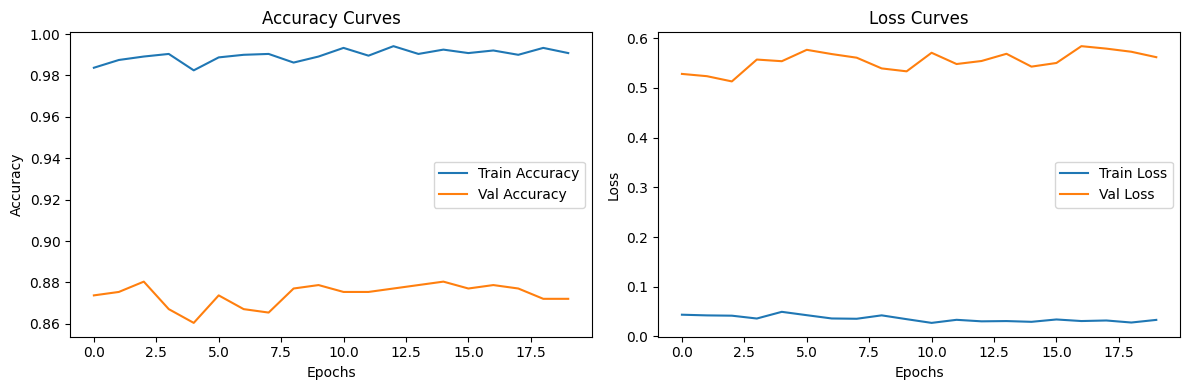

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step
Confusion Matrix:
 [[79  1  0  0  0  8]
 [ 0 94  0  1  0  0]
 [ 0  0 92 14  5  0]
 [ 0  0 15 86  4  0]
 [ 4  0  6  8 84  0]
 [ 8  1  0  1  1 90]]


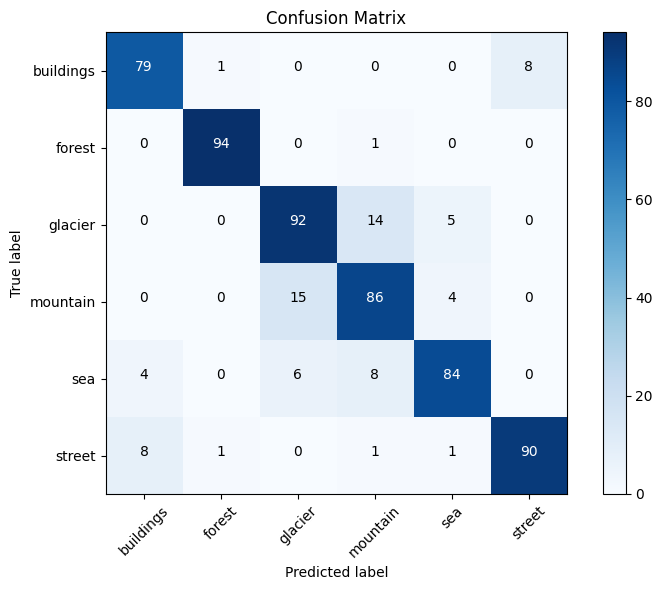

Classification Report:
               precision    recall  f1-score   support

   buildings       0.87      0.90      0.88        88
      forest       0.98      0.99      0.98        95
     glacier       0.81      0.83      0.82       111
    mountain       0.78      0.82      0.80       105
         sea       0.89      0.82      0.86       102
      street       0.92      0.89      0.90       101

    accuracy                           0.87       602
   macro avg       0.88      0.87      0.88       602
weighted avg       0.87      0.87      0.87       602



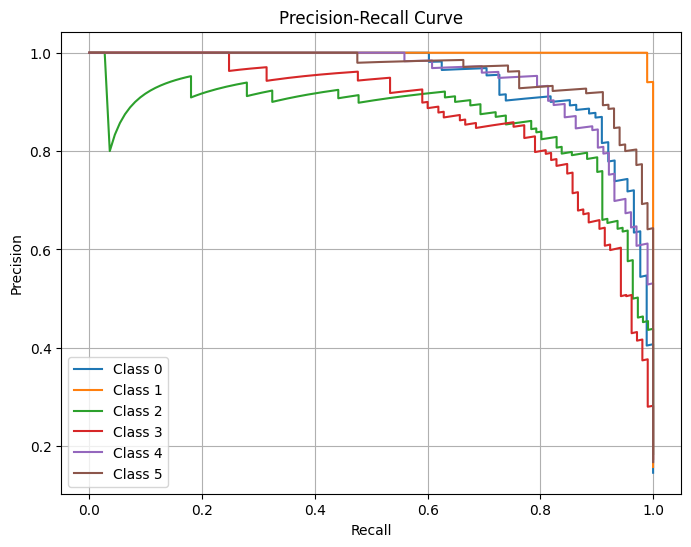

Model training and evaluation with Dropout complete.


In [18]:
run_test_harness()

In [ ]:
datagen = ImageDataGenerator(
        rescale=1.0 / 255.0,
        rotation_range=20,      
        width_shift_range=0.2,  
        height_shift_range=0.2, 
         
    )

In [19]:

# Define the model using VGG16
def define_model(num_classes):
    # Load the pre-trained VGG16 model without the top classifier layer
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze the convolutional base
    for layer in base_model.layers:
        layer.trainable = False

    # Build the model
    model = Sequential()
    model.add(base_model)

    # Add custom classification head with Dropout
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.6))  # Add Dropout after the dense layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [20]:
def run_test_harness():
    # Prepare data generators
    datagen = ImageDataGenerator(
        rescale=1.0 / 255.0,
        rotation_range=20,      
        width_shift_range=0.1,  
        height_shift_range=0.1    
    )

    # Train and test directories
    train_dir = 'split_dataset/train'
    test_dir = 'split_dataset/test'

    # Prepare iterators for training and testing datasets
    train_it = datagen.flow_from_directory(
        train_dir,
        batch_size=32,
        target_size=(224, 224),
        class_mode='categorical',  # Multi-class classification
        shuffle=True
    )

    test_it = datagen.flow_from_directory(
        test_dir,
        batch_size=32,
        target_size=(224, 224),
        class_mode='categorical',
        shuffle=False
    )

    # Define the model
    num_classes = len(train_it.class_indices)  # Number of classes
    model = define_model(num_classes)  # Make sure this function is defined elsewhere

    # Get the layers for the VGG16 blocks
    base_model = model.layers[0]  # VGG16 base model
    blocks = [
        base_model.get_layer('block3_conv3'),  # 3rd block   
    ]

    # Training loop: progressively unfreeze blocks
    for i in range(len(blocks)):
        # Unfreeze the current block and freeze previous blocks
        for layer in base_model.layers:
            layer.trainable = False
        for j in range(i, len(blocks)):
            blocks[j].trainable = True

        # Recompile the model after unfreezing layers
        model.compile(optimizer=Adam(learning_rate=0.0001), 
                      loss='categorical_crossentropy', metrics=['accuracy'])

        # Train the model
        #print(f"Training with block {5 - i} unfrozen...")
        history = model.fit(
            train_it,
            validation_data=test_it,
            epochs=20
        )

        # Plot accuracy and loss curves for comparison
        plot_curves(history)

        # Evaluate model on test data
        test_steps = len(test_it)
        y_probs = model.predict(test_it, steps=test_steps, verbose=1)
        y_pred = np.argmax(y_probs, axis=1)
        y_true = test_it.classes

        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        print("Confusion Matrix:\n", cm)

        # Plot Confusion Matrix
        class_names = list(test_it.class_indices.keys())
        plot_confusion_matrix(cm, class_names)

        # Classification Report
        report = classification_report(y_true, y_pred, target_names=class_names)
        print("Classification Report:\n", report)

        # One-hot encode y_true
        y_true_one_hot = np.zeros((len(y_true), num_classes))
        y_true_one_hot[np.arange(len(y_true)), y_true] = 1

        # Precision-Recall Curves
        plot_pr_curve(y_true_one_hot, y_probs, num_classes)

        # Save Confusion Matrix to CSV
        cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
        cm_df.to_csv(f'confusion_matrix_block_{5 - i}.csv', index=True)

        # Save classification report
        report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
        report_df = pd.DataFrame(report_dict).transpose()
        report_df.to_csv(f'classification_report_block_{5 - i}.csv', index=True)

    print("Model training and evaluation complete.")



Found 2398 images belonging to 6 classes.
Found 602 images belonging to 6 classes.
Training with block 5 unfrozen...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 51s 511ms/step - accuracy: 0.4112 - loss: 1.5093 - val_accuracy: 0.7525 - val_loss: 0.6570
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 377ms/step - accuracy: 0.7397 - loss: 0.7363 - val_accuracy: 0.7874 - val_loss: 0.5176
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 385ms/step - accuracy: 0.7774 - loss: 0.5928 - val_accuracy: 0.8073 - val_loss: 0.4626
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 382ms/step - accuracy: 0.8141 - loss: 0.5294 - val_accuracy: 0.8040 - val_loss: 0.4432
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 381ms/step - accuracy: 0.8414 - loss: 0.4675 - val_accuracy: 0.8372 - val_loss: 0.4895
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 384ms/step - accuracy: 0.8443 - loss: 0.4585 - val_accuracy: 0.8555 - val_loss: 0.3845
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 385ms/step - accuracy: 0.8599 - loss: 0.4294 - val_accuracy: 0.8571 - val_loss: 0.3798
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 381ms/step - accuracy: 0.8605 - loss: 0.3749 - val_accuracy: 0.868

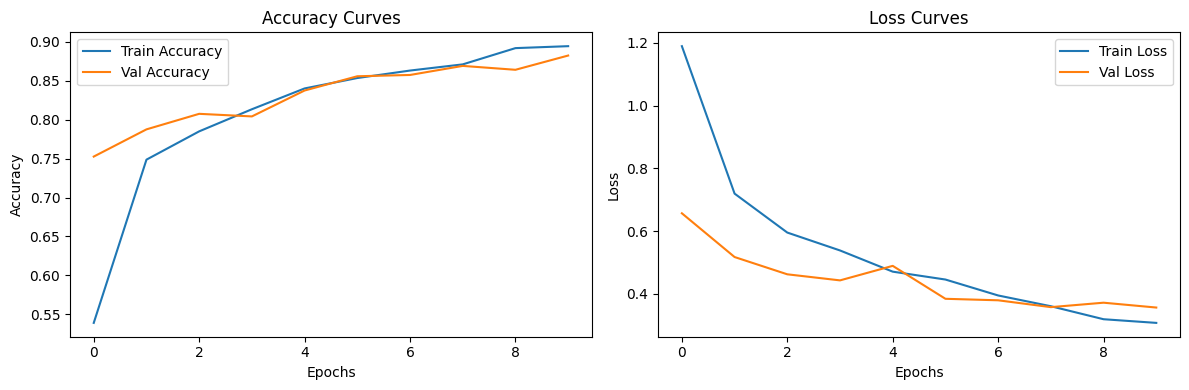

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 303ms/step
Confusion Matrix:
 [[81  1  0  0  0  6]
 [ 0 94  0  1  0  0]
 [ 1  0 90 12  8  0]
 [ 0  0 12 90  3  0]
 [ 2  0  1  5 94  0]
 [10  1  0  1  1 88]]


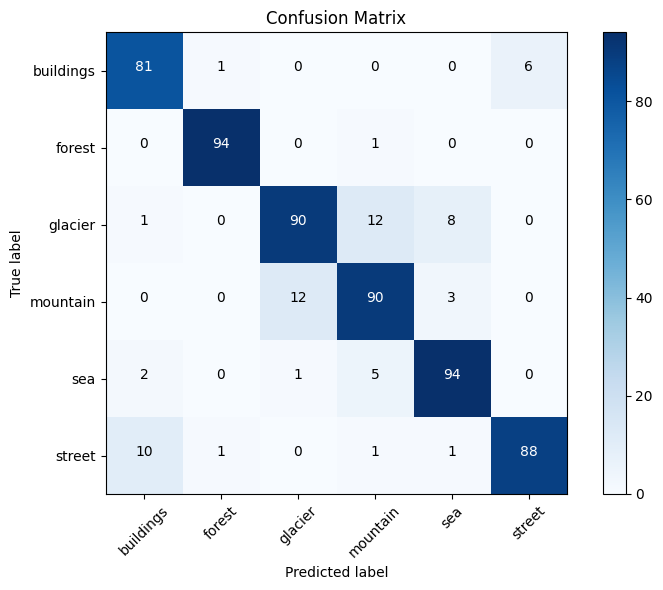

Classification Report:
               precision    recall  f1-score   support

   buildings       0.86      0.92      0.89        88
      forest       0.98      0.99      0.98        95
     glacier       0.87      0.81      0.84       111
    mountain       0.83      0.86      0.84       105
         sea       0.89      0.92      0.90       102
      street       0.94      0.87      0.90       101

    accuracy                           0.89       602
   macro avg       0.89      0.90      0.89       602
weighted avg       0.89      0.89      0.89       602



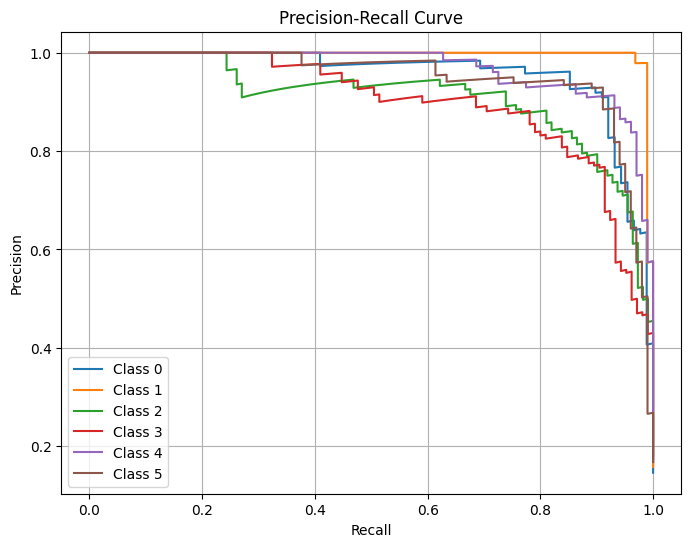

Model training and evaluation complete.


In [21]:
run_test_harness()

In [22]:
def run_test_harness():
    # Prepare data generators
    datagen = ImageDataGenerator(
        rescale=1.0 / 255.0,
        rotation_range=20,      
        width_shift_range=0.1,  
        height_shift_range=0.1    
    )

    # Train and test directories
    train_dir = 'split_dataset/train'
    test_dir = 'split_dataset/test'

    # Prepare iterators for training and testing datasets
    train_it = datagen.flow_from_directory(
        train_dir,
        batch_size=32,
        target_size=(224, 224),
        class_mode='categorical',  # Multi-class classification
        shuffle=True
    )

    test_it = datagen.flow_from_directory(
        test_dir,
        batch_size=32,
        target_size=(224, 224),
        class_mode='categorical',
        shuffle=False
    )

    # Define the model
    num_classes = len(train_it.class_indices)  # Number of classes
    model = define_model(num_classes)  # Make sure this function is defined elsewhere

    # Get the layers for the VGG16 blocks
    base_model = model.layers[0]  # VGG16 base model
    blocks = [
        base_model.get_layer('block3_conv3'),  # 3rd block   
    ]

    # Training loop: progressively unfreeze blocks
    for i in range(len(blocks)):
        # Unfreeze the current block and freeze previous blocks
        for layer in base_model.layers:
            layer.trainable = False
        for j in range(i, len(blocks)):
            blocks[j].trainable = True

        # Recompile the model after unfreezing layers
        model.compile(optimizer=Adam(learning_rate=0.0001), 
                      loss='categorical_crossentropy', metrics=['accuracy'])

        # Train the model
        #print(f"Training with block {5 - i} unfrozen...")
        history = model.fit(
            train_it,
            validation_data=test_it,
            epochs=40
        )

        # Plot accuracy and loss curves for comparison
        plot_curves(history)

        # Evaluate model on test data
        test_steps = len(test_it)
        y_probs = model.predict(test_it, steps=test_steps, verbose=1)
        y_pred = np.argmax(y_probs, axis=1)
        y_true = test_it.classes

        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        print("Confusion Matrix:\n", cm)

        # Plot Confusion Matrix
        class_names = list(test_it.class_indices.keys())
        plot_confusion_matrix(cm, class_names)

        # Classification Report
        report = classification_report(y_true, y_pred, target_names=class_names)
        print("Classification Report:\n", report)

        # One-hot encode y_true
        y_true_one_hot = np.zeros((len(y_true), num_classes))
        y_true_one_hot[np.arange(len(y_true)), y_true] = 1

        # Precision-Recall Curves
        plot_pr_curve(y_true_one_hot, y_probs, num_classes)

        # Save Confusion Matrix to CSV
        cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
        cm_df.to_csv(f'confusion_matrix_block_{5 - i}.csv', index=True)

        # Save classification report
        report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
        report_df = pd.DataFrame(report_dict).transpose()
        report_df.to_csv(f'classification_report_block_{5 - i}.csv', index=True)

    print("Model training and evaluation complete.")



Found 2398 images belonging to 6 classes.
Found 602 images belonging to 6 classes.
Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 38s 436ms/step - accuracy: 0.4120 - loss: 1.4715 - val_accuracy: 0.6910 - val_loss: 0.6855
Epoch 2/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 383ms/step - accuracy: 0.7112 - loss: 0.7593 - val_accuracy: 0.8239 - val_loss: 0.4873
Epoch 3/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 385ms/step - accuracy: 0.7903 - loss: 0.5754 - val_accuracy: 0.8073 - val_loss: 0.4756
Epoch 4/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 32s 389ms/step - accuracy: 0.7938 - loss: 0.5389 - val_accuracy: 0.8538 - val_loss: 0.3990
Epoch 5/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 384ms/step - accuracy: 0.8443 - loss: 0.4304 - val_accuracy: 0.8671 - val_loss: 0.3681
Epoch 6/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 386ms/step - accuracy: 0.8744 - loss: 0.3604 - val_accuracy: 0.8571 - val_loss: 0.3916
Epoch 7/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 384ms/step - accuracy: 0.8742 - loss: 0.3538 - val_accuracy: 0.8488 - val_loss: 0.3933
Epoch 8/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 384ms/step - accuracy: 0.8763 - loss: 0.3464 - val_accuracy: 0.878

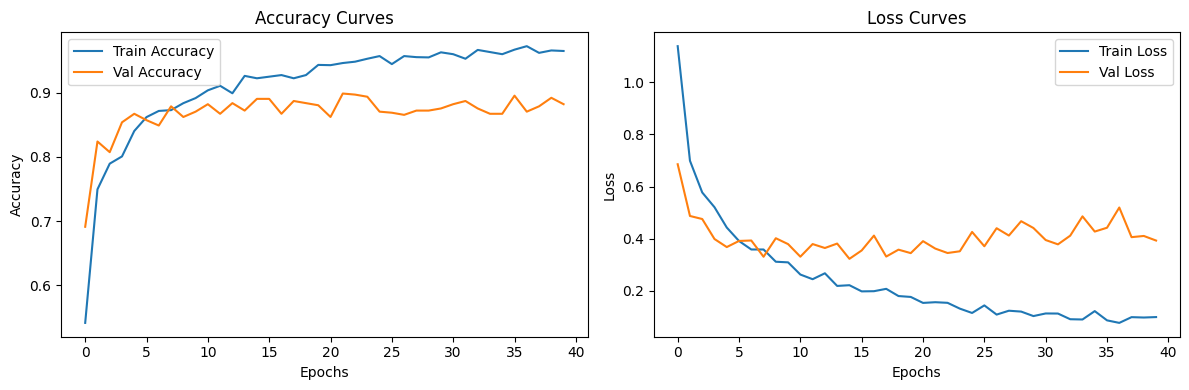

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 296ms/step
Confusion Matrix:
 [[77  0  0  0  1 10]
 [ 0 94  0  1  0  0]
 [ 0  0 93 12  5  1]
 [ 0  0 19 84  2  0]
 [ 3  0  2  5 89  3]
 [ 7  1  0  1  0 92]]


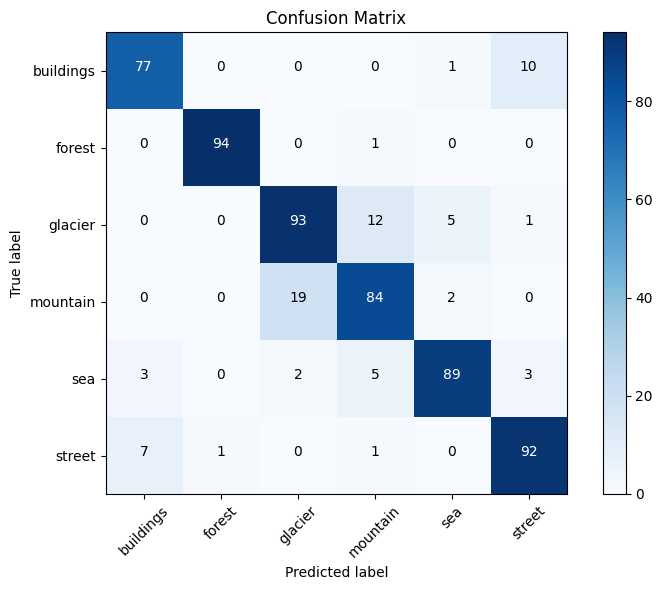

Classification Report:
               precision    recall  f1-score   support

   buildings       0.89      0.88      0.88        88
      forest       0.99      0.99      0.99        95
     glacier       0.82      0.84      0.83       111
    mountain       0.82      0.80      0.81       105
         sea       0.92      0.87      0.89       102
      street       0.87      0.91      0.89       101

    accuracy                           0.88       602
   macro avg       0.88      0.88      0.88       602
weighted avg       0.88      0.88      0.88       602



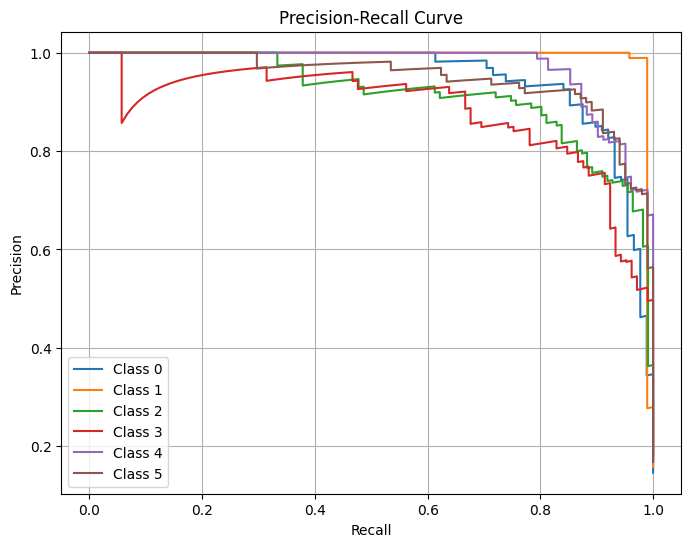

Model training and evaluation complete.


In [23]:
run_test_harness()

In [24]:
def run_test_harness():
    # Prepare data generators
    datagen = ImageDataGenerator(
        rescale=1.0 / 255.0,
        width_shift_range=0.1,  
        height_shift_range=0.1    
    )

    # Train and test directories
    train_dir = 'split_dataset/train'
    test_dir = 'split_dataset/test'

    # Prepare iterators for training and testing datasets
    train_it = datagen.flow_from_directory(
        train_dir,
        batch_size=32,
        target_size=(224, 224),
        class_mode='categorical',  # Multi-class classification
        shuffle=True
    )

    test_it = datagen.flow_from_directory(
        test_dir,
        batch_size=32,
        target_size=(224, 224),
        class_mode='categorical',
        shuffle=False
    )

    # Define the model
    num_classes = len(train_it.class_indices)  # Number of classes
    model = define_model(num_classes)  # Make sure this function is defined elsewhere

    # Get the layers for the VGG16 blocks
    base_model = model.layers[0]  # VGG16 base model
    blocks = [
        base_model.get_layer('block3_conv3'),  # 3rd block   
    ]

    # Training loop: progressively unfreeze blocks
    for i in range(len(blocks)):
        # Unfreeze the current block and freeze previous blocks
        for layer in base_model.layers:
            layer.trainable = False
        for j in range(i, len(blocks)):
            blocks[j].trainable = True

        # Recompile the model after unfreezing layers
        model.compile(optimizer=Adam(learning_rate=0.0001), 
                      loss='categorical_crossentropy', metrics=['accuracy'])

        # Train the model
        #print(f"Training with block {5 - i} unfrozen...")
        history = model.fit(
            train_it,
            validation_data=test_it,
            epochs=40
        )

        # Plot accuracy and loss curves for comparison
        plot_curves(history)

        # Evaluate model on test data
        test_steps = len(test_it)
        y_probs = model.predict(test_it, steps=test_steps, verbose=1)
        y_pred = np.argmax(y_probs, axis=1)
        y_true = test_it.classes

        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        print("Confusion Matrix:\n", cm)

        # Plot Confusion Matrix
        class_names = list(test_it.class_indices.keys())
        plot_confusion_matrix(cm, class_names)

        # Classification Report
        report = classification_report(y_true, y_pred, target_names=class_names)
        print("Classification Report:\n", report)

        # One-hot encode y_true
        y_true_one_hot = np.zeros((len(y_true), num_classes))
        y_true_one_hot[np.arange(len(y_true)), y_true] = 1

        # Precision-Recall Curves
        plot_pr_curve(y_true_one_hot, y_probs, num_classes)

        # Save Confusion Matrix to CSV
        cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
        cm_df.to_csv(f'confusion_matrix_block_{5 - i}.csv', index=True)

        # Save classification report
        report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
        report_df = pd.DataFrame(report_dict).transpose()
        report_df.to_csv(f'classification_report_block_{5 - i}.csv', index=True)

    print("Model training and evaluation complete.")



Found 2398 images belonging to 6 classes.
Found 602 images belonging to 6 classes.
Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 415ms/step - accuracy: 0.4256 - loss: 1.4536 - val_accuracy: 0.7791 - val_loss: 0.6157
Epoch 2/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 374ms/step - accuracy: 0.7670 - loss: 0.6731 - val_accuracy: 0.8073 - val_loss: 0.4812
Epoch 3/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 374ms/step - accuracy: 0.8189 - loss: 0.5253 - val_accuracy: 0.8688 - val_loss: 0.3877
Epoch 4/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 378ms/step - accuracy: 0.8403 - loss: 0.4591 - val_accuracy: 0.8688 - val_loss: 0.3584
Epoch 5/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 371ms/step - accuracy: 0.8901 - loss: 0.3272 - val_accuracy: 0.8854 - val_loss: 0.3398
Epoch 6/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 375ms/step - accuracy: 0.8918 - loss: 0.3229 - val_accuracy: 0.8837 - val_loss: 0.3541
Epoch 7/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 382ms/step - accuracy: 0.8979 - loss: 0.3008 - val_accuracy: 0.8671 - val_loss: 0.3817
Epoch 8/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 377ms/step - accuracy: 0.9045 - loss: 0.2789 - val_accuracy: 0.878

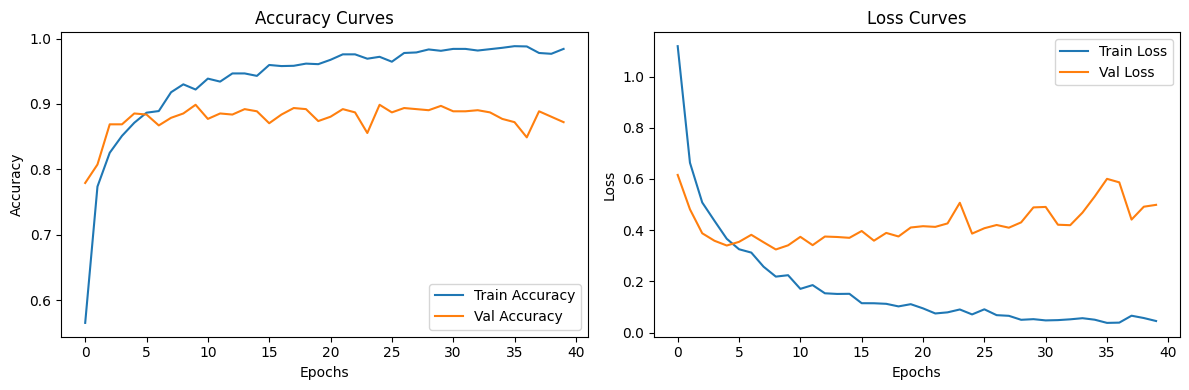

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 292ms/step
Confusion Matrix:
 [[79  0  0  0  0  9]
 [ 0 94  0  1  0  0]
 [ 0  0 93 17  1  0]
 [ 0  0  7 96  2  0]
 [ 3  0  4 13 82  0]
 [10  1  0  2  0 88]]


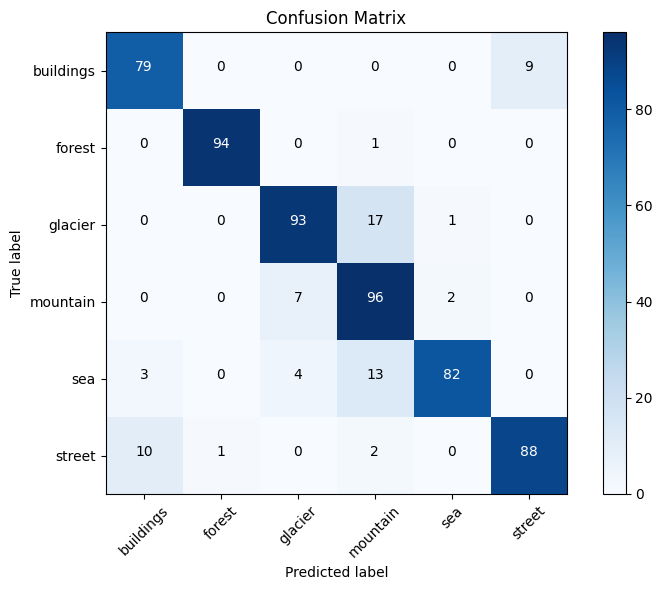

Classification Report:
               precision    recall  f1-score   support

   buildings       0.86      0.90      0.88        88
      forest       0.99      0.99      0.99        95
     glacier       0.89      0.84      0.87       111
    mountain       0.74      0.91      0.82       105
         sea       0.96      0.80      0.88       102
      street       0.91      0.87      0.89       101

    accuracy                           0.88       602
   macro avg       0.89      0.89      0.89       602
weighted avg       0.89      0.88      0.88       602



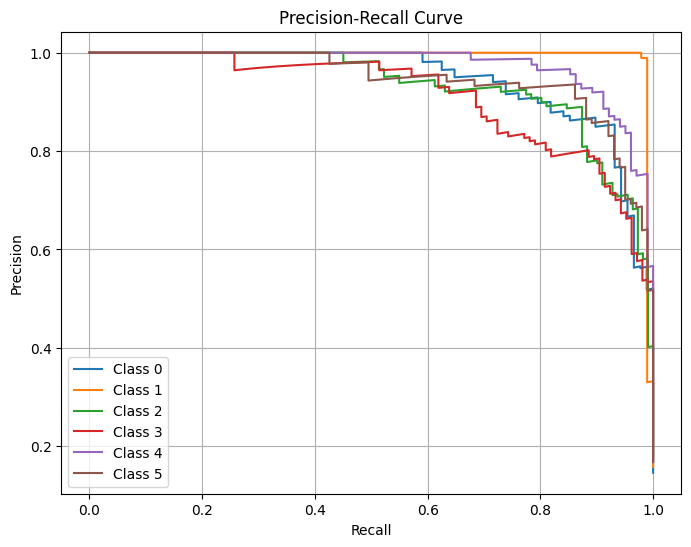

Model training and evaluation complete.


In [25]:
run_test_harness()

In [26]:
def run_test_harness():
    # Prepare data generators
    datagen = ImageDataGenerator(
        rescale=1.0 / 255.0,
        width_shift_range=0.1,  
        height_shift_range=0.1,
        horizontal_flip=True
    )

    # Train and test directories
    train_dir = 'split_dataset/train'
    test_dir = 'split_dataset/test'

    # Prepare iterators for training and testing datasets
    train_it = datagen.flow_from_directory(
        train_dir,
        batch_size=32,
        target_size=(224, 224),
        class_mode='categorical',  # Multi-class classification
        shuffle=True
    )

    test_it = datagen.flow_from_directory(
        test_dir,
        batch_size=32,
        target_size=(224, 224),
        class_mode='categorical',
        shuffle=False
    )

    # Define the model
    num_classes = len(train_it.class_indices)  # Number of classes
    model = define_model(num_classes)  # Make sure this function is defined elsewhere

    # Get the layers for the VGG16 blocks
    base_model = model.layers[0]  # VGG16 base model
    blocks = [
        base_model.get_layer('block3_conv3'),  # 3rd block   
    ]

    # Training loop: progressively unfreeze blocks
    for i in range(len(blocks)):
        # Unfreeze the current block and freeze previous blocks
        for layer in base_model.layers:
            layer.trainable = False
        for j in range(i, len(blocks)):
            blocks[j].trainable = True


        # Train the model
        #print(f"Training with block {5 - i} unfrozen...")
        history = model.fit(
            train_it,
            validation_data=test_it,
            epochs=40
        )

        # Plot accuracy and loss curves for comparison
        plot_curves(history)

        # Evaluate model on test data
        test_steps = len(test_it)
        y_probs = model.predict(test_it, steps=test_steps, verbose=1)
        y_pred = np.argmax(y_probs, axis=1)
        y_true = test_it.classes

        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        print("Confusion Matrix:\n", cm)

        # Plot Confusion Matrix
        class_names = list(test_it.class_indices.keys())
        plot_confusion_matrix(cm, class_names)

        # Classification Report
        report = classification_report(y_true, y_pred, target_names=class_names)
        print("Classification Report:\n", report)

        # One-hot encode y_true
        y_true_one_hot = np.zeros((len(y_true), num_classes))
        y_true_one_hot[np.arange(len(y_true)), y_true] = 1

        # Precision-Recall Curves
        plot_pr_curve(y_true_one_hot, y_probs, num_classes)

        # Save Confusion Matrix to CSV
        cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
        cm_df.to_csv(f'confusion_matrix_block_{5 - i}.csv', index=True)

        # Save classification report
        report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
        report_df = pd.DataFrame(report_dict).transpose()
        report_df.to_csv(f'classification_report_block_{5 - i}.csv', index=True)

    print("Model training and evaluation complete.")



Found 2398 images belonging to 6 classes.
Found 602 images belonging to 6 classes.
Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 416ms/step - accuracy: 0.4175 - loss: 1.4223 - val_accuracy: 0.7841 - val_loss: 0.5808
Epoch 2/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 377ms/step - accuracy: 0.7521 - loss: 0.6664 - val_accuracy: 0.8056 - val_loss: 0.5019
Epoch 3/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 379ms/step - accuracy: 0.8055 - loss: 0.5437 - val_accuracy: 0.8439 - val_loss: 0.4320
Epoch 4/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 377ms/step - accuracy: 0.8504 - loss: 0.4246 - val_accuracy: 0.8571 - val_loss: 0.3746
Epoch 5/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 374ms/step - accuracy: 0.8347 - loss: 0.4547 - val_accuracy: 0.8439 - val_loss: 0.3949
Epoch 6/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 378ms/step - accuracy: 0.8811 - loss: 0.3438 - val_accuracy: 0.8605 - val_loss: 0.3519
Epoch 7/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 371ms/step - accuracy: 0.8814 - loss: 0.3271 - val_accuracy: 0.8555 - val_loss: 0.3717
Epoch 8/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 371ms/step - accuracy: 0.8890 - loss: 0.3193 - val_accuracy: 0.863

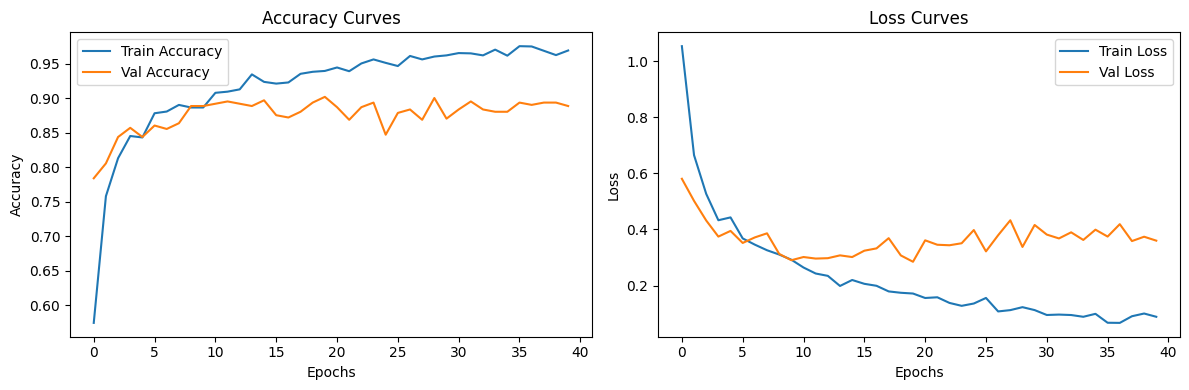

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 291ms/step
Confusion Matrix:
 [[82  0  0  0  0  6]
 [ 0 94  0  1  0  0]
 [ 0  0 89 20  2  0]
 [ 0  0  9 95  1  0]
 [ 2  0  2  7 91  0]
 [12  1  0  2  0 86]]


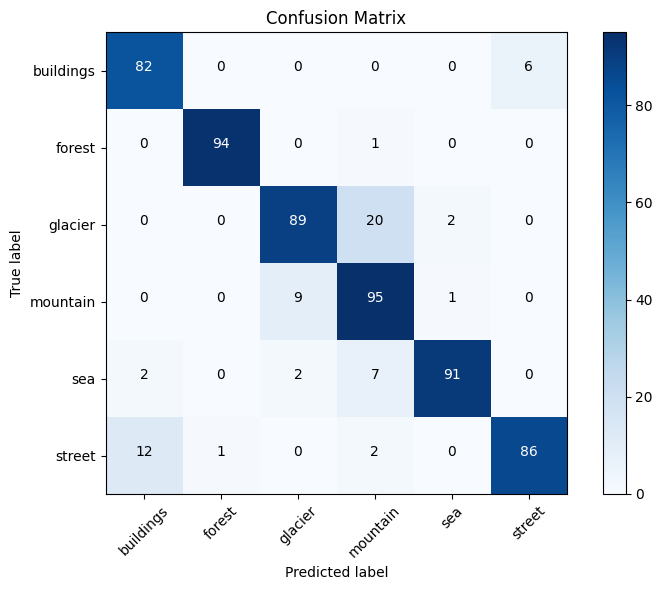

Classification Report:
               precision    recall  f1-score   support

   buildings       0.85      0.93      0.89        88
      forest       0.99      0.99      0.99        95
     glacier       0.89      0.80      0.84       111
    mountain       0.76      0.90      0.83       105
         sea       0.97      0.89      0.93       102
      street       0.93      0.85      0.89       101

    accuracy                           0.89       602
   macro avg       0.90      0.90      0.90       602
weighted avg       0.90      0.89      0.89       602



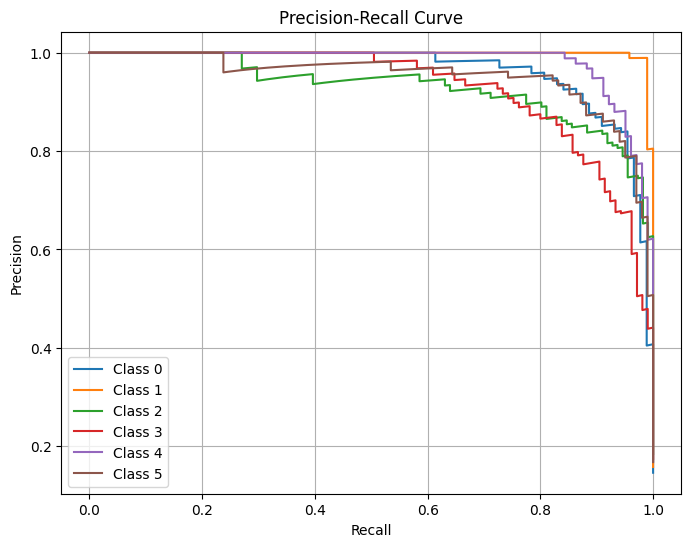

Model training and evaluation complete.


In [27]:
run_test_harness()

In [28]:
from tensorflow.keras.optimizers import SGD
# Define the model using VGG16
def define_model(num_classes):
    # Load the pre-trained VGG16 model without the top classifier layer
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze the convolutional base
    for layer in base_model.layers:
        layer.trainable = False

    # Build the model
    model = Sequential()
    model.add(base_model)

    # Add custom classification head with Dropout
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.6))  # Add Dropout after the dense layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    opt = SGD(learning_rate=0.0001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


Found 2398 images belonging to 6 classes.
Found 602 images belonging to 6 classes.
Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 37s 421ms/step - accuracy: 0.4210 - loss: 1.4701 - val_accuracy: 0.7907 - val_loss: 0.5739
Epoch 2/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 370ms/step - accuracy: 0.7528 - loss: 0.6561 - val_accuracy: 0.8173 - val_loss: 0.4529
Epoch 3/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 377ms/step - accuracy: 0.8319 - loss: 0.4911 - val_accuracy: 0.8505 - val_loss: 0.4005
Epoch 4/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 375ms/step - accuracy: 0.8364 - loss: 0.4679 - val_accuracy: 0.8704 - val_loss: 0.3673
Epoch 5/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 378ms/step - accuracy: 0.8734 - loss: 0.3730 - val_accuracy: 0.8422 - val_loss: 0.3833
Epoch 6/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 373ms/step - accuracy: 0.8776 - loss: 0.3428 - val_accuracy: 0.8688 - val_loss: 0.3638
Epoch 7/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 375ms/step - accuracy: 0.8866 - loss: 0.3389 - val_accuracy: 0.8738 - val_loss: 0.3270
Epoch 8/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 376ms/step - accuracy: 0.8966 - loss: 0.3127 - val_accuracy: 0.880

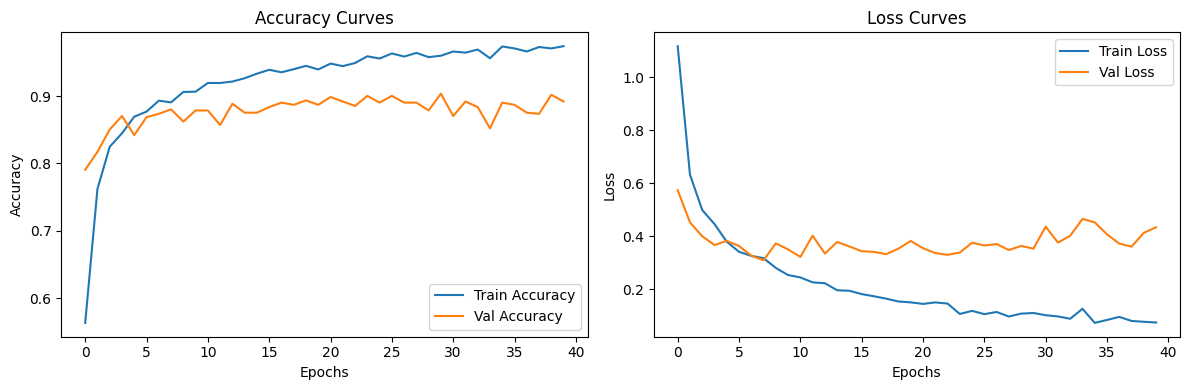

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 308ms/step
Confusion Matrix:
 [[76  1  0  0  0 11]
 [ 0 93  0  2  0  0]
 [ 0  0 98 13  0  0]
 [ 0  0 10 93  2  0]
 [ 1  1  6 10 83  1]
 [ 6  1  0  2  0 92]]


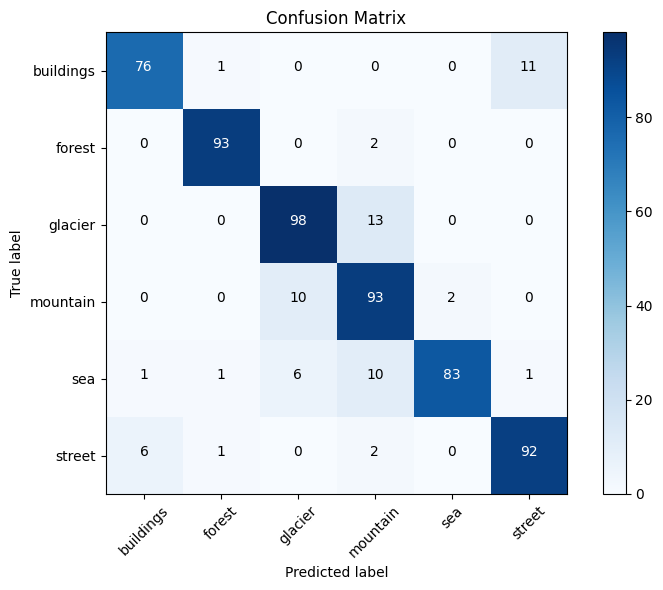

Classification Report:
               precision    recall  f1-score   support

   buildings       0.92      0.86      0.89        88
      forest       0.97      0.98      0.97        95
     glacier       0.86      0.88      0.87       111
    mountain       0.78      0.89      0.83       105
         sea       0.98      0.81      0.89       102
      street       0.88      0.91      0.90       101

    accuracy                           0.89       602
   macro avg       0.90      0.89      0.89       602
weighted avg       0.89      0.89      0.89       602



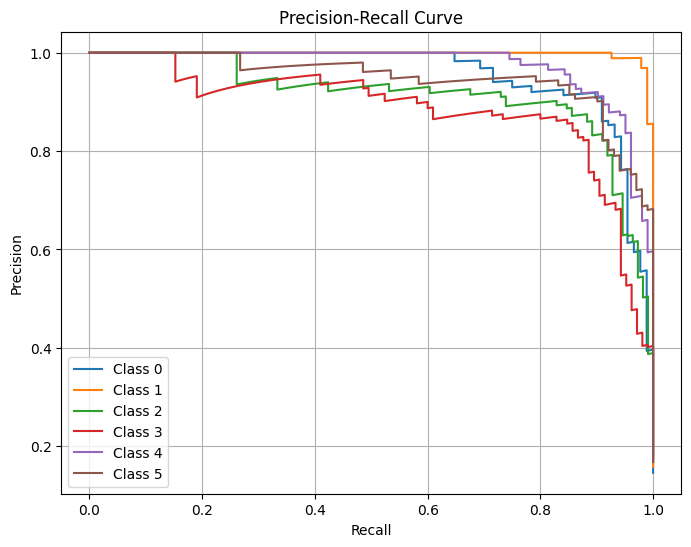

Model training and evaluation complete.


In [29]:
run_test_harness()

In [30]:
def run_test_harness():
    # Prepare data generators
    datagen = ImageDataGenerator(
        rescale=1.0 / 255.0,
        width_shift_range=0.1,  
        height_shift_range=0.1,
        horizontal_flip=True
    )

    # Train and test directories
    train_dir = 'split_dataset/train'
    test_dir = 'split_dataset/test'

    # Prepare iterators for training and testing datasets
    train_it = datagen.flow_from_directory(
        train_dir,
        batch_size=32,
        target_size=(224, 224),
        class_mode='categorical',  # Multi-class classification
        shuffle=True
    )

    test_it = datagen.flow_from_directory(
        test_dir,
        batch_size=32,
        target_size=(224, 224),
        class_mode='categorical',
        shuffle=False
    )

    # Define the model
    num_classes = len(train_it.class_indices)  # Number of classes
    model = define_model(num_classes)  # Make sure this function is defined elsewhere

    # Get the layers for the VGG16 blocks
    base_model = model.layers[0]  # VGG16 base model
    blocks = [
        base_model.get_layer('block3_conv3'),  # 3rd block   
    ]

    # Training loop: progressively unfreeze blocks
    for i in range(len(blocks)):
        # Unfreeze the current block and freeze previous blocks
        for layer in base_model.layers:
            layer.trainable = False
        for j in range(i, len(blocks)):
            blocks[j].trainable = True

        # Recompile the model after unfreezing layers
        model.compile(optimizer=Adam(learning_rate=0.0001), 
                      loss='categorical_crossentropy', metrics=['accuracy'])

        # Train the model
        #print(f"Training with block {5 - i} unfrozen...")
        history = model.fit(
            train_it,
            validation_data=test_it,
            epochs=60
        )

        # Plot accuracy and loss curves for comparison
        plot_curves(history)

        # Evaluate model on test data
        test_steps = len(test_it)
        y_probs = model.predict(test_it, steps=test_steps, verbose=1)
        y_pred = np.argmax(y_probs, axis=1)
        y_true = test_it.classes

        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        print("Confusion Matrix:\n", cm)

        # Plot Confusion Matrix
        class_names = list(test_it.class_indices.keys())
        plot_confusion_matrix(cm, class_names)

        # Classification Report
        report = classification_report(y_true, y_pred, target_names=class_names)
        print("Classification Report:\n", report)

        # One-hot encode y_true
        y_true_one_hot = np.zeros((len(y_true), num_classes))
        y_true_one_hot[np.arange(len(y_true)), y_true] = 1

        # Precision-Recall Curves
        plot_pr_curve(y_true_one_hot, y_probs, num_classes)

        # Save Confusion Matrix to CSV
        cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
        cm_df.to_csv(f'confusion_matrix_block_{5 - i}.csv', index=True)

        # Save classification report
        report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
        report_df = pd.DataFrame(report_dict).transpose()
        report_df.to_csv(f'classification_report_block_{5 - i}.csv', index=True)

    print("Model training and evaluation complete.")



Found 2398 images belonging to 6 classes.
Found 602 images belonging to 6 classes.
Epoch 1/60


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 415ms/step - accuracy: 0.4582 - loss: 1.4063 - val_accuracy: 0.8007 - val_loss: 0.5482
Epoch 2/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 370ms/step - accuracy: 0.7594 - loss: 0.6586 - val_accuracy: 0.8455 - val_loss: 0.4287
Epoch 3/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 376ms/step - accuracy: 0.8238 - loss: 0.5118 - val_accuracy: 0.8389 - val_loss: 0.4645
Epoch 4/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 376ms/step - accuracy: 0.8251 - loss: 0.4824 - val_accuracy: 0.8306 - val_loss: 0.4191
Epoch 5/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 374ms/step - accuracy: 0.8521 - loss: 0.4371 - val_accuracy: 0.8455 - val_loss: 0.4140
Epoch 6/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 375ms/step - accuracy: 0.8627 - loss: 0.4032 - val_accuracy: 0.8605 - val_loss: 0.3913
Epoch 7/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 377ms/step - accuracy: 0.8845 - loss: 0.3412 - val_accuracy: 0.8821 - val_loss: 0.3219
Epoch 8/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 370ms/step - accuracy: 0.8985 - loss: 0.2974 - val_accuracy: 0.885

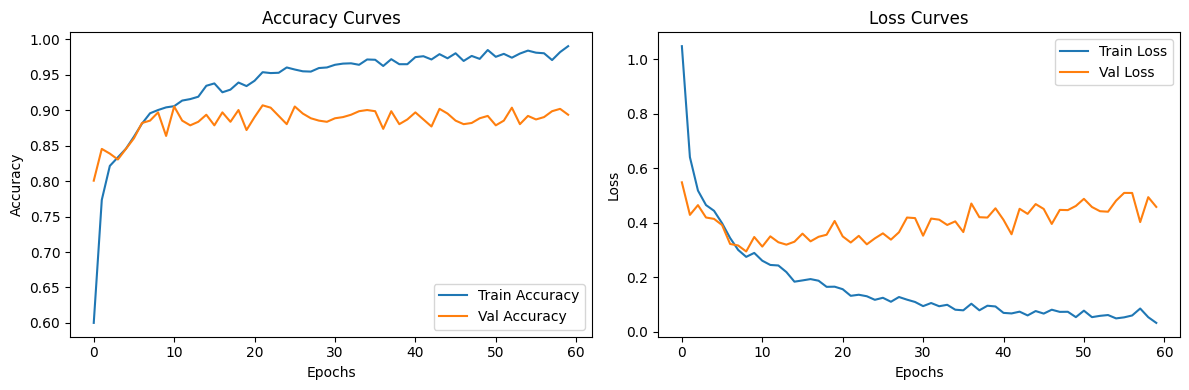

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 302ms/step
Confusion Matrix:
 [[77  0  0  0  0 11]
 [ 0 94  0  1  0  0]
 [ 0  0 96 12  3  0]
 [ 0  0 16 86  3  0]
 [ 0  1  2  4 95  0]
 [ 9  1  0  2  0 89]]


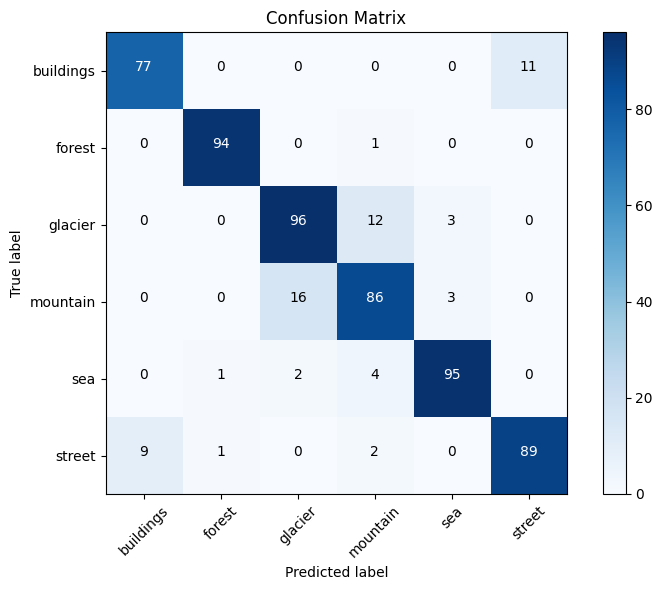

Classification Report:
               precision    recall  f1-score   support

   buildings       0.90      0.88      0.89        88
      forest       0.98      0.99      0.98        95
     glacier       0.84      0.86      0.85       111
    mountain       0.82      0.82      0.82       105
         sea       0.94      0.93      0.94       102
      street       0.89      0.88      0.89       101

    accuracy                           0.89       602
   macro avg       0.89      0.89      0.89       602
weighted avg       0.89      0.89      0.89       602



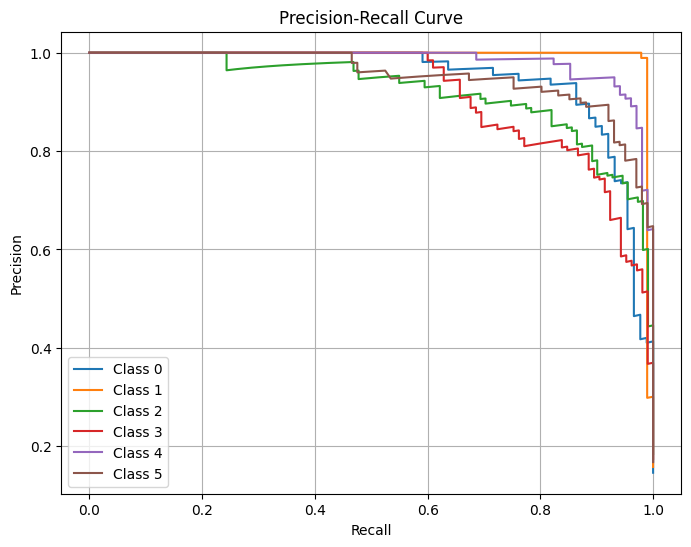

Model training and evaluation complete.


In [31]:
run_test_harness()

In [32]:
def run_test_harness():
    # Prepare data generators
    datagen = ImageDataGenerator(
        rescale=1.0 / 255.0,
        width_shift_range=0.1,  
        height_shift_range=0.1,
        horizontal_flip=True
    )

    # Train and test directories
    train_dir = 'split_dataset/train'
    test_dir = 'split_dataset/test'

    # Prepare iterators for training and testing datasets
    train_it = datagen.flow_from_directory(
        train_dir,
        batch_size=32,
        target_size=(224, 224),
        class_mode='categorical',  # Multi-class classification
        shuffle=True
    )

    test_it = datagen.flow_from_directory(
        test_dir,
        batch_size=32,
        target_size=(224, 224),
        class_mode='categorical',
        shuffle=False
    )

    # Define the model
    num_classes = len(train_it.class_indices)  # Number of classes
    model = define_model(num_classes)  # Make sure this function is defined elsewhere

    # Get the layers for the VGG16 blocks
    base_model = model.layers[0]  # VGG16 base model
    blocks = [
        base_model.get_layer('block3_conv3'),  # 3rd block   
    ]

    # Training loop: progressively unfreeze blocks
    for i in range(len(blocks)):
        # Unfreeze the current block and freeze previous blocks
        for layer in base_model.layers:
            layer.trainable = False
        for j in range(i, len(blocks)):
            blocks[j].trainable = True


        # Train the model
        #print(f"Training with block {5 - i} unfrozen...")
        history = model.fit(
            train_it,
            validation_data=test_it,
            epochs=40
        )

        # Plot accuracy and loss curves for comparison
        plot_curves(history)

        # Evaluate model on test data
        test_steps = len(test_it)
        y_probs = model.predict(test_it, steps=test_steps, verbose=1)
        y_pred = np.argmax(y_probs, axis=1)
        y_true = test_it.classes

        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        print("Confusion Matrix:\n", cm)

        # Plot Confusion Matrix
        class_names = list(test_it.class_indices.keys())
        plot_confusion_matrix(cm, class_names)

        # Classification Report
        report = classification_report(y_true, y_pred, target_names=class_names)
        print("Classification Report:\n", report)

        # One-hot encode y_true
        y_true_one_hot = np.zeros((len(y_true), num_classes))
        y_true_one_hot[np.arange(len(y_true)), y_true] = 1

        # Precision-Recall Curves
        plot_pr_curve(y_true_one_hot, y_probs, num_classes)

        # Save Confusion Matrix to CSV
        cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
        cm_df.to_csv(f'confusion_matrix_block_{5 - i}.csv', index=True)

        # Save classification report
        report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
        report_df = pd.DataFrame(report_dict).transpose()
        report_df.to_csv(f'classification_report_block_{5 - i}.csv', index=True)

    print("Model training and evaluation complete.")



In [33]:
from tensorflow.keras.optimizers import SGD
# Define the model using VGG16
def define_model(num_classes):
    # Load the pre-trained VGG16 model without the top classifier layer
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze the convolutional base
    for layer in base_model.layers:
        layer.trainable = False

    # Build the model
    model = Sequential()
    model.add(base_model)

    # Add custom classification head with Dropout
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.6))  # Add Dropout after the dense layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    opt = SGD(learning_rate=0.0001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [ ]:
run_test_harness()

Found 2398 images belonging to 6 classes.
Found 602 images belonging to 6 classes.
Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 37s 414ms/step - accuracy: 0.2243 - loss: 1.9065 - val_accuracy: 0.6196 - val_loss: 1.4008
Epoch 2/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 377ms/step - accuracy: 0.4357 - loss: 1.4188 - val_accuracy: 0.6993 - val_loss: 1.0931
Epoch 3/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 377ms/step - accuracy: 0.5506 - loss: 1.1684 - val_accuracy: 0.6844 - val_loss: 0.9230
Epoch 4/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 377ms/step - accuracy: 0.5943 - loss: 1.0194 - val_accuracy: 0.7409 - val_loss: 0.7958
Epoch 5/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 378ms/step - accuracy: 0.6417 - loss: 0.9372 - val_accuracy: 0.7741 - val_loss: 0.7101
Epoch 6/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 375ms/step - accuracy: 0.6881 - loss: 0.8350 - val_accuracy: 0.8090 - val_loss: 0.6290
Epoch 7/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 371ms/step - accuracy: 0.7055 - loss: 0.7708 - val_accuracy: 0.7824 - val_loss: 0.6265
Epoch 8/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 378ms/step - accuracy: 0.7228 - loss: 0.7423 - val_accuracy: 0.797